In [10]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.convolution import convolve, Box1DKernel



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Assemle each xhsooter spectrum, scale to blue and phase

In [11]:
path = 'spectra/nicola_2/WDJ114404.76+052951.77/'
uvbfits = glob.glob('{}UVB/*.fits'.format(path))
visfits = glob.glob('{}VIS_notell/*.fits'.format(path))
nirfits = glob.glob('{}NIR/*.fits'.format(path))

In [12]:
nspec = len(uvbfits)
print(len(uvbfits), len(visfits), len(nirfits))

33 33 29


In [13]:
print(uvbfits[0], visfits[0], nirfits[0])

spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_13.fits spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_5_TAC.fits spectra/nicola_2/WDJ114404.76+052951.77/NIR/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_NIR_21.fits


In [14]:
udates = []
vdates = []
ndates = []

for i in range(nspec):
    uhdr = fits.getheader('{}UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_{}.fits'.format(path, i))
    vhdr = fits.getheader('{}VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_{}_TAC.fits'.format(path, i))
    udate = uhdr['MJD-OBS']
    vdate = vhdr['MJD-OBS']
    if i not in (4, 5, 6, 7):
        adj = 0
        if i > 6:
            adj = 4
        nhdr = fits.getheader('{}NIR/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_NIR_{}.fits'.format(path, i-adj))
        ndate = nhdr['MJD-OBS']
    else:
        ndate= -1
    print(i, udate, vdate, ndate, ((udate-vdate)*u.d).to(u.s), ((vdate-ndate)*u.d).to(u.s))
    udates.append(udate)
    vdates.append(vdate)
    ndates.append(ndate)

0 58601.08776086 58601.087820703 58601.08786006 -5.170435016043484 s -3.4004448680207133 s
1 58601.092384639 58601.092444713 58601.09247971 -5.190393794327974 s -3.0237407656386495 s
2 58601.099411982 58601.099471593 58601.0995035 -5.1503901137039065 s -2.756764995865524 s
3 58601.104029856 58601.104089584 58601.10412316 -5.160499317571521 s -2.9009668389335275 s
4 58601.148232628 58601.148292353 -1 -5.160239688120782 s 5063225612.459299 s
5 58601.156321169 58601.15638136 -1 -5.200502369552851 s 5063226311.349504 s
6 58601.166954609 58601.167014453 -1 -5.17052176874131 s 5063227230.048739 s
7 58601.175045006 58601.175105082 -1 -5.190566671080887 s 5063227929.079085 s
8 58602.066421016 58602.066480512 58602.06651242 -5.140454415231943 s -2.7568511199206114 s
9 58602.072192929 58602.072252656 58602.07229075 -5.160412564873695 s -3.2913219183683395 s
10 58602.077965422 58602.078025612 58602.07806138 -5.200415616855025 s -3.0903555219992995 s
11 58602.08373641 58602.083796484 58602.0838320

0
0
1


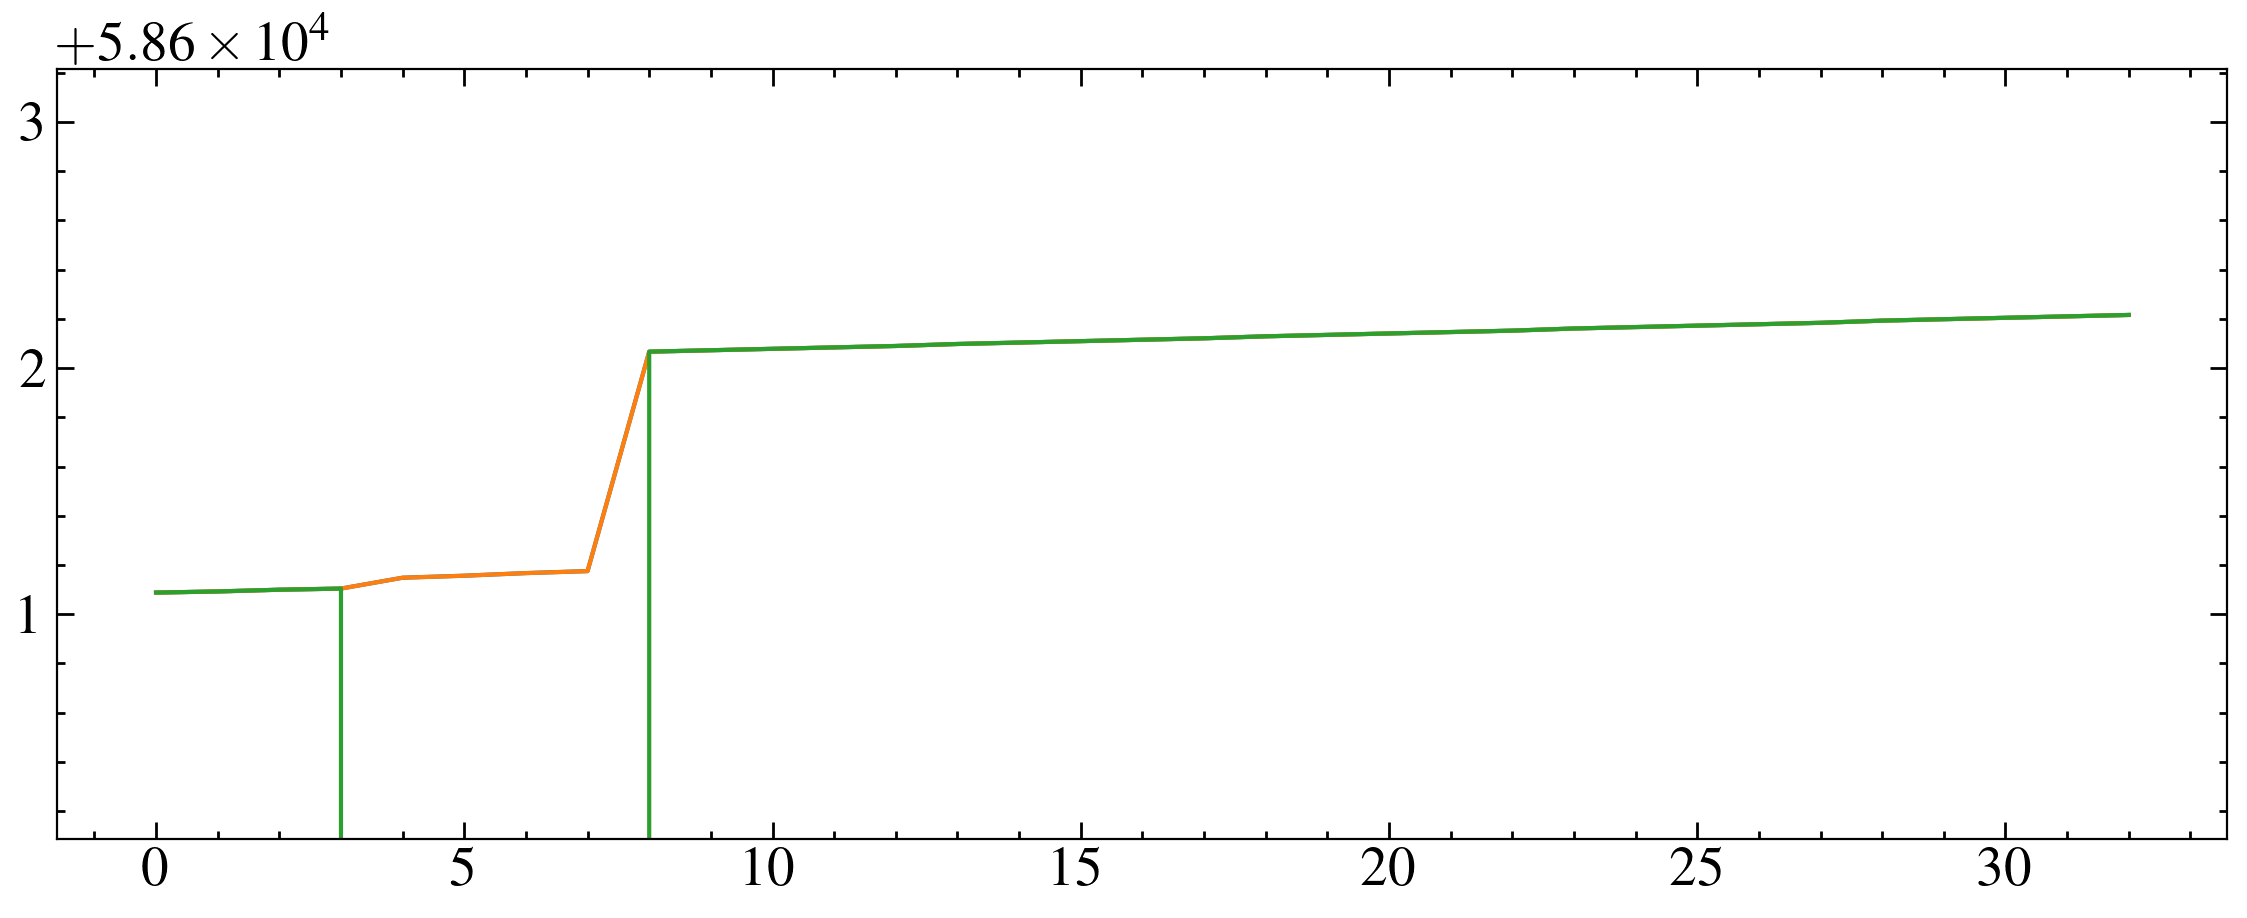

In [15]:
fig, ax = plt.subplots()

xaxis = np.arange(nspec)
ax.plot(xaxis, vdates)
ax.plot(xaxis, udates)
ax.plot(xaxis, ndates)
ax.set_ylim(min(np.array(vdates))-1, max(np.array(vdates))+1)
print(len(np.diff(udates)[np.diff(udates) <0]))
print(len(np.diff(vdates)[np.diff(vdates) <0]))
print(len(np.diff(ndates)[np.diff(ndates) <0]))

ok so they are in order

/tmp/ipykernel_23994/1099654764.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


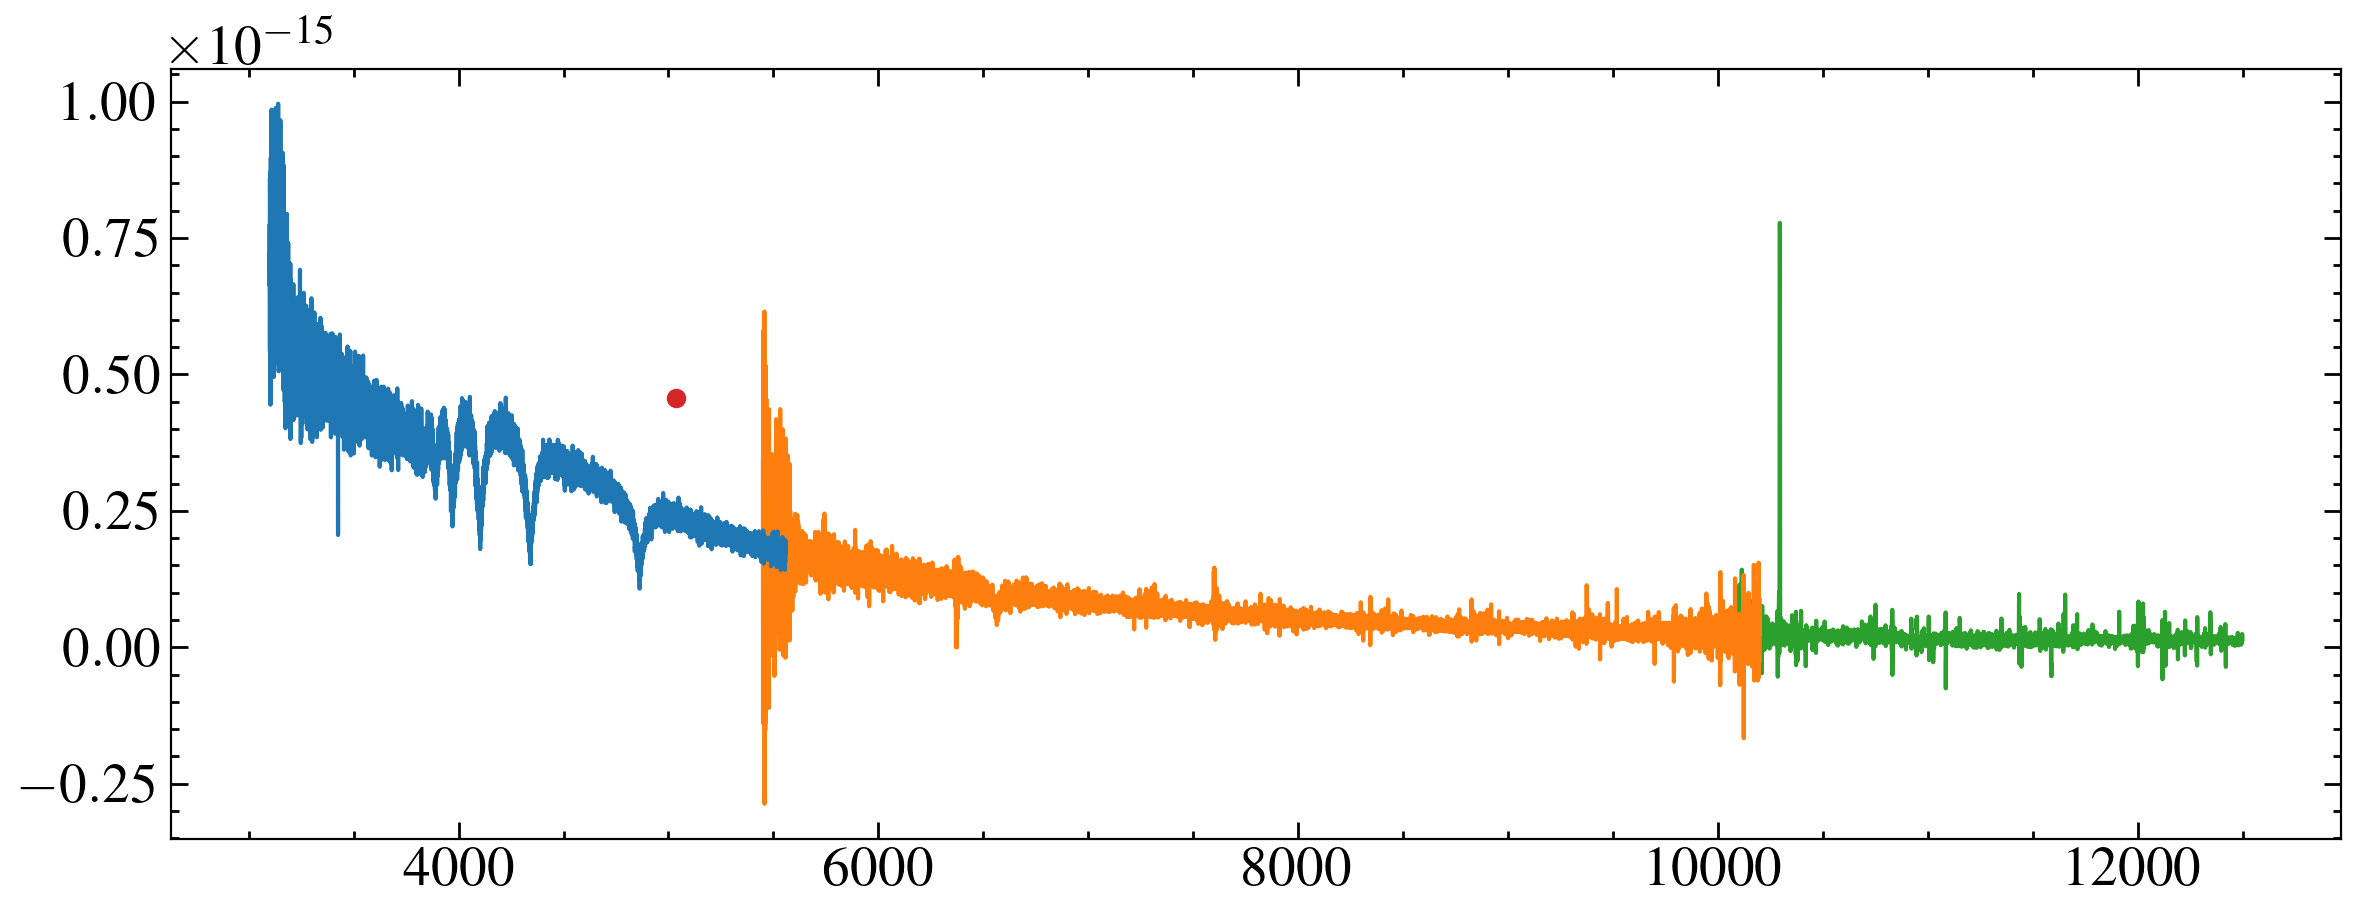

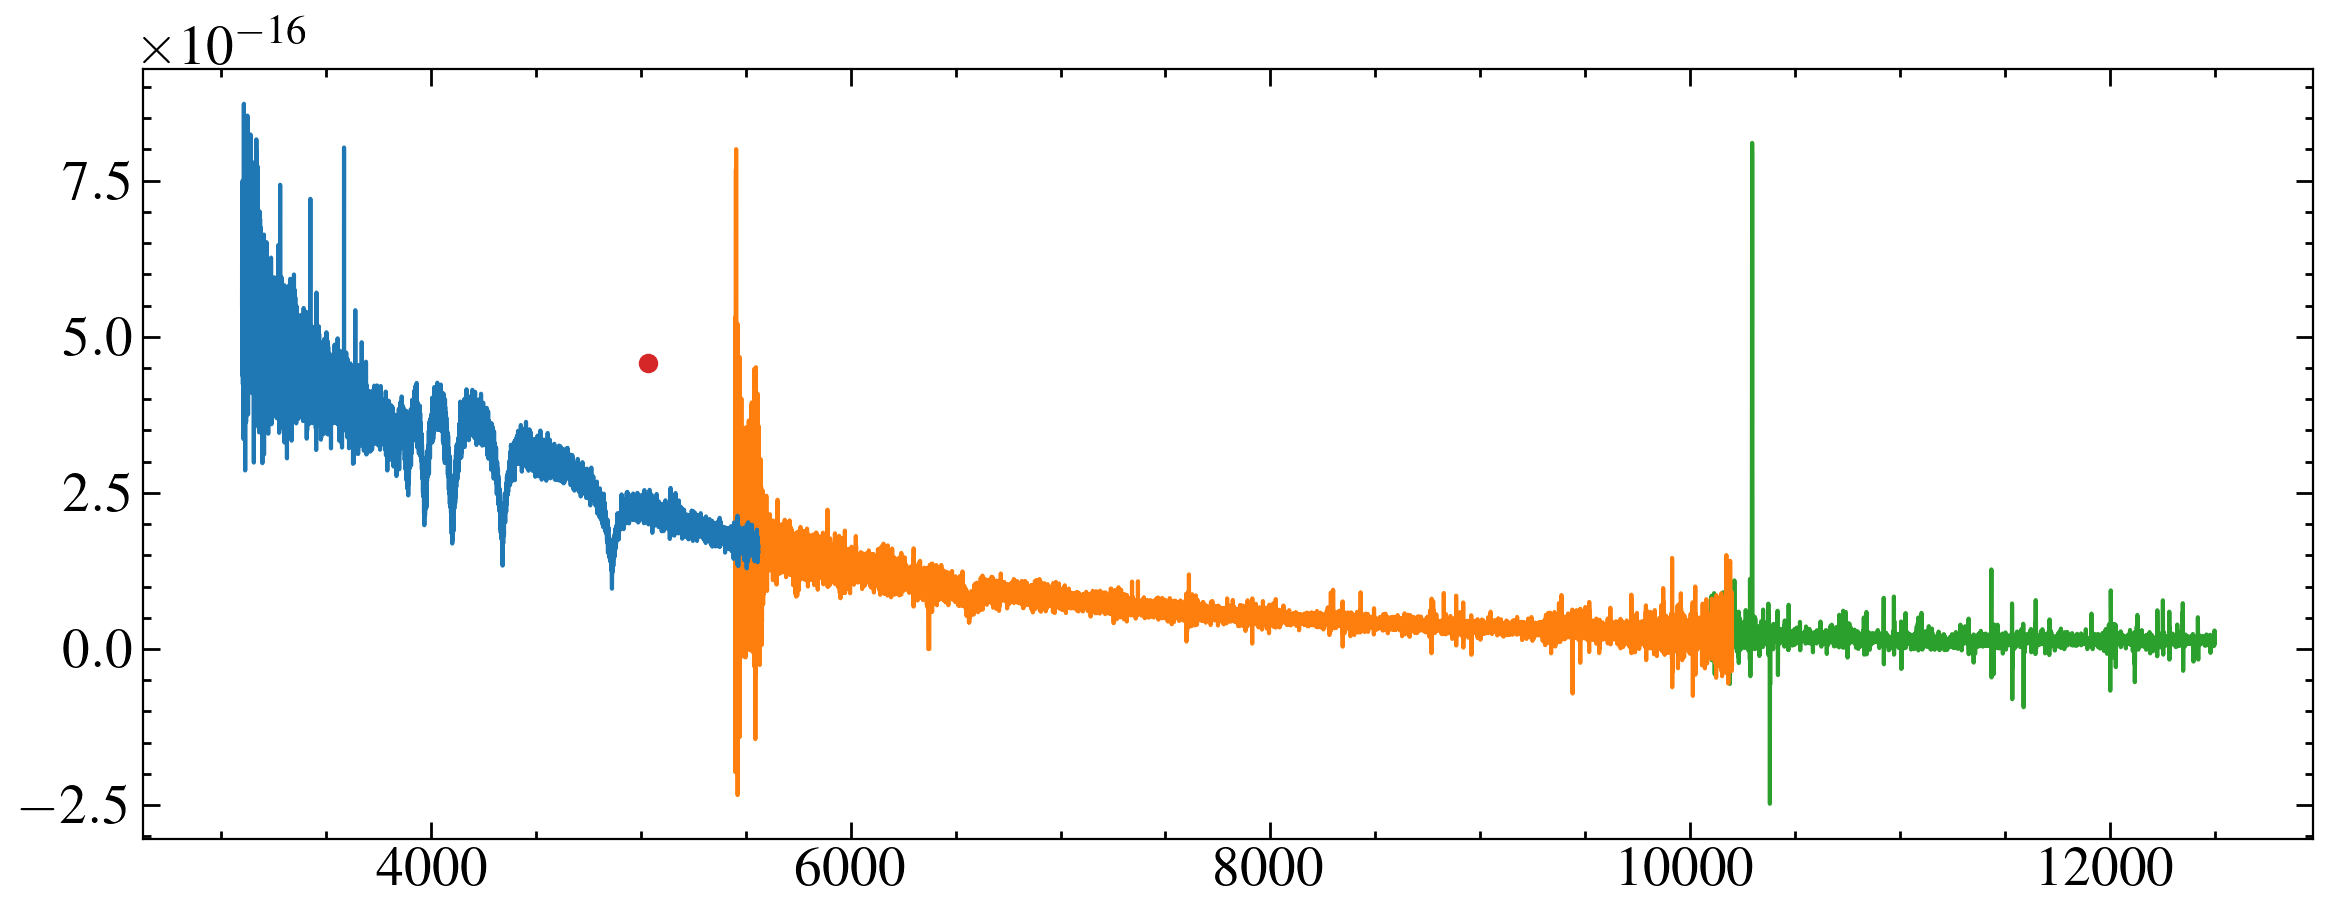

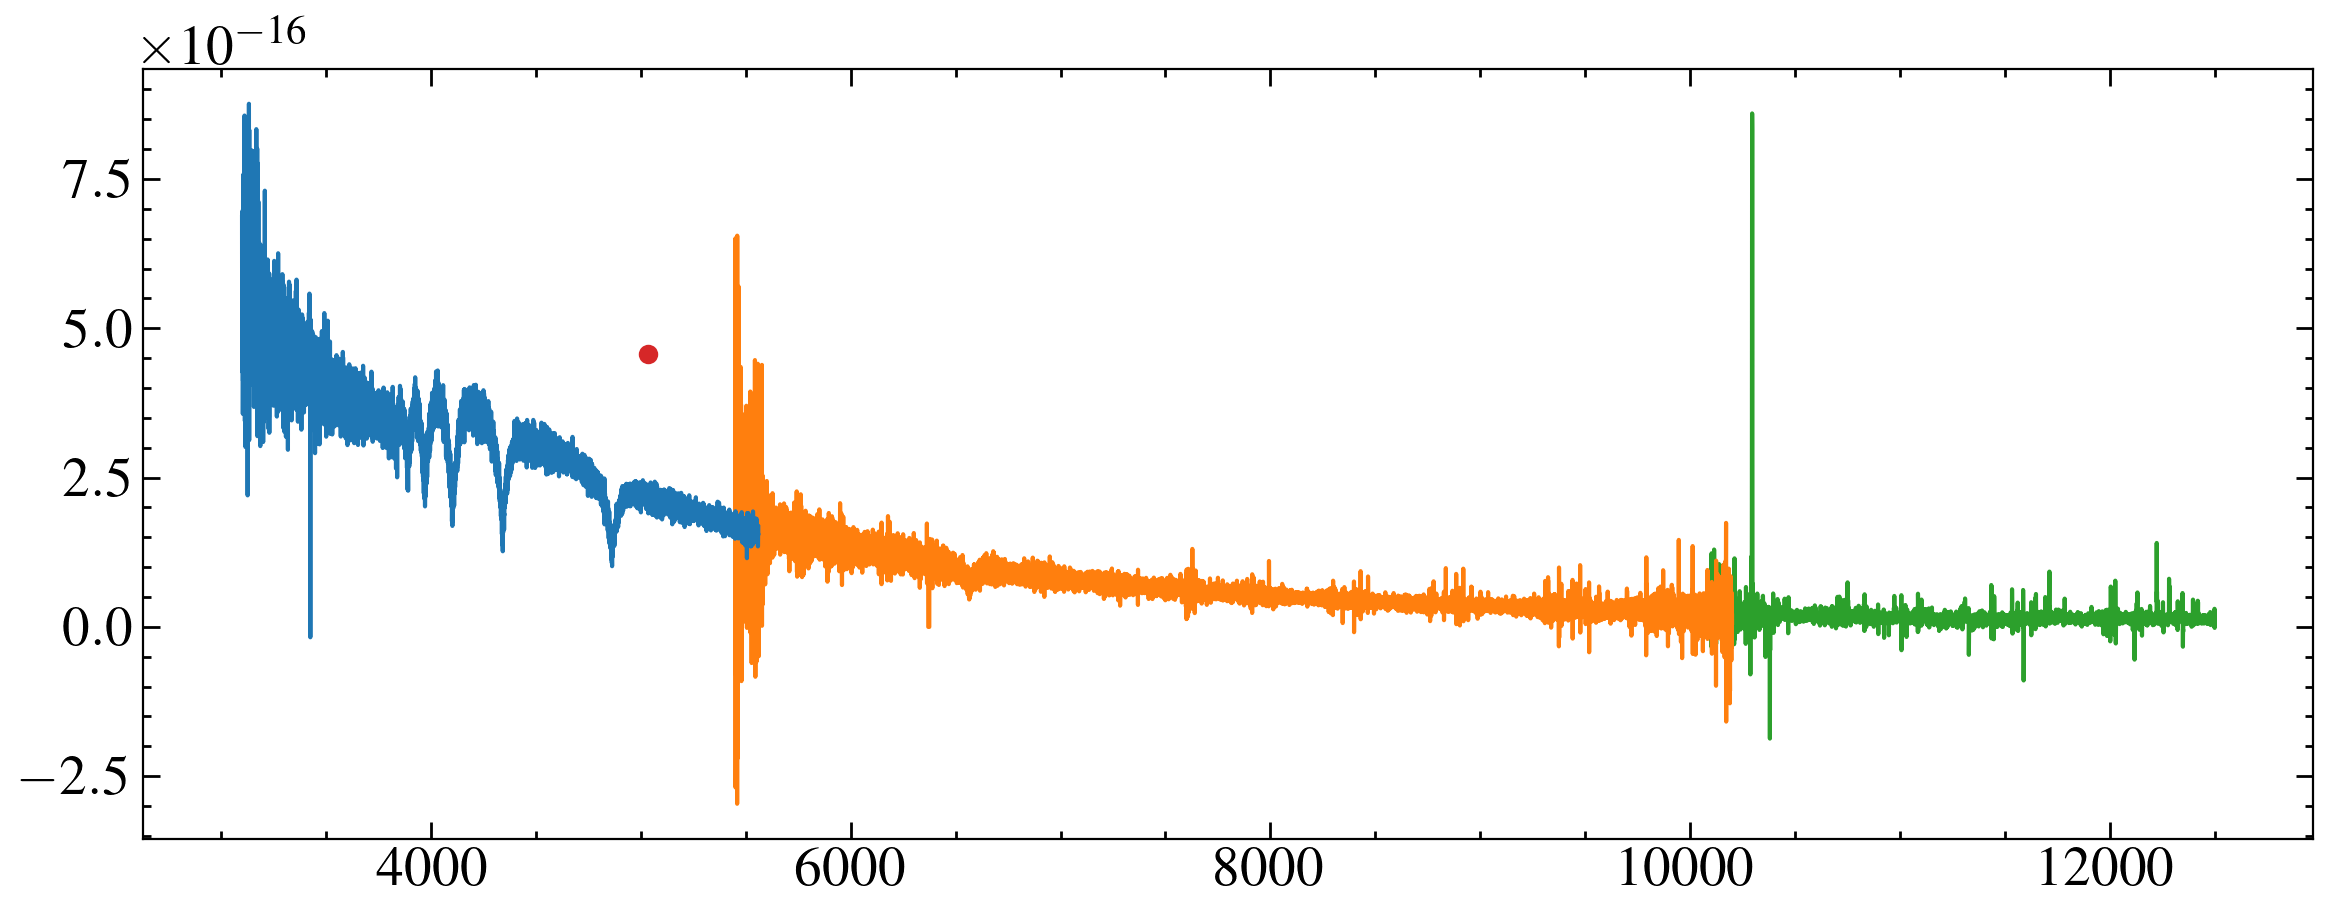

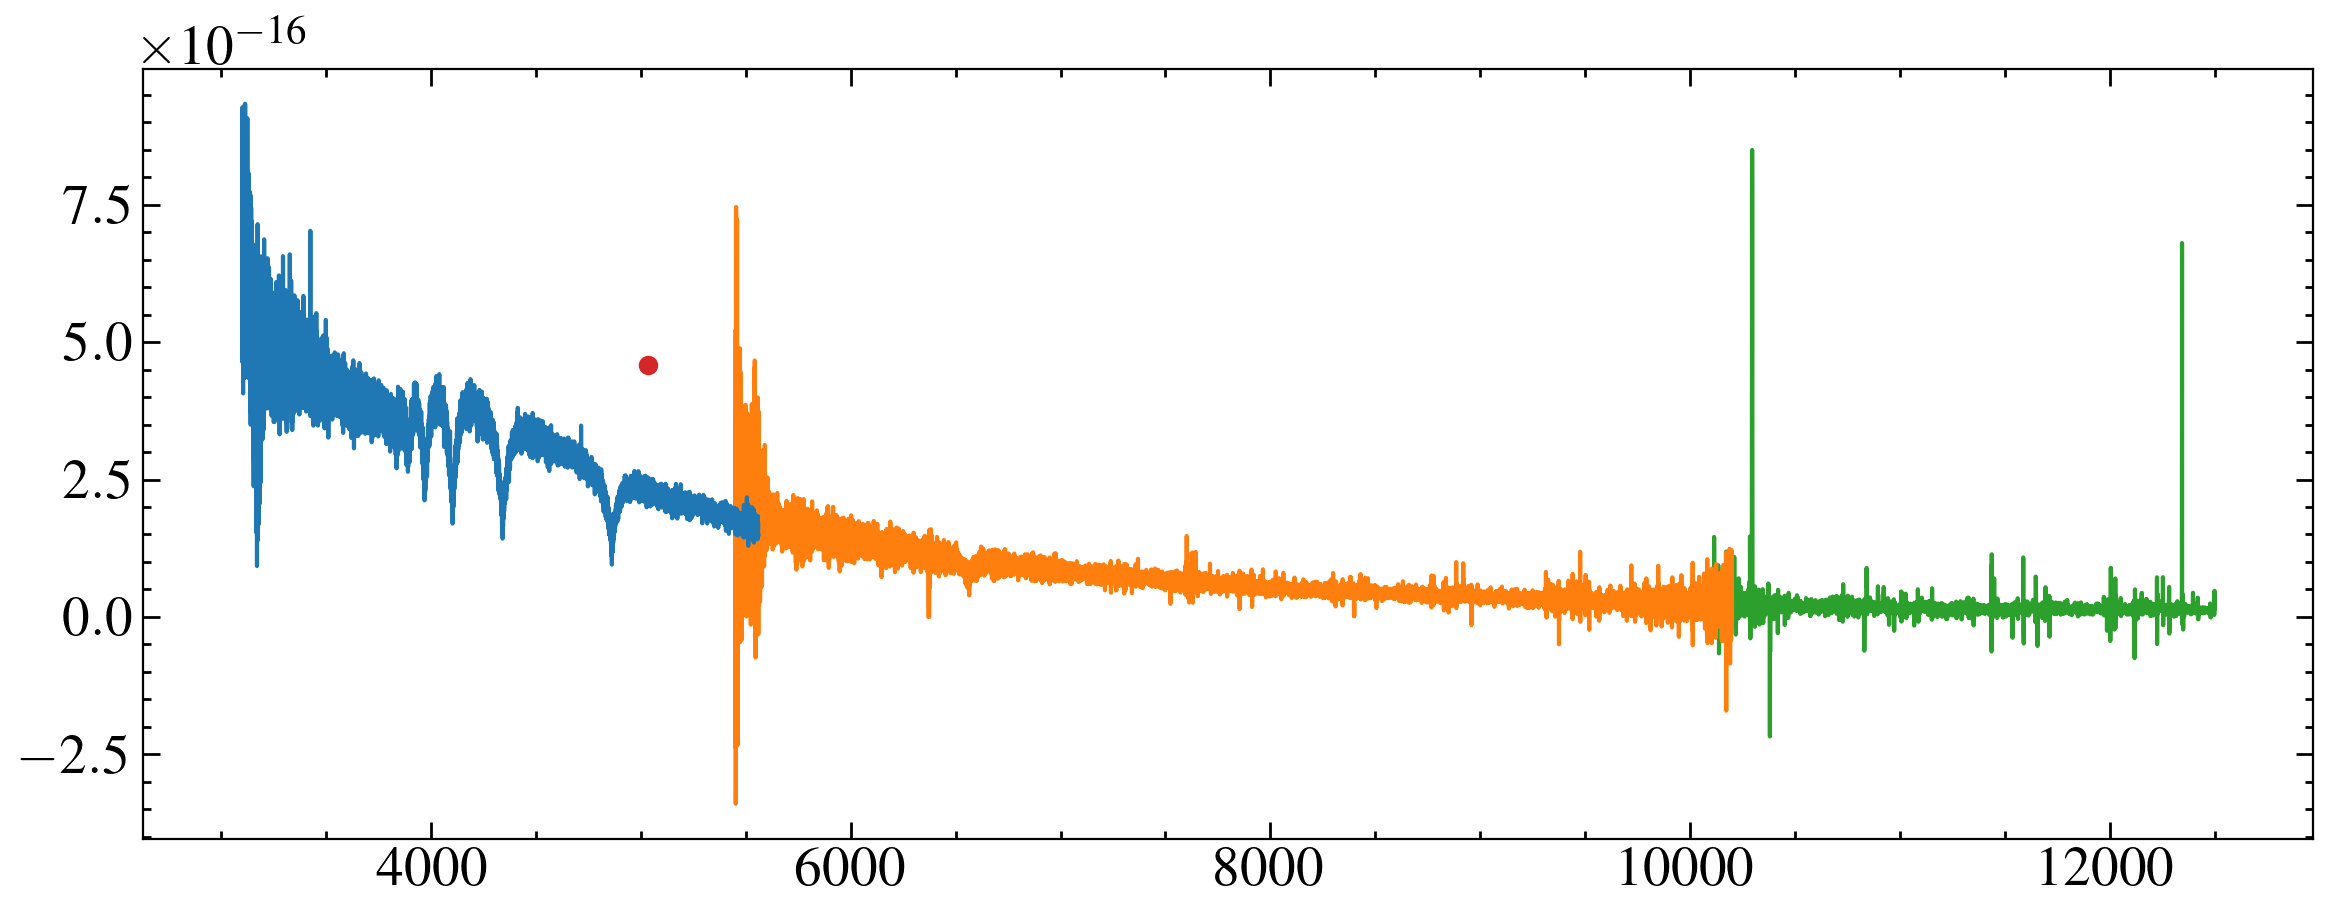

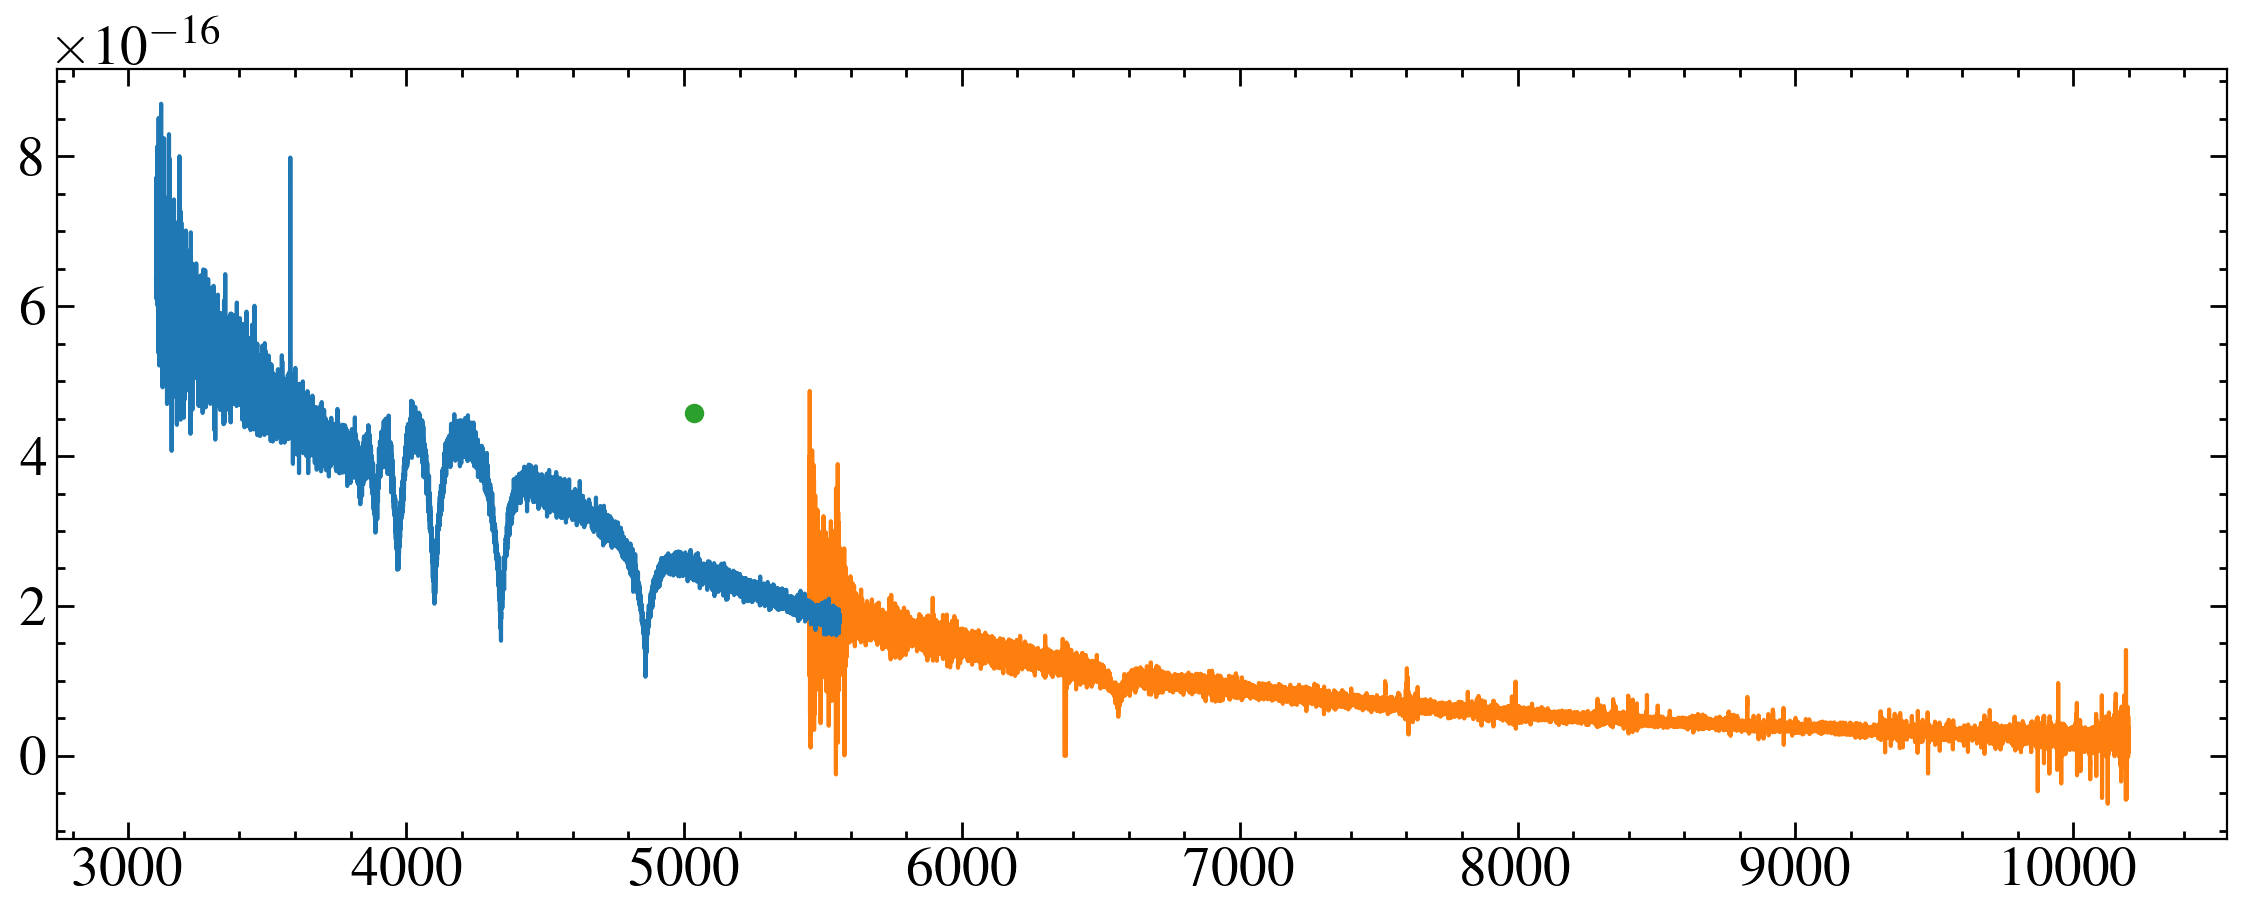

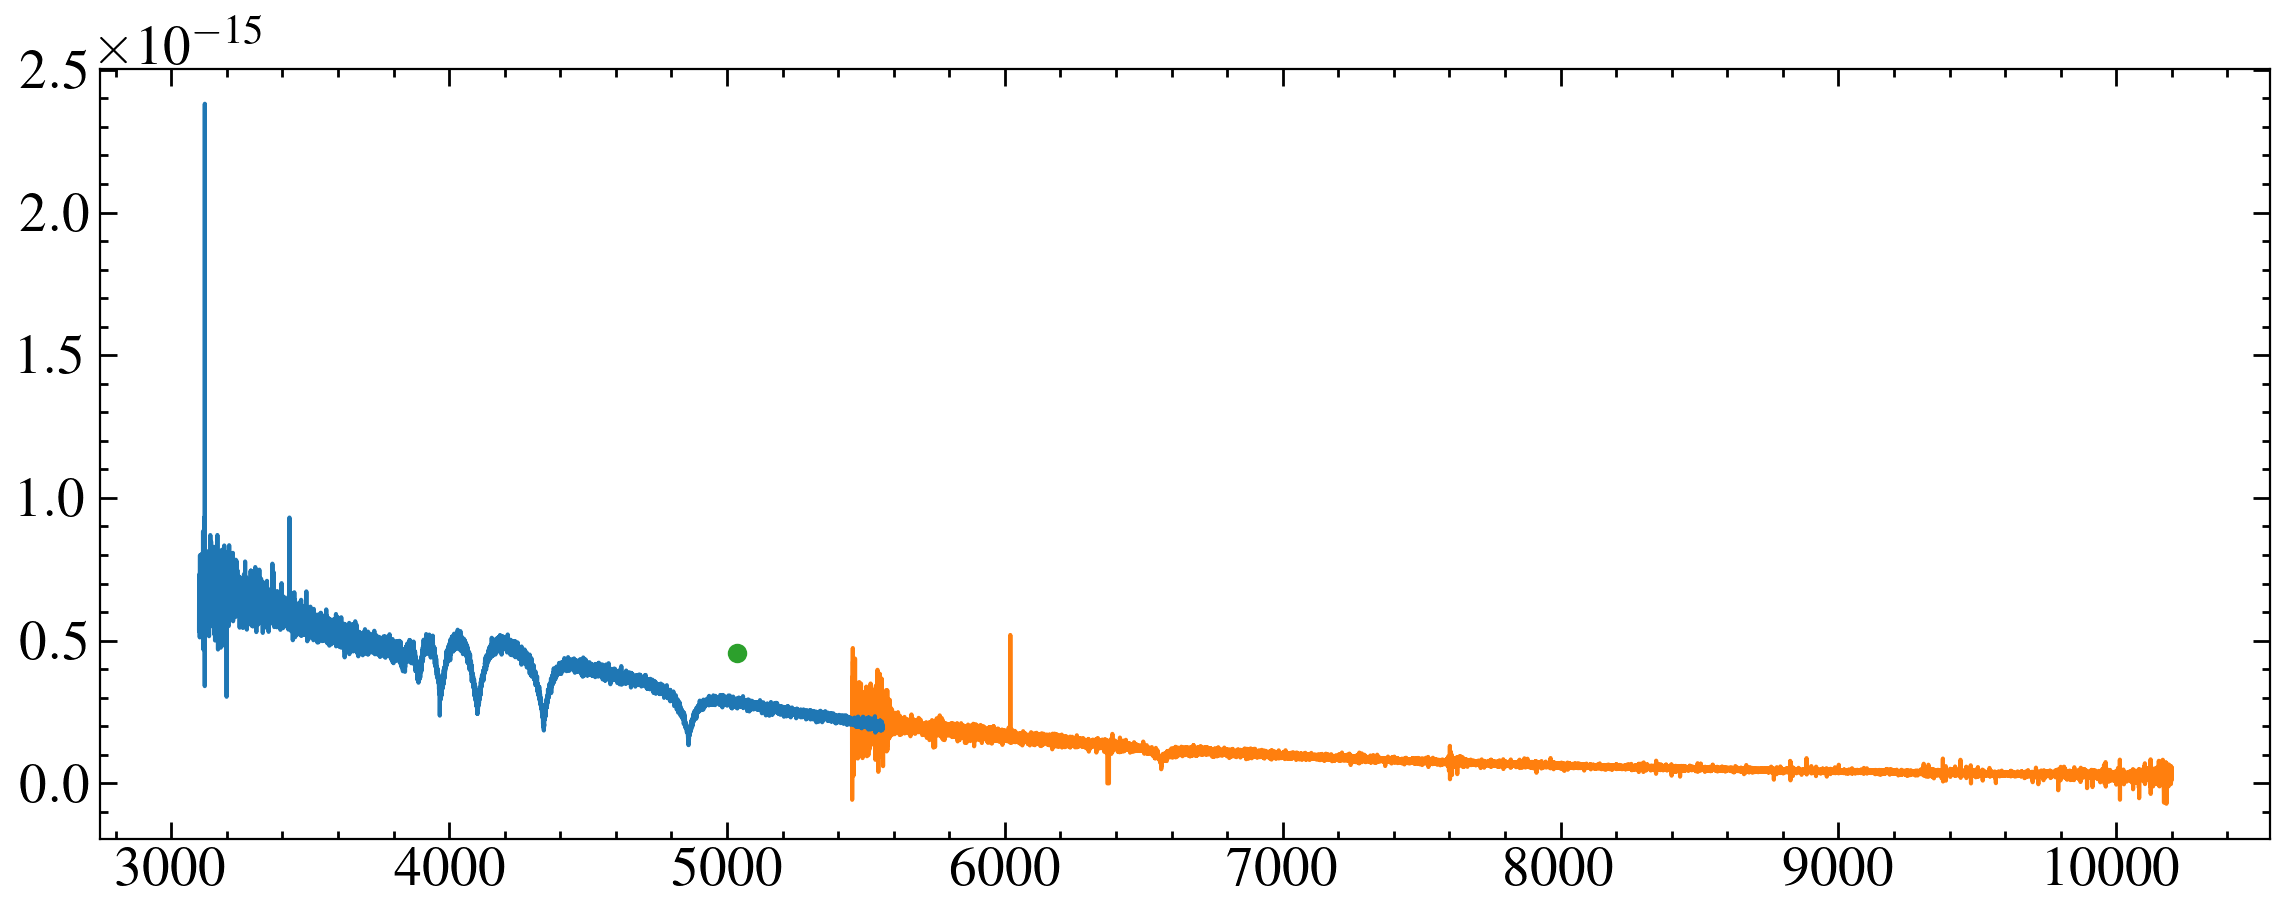

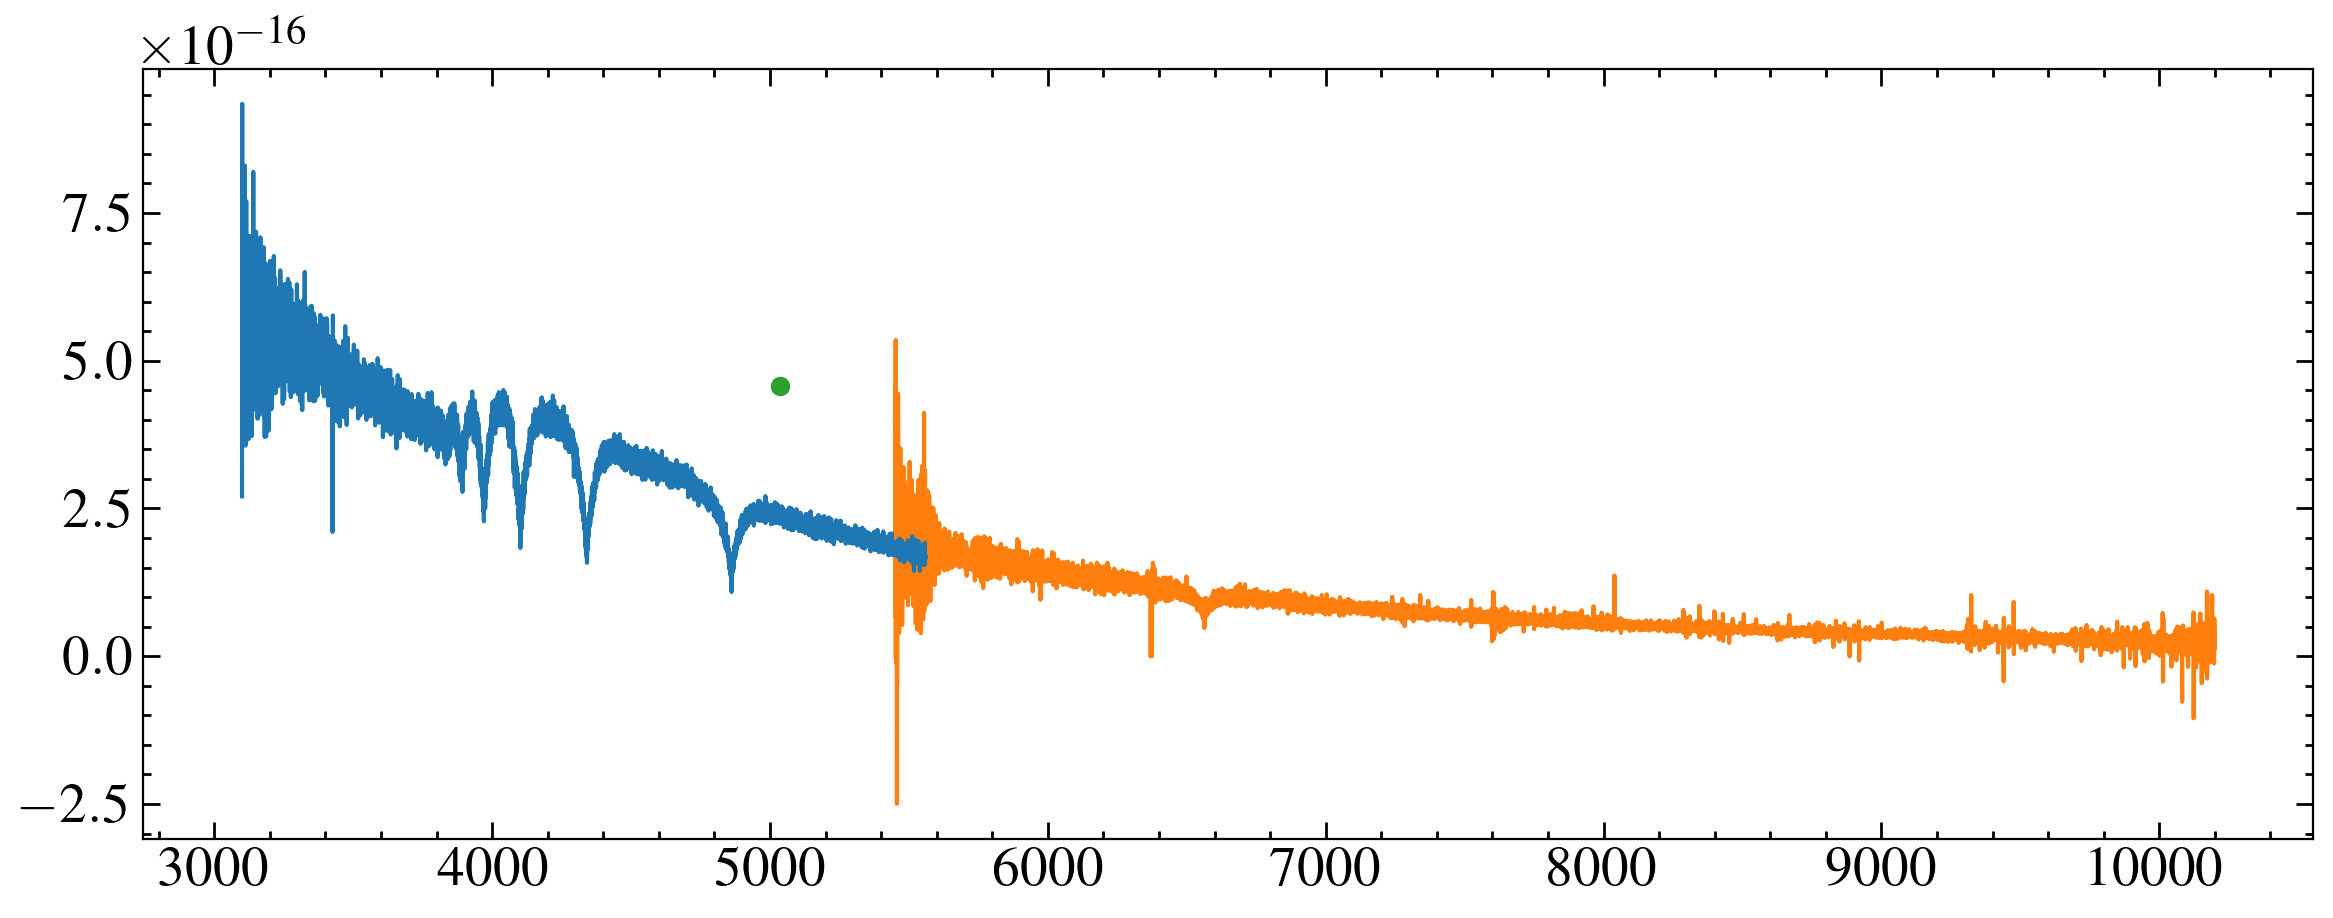

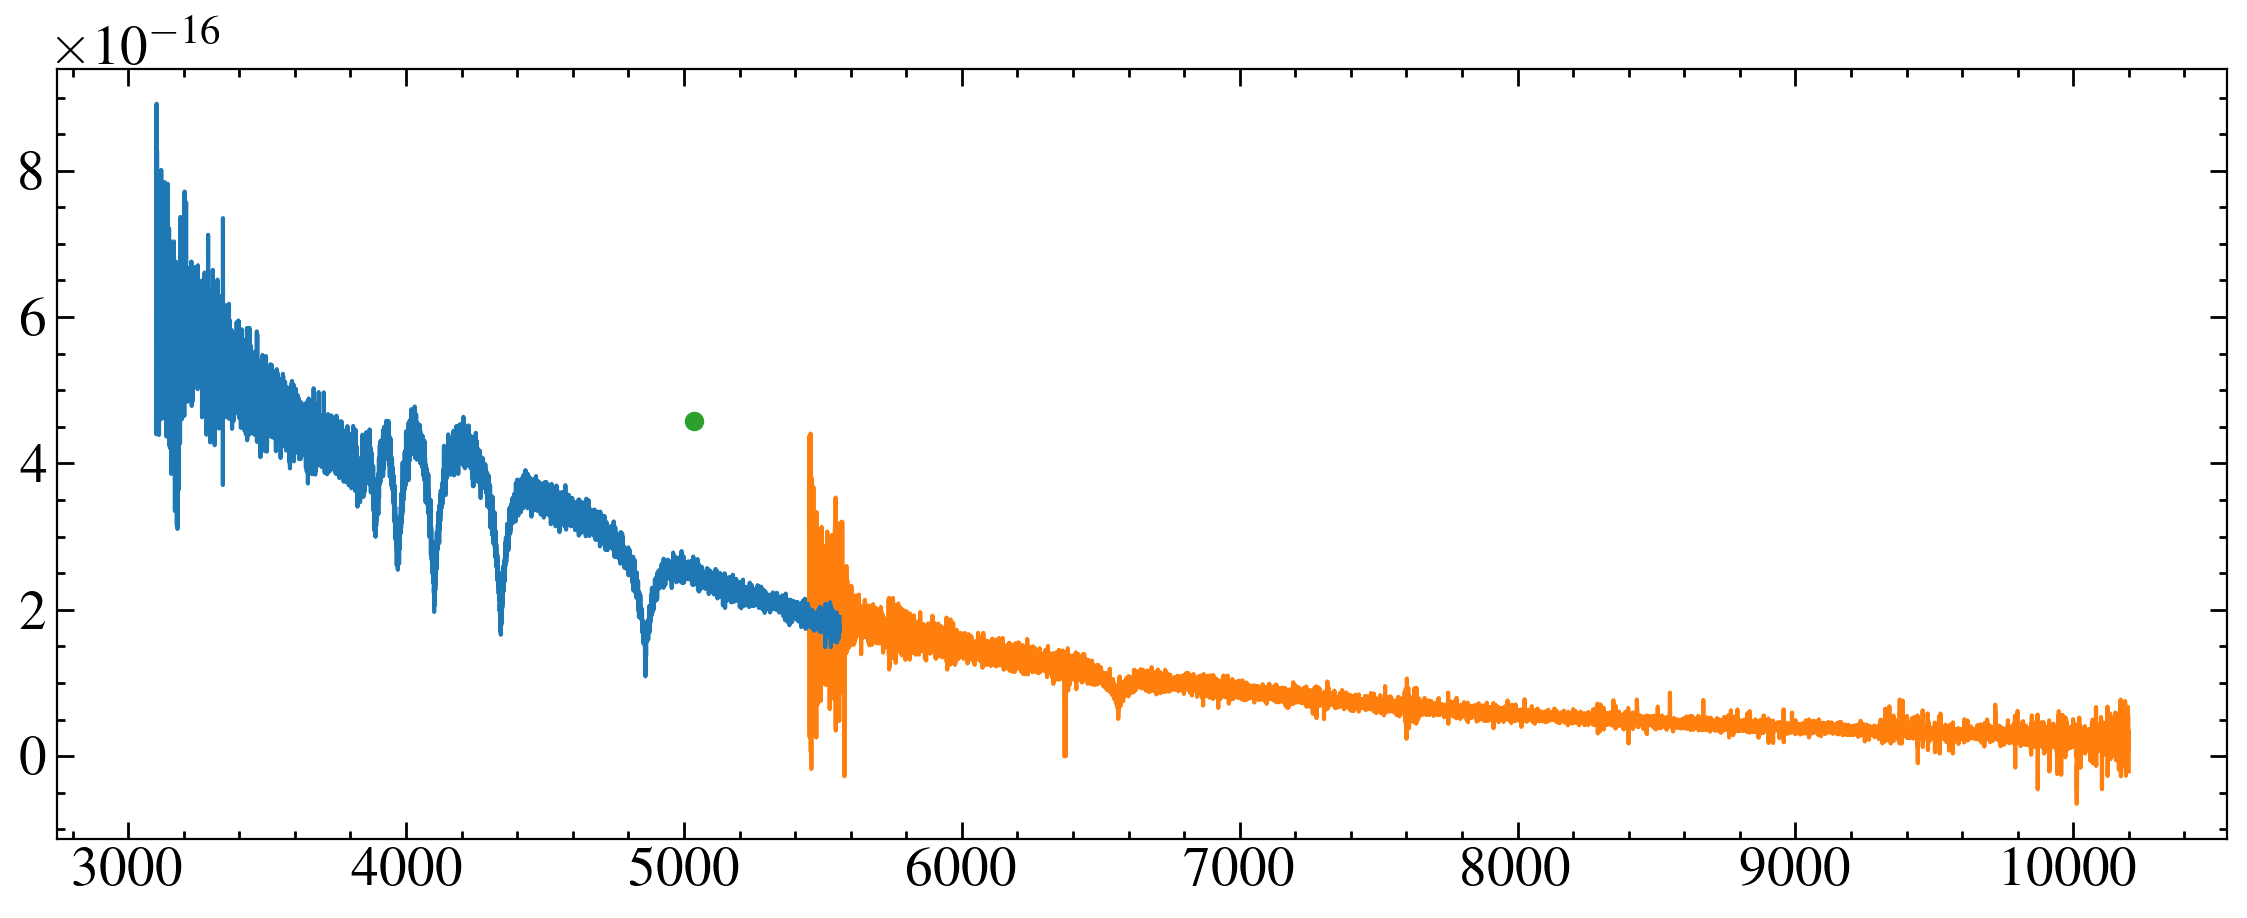

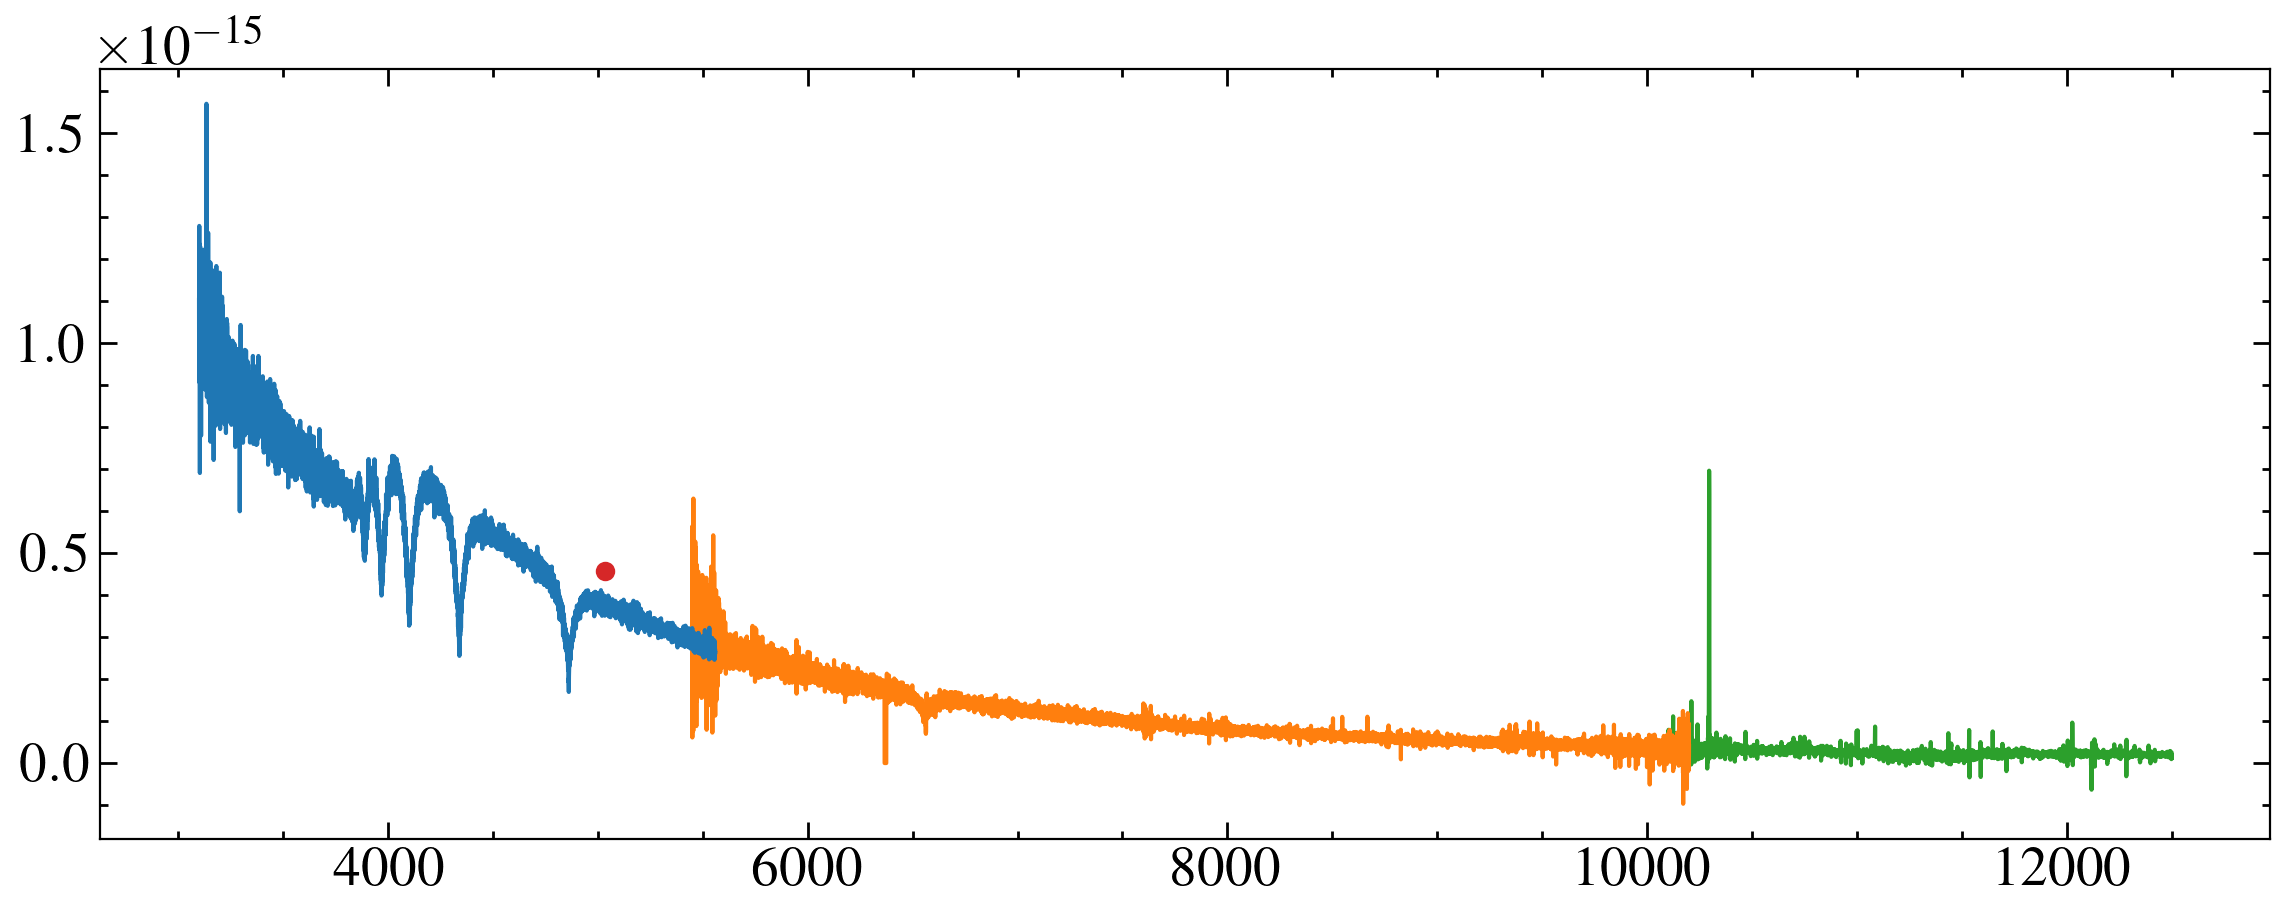

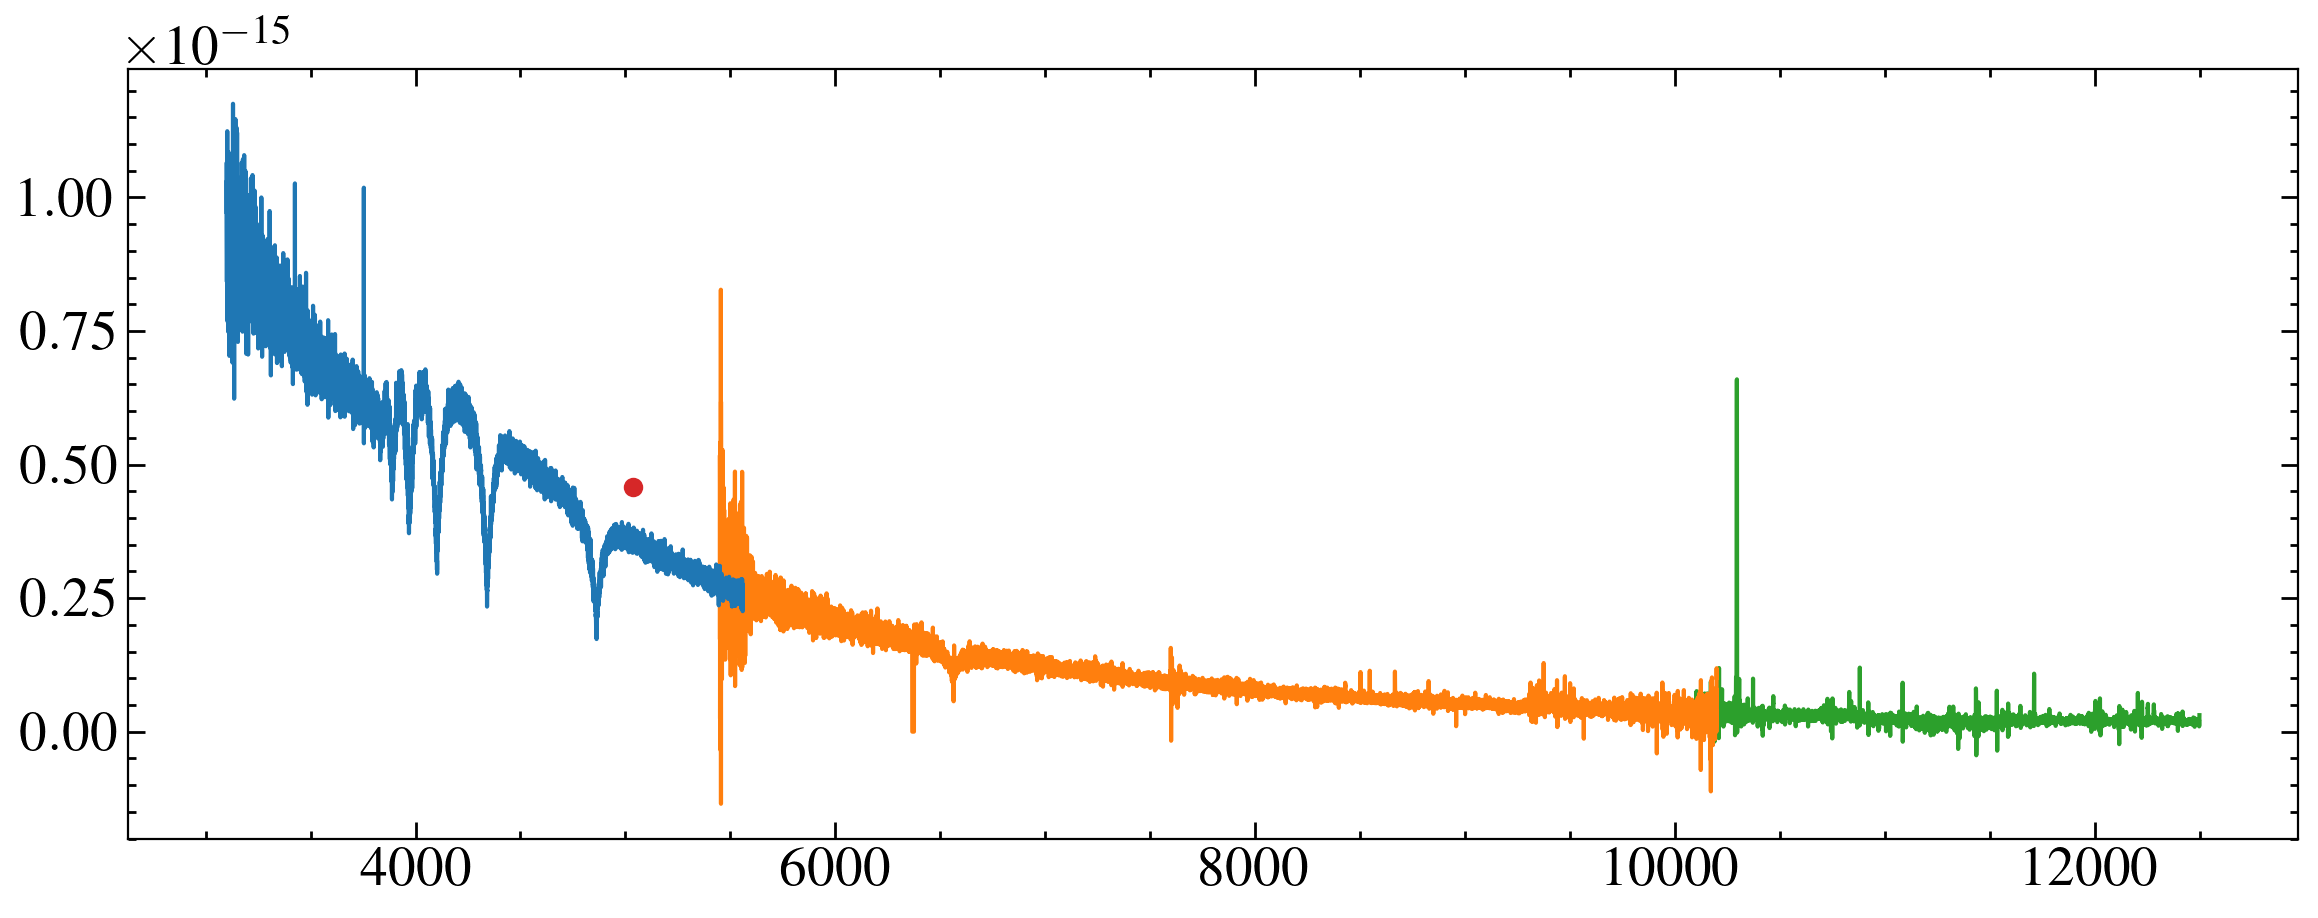

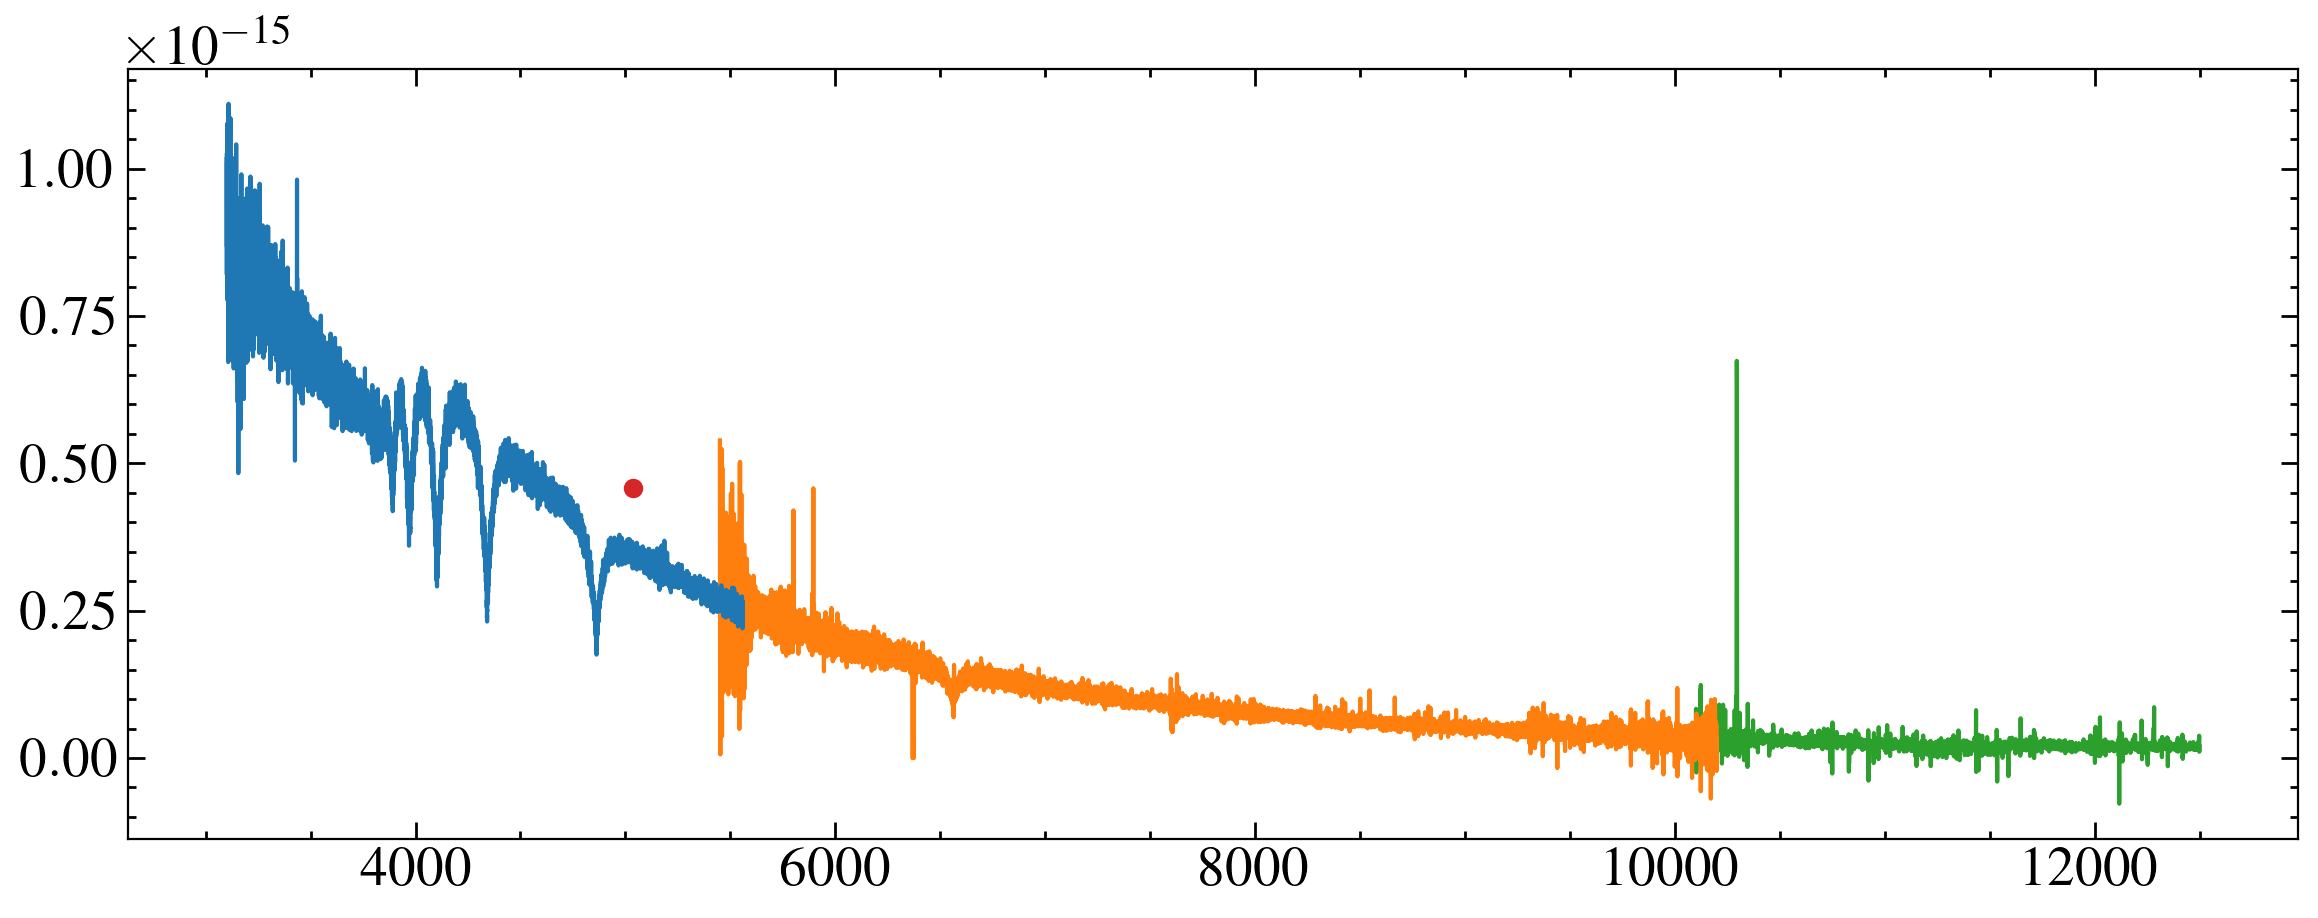

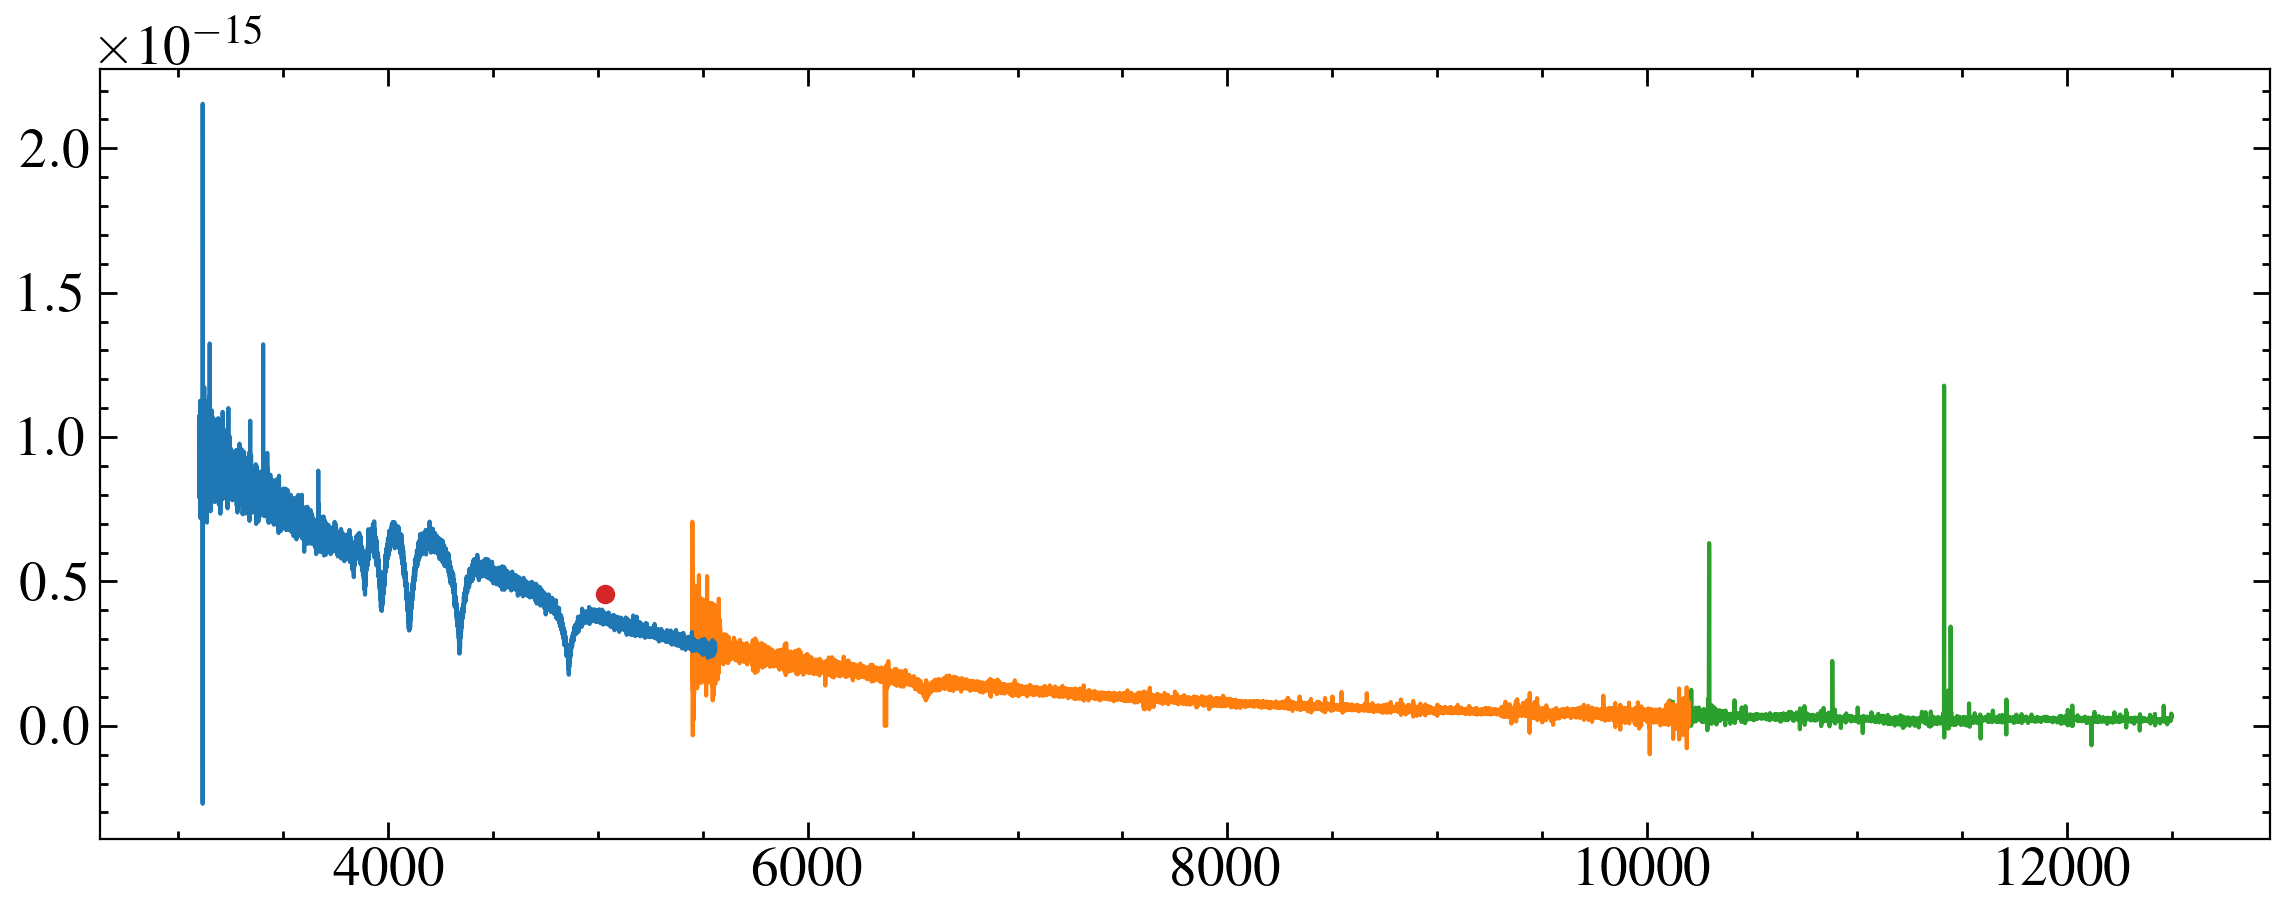

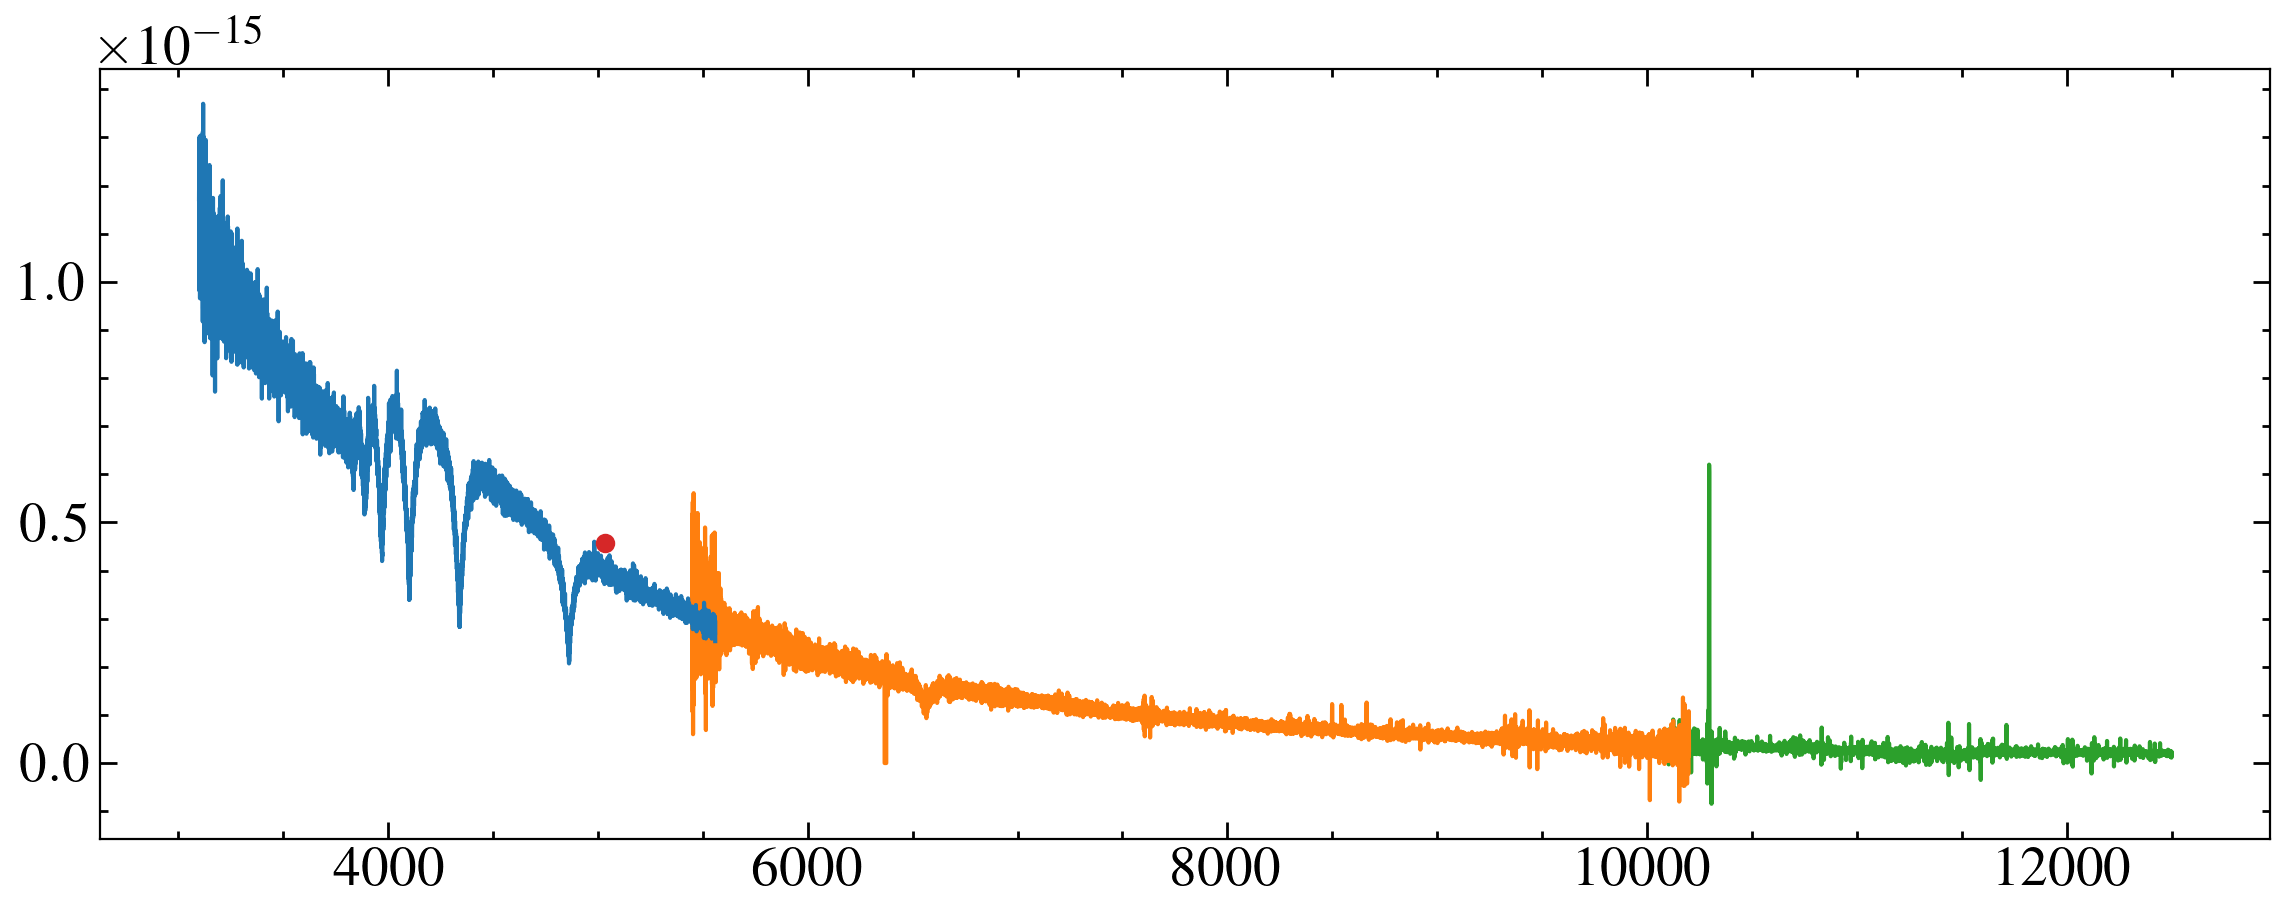

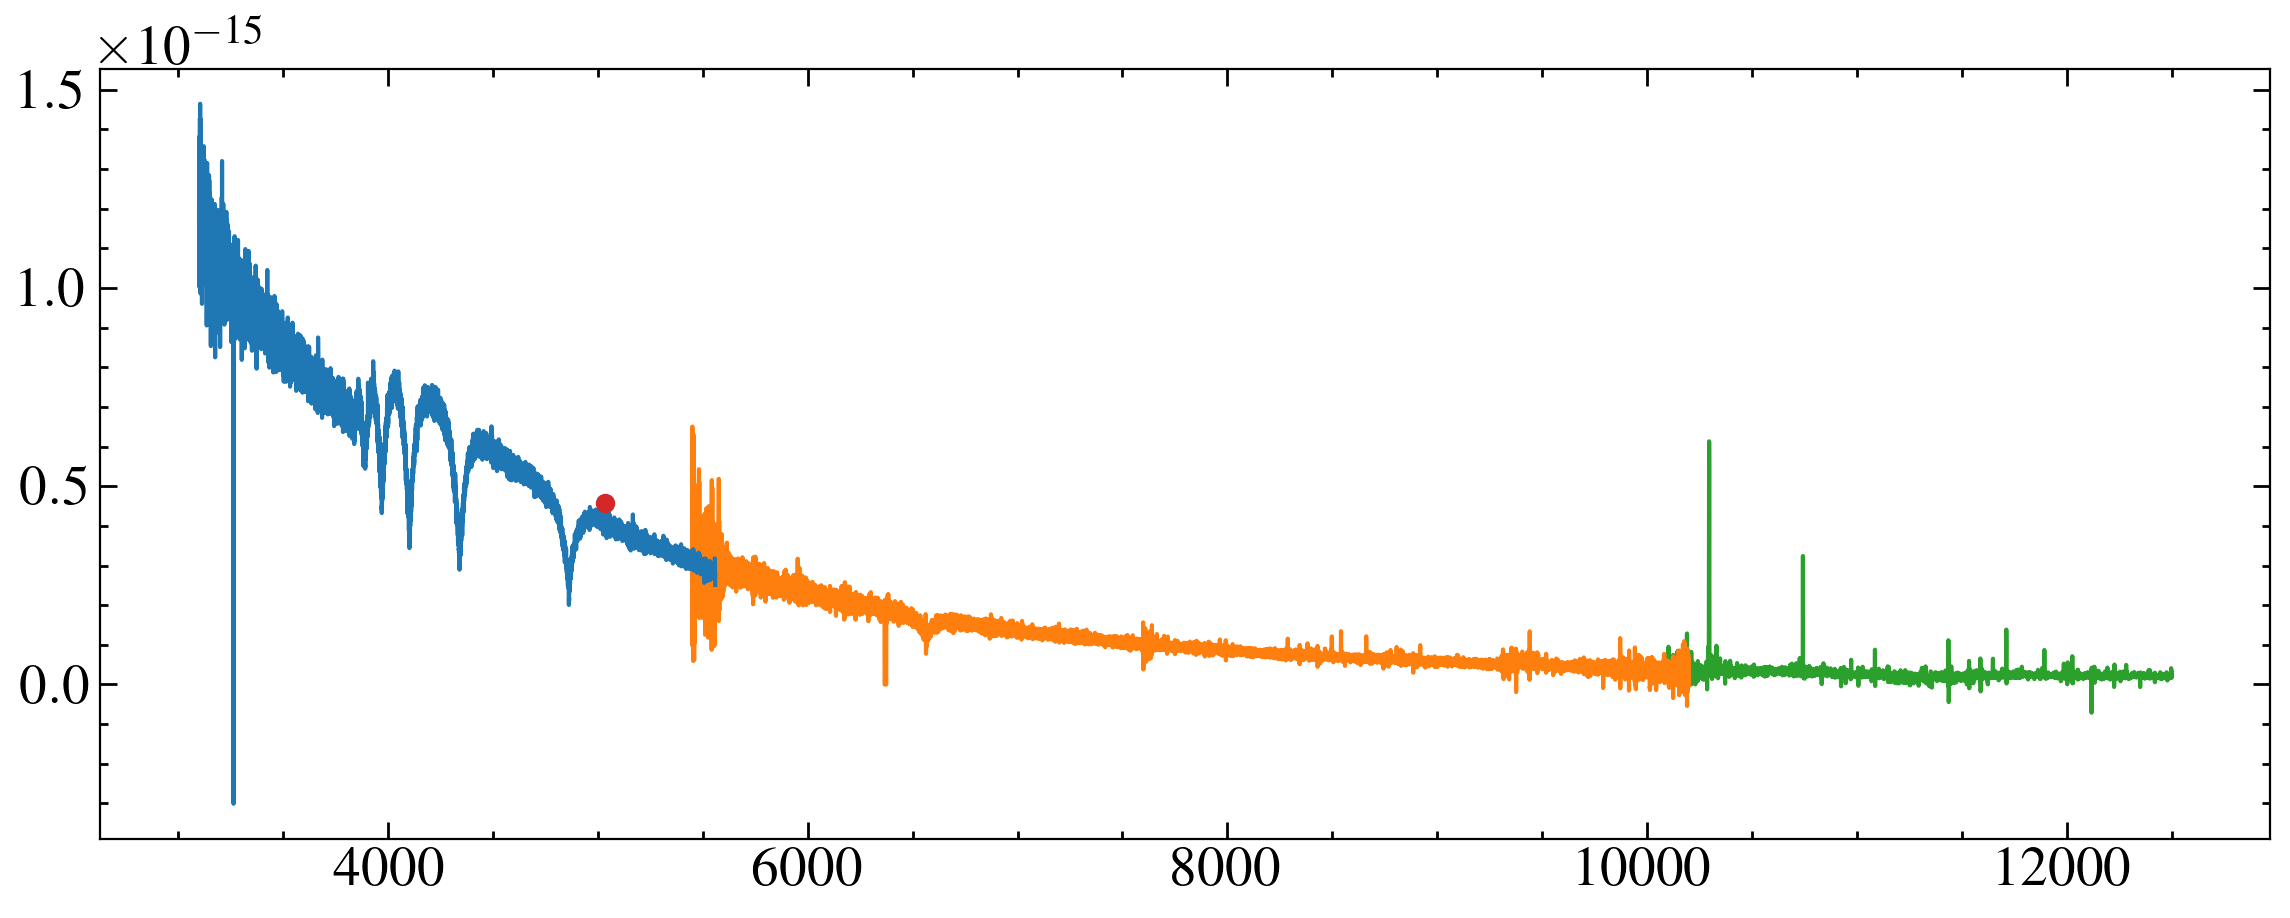

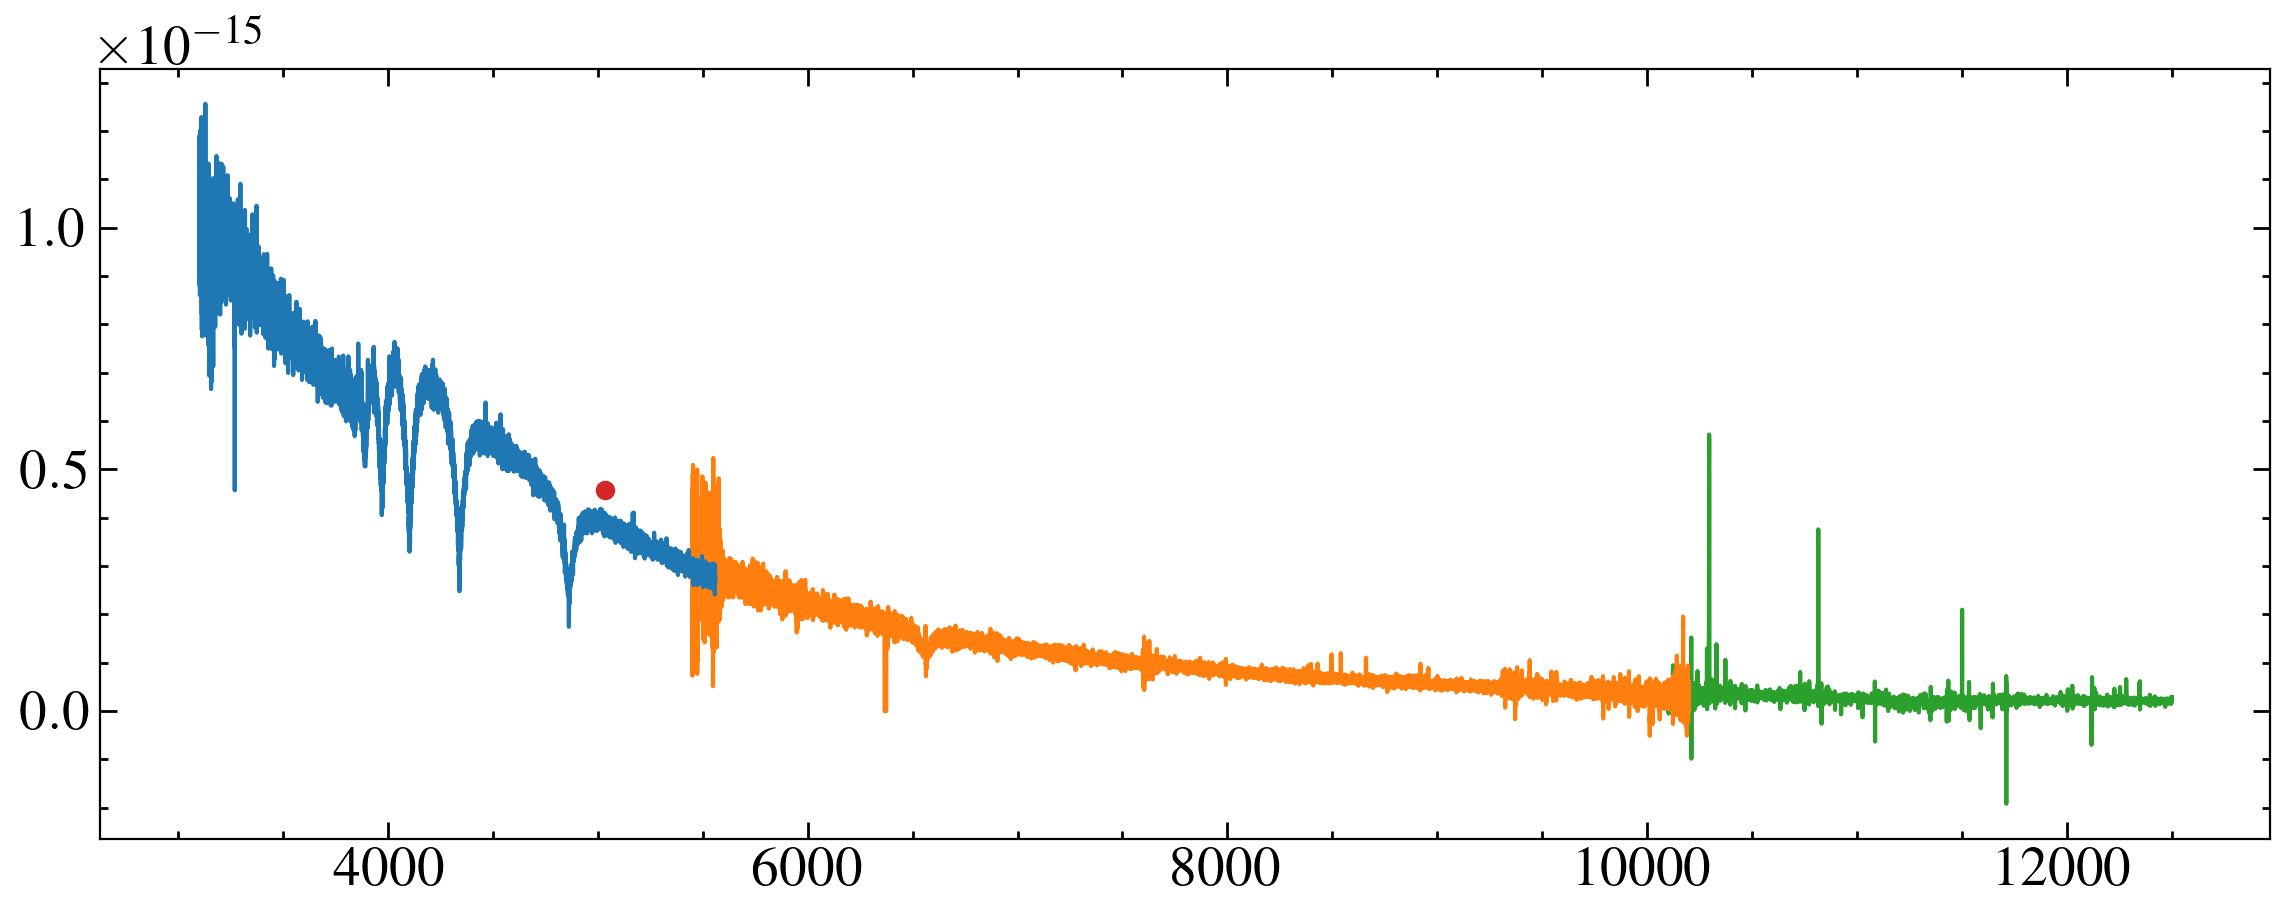

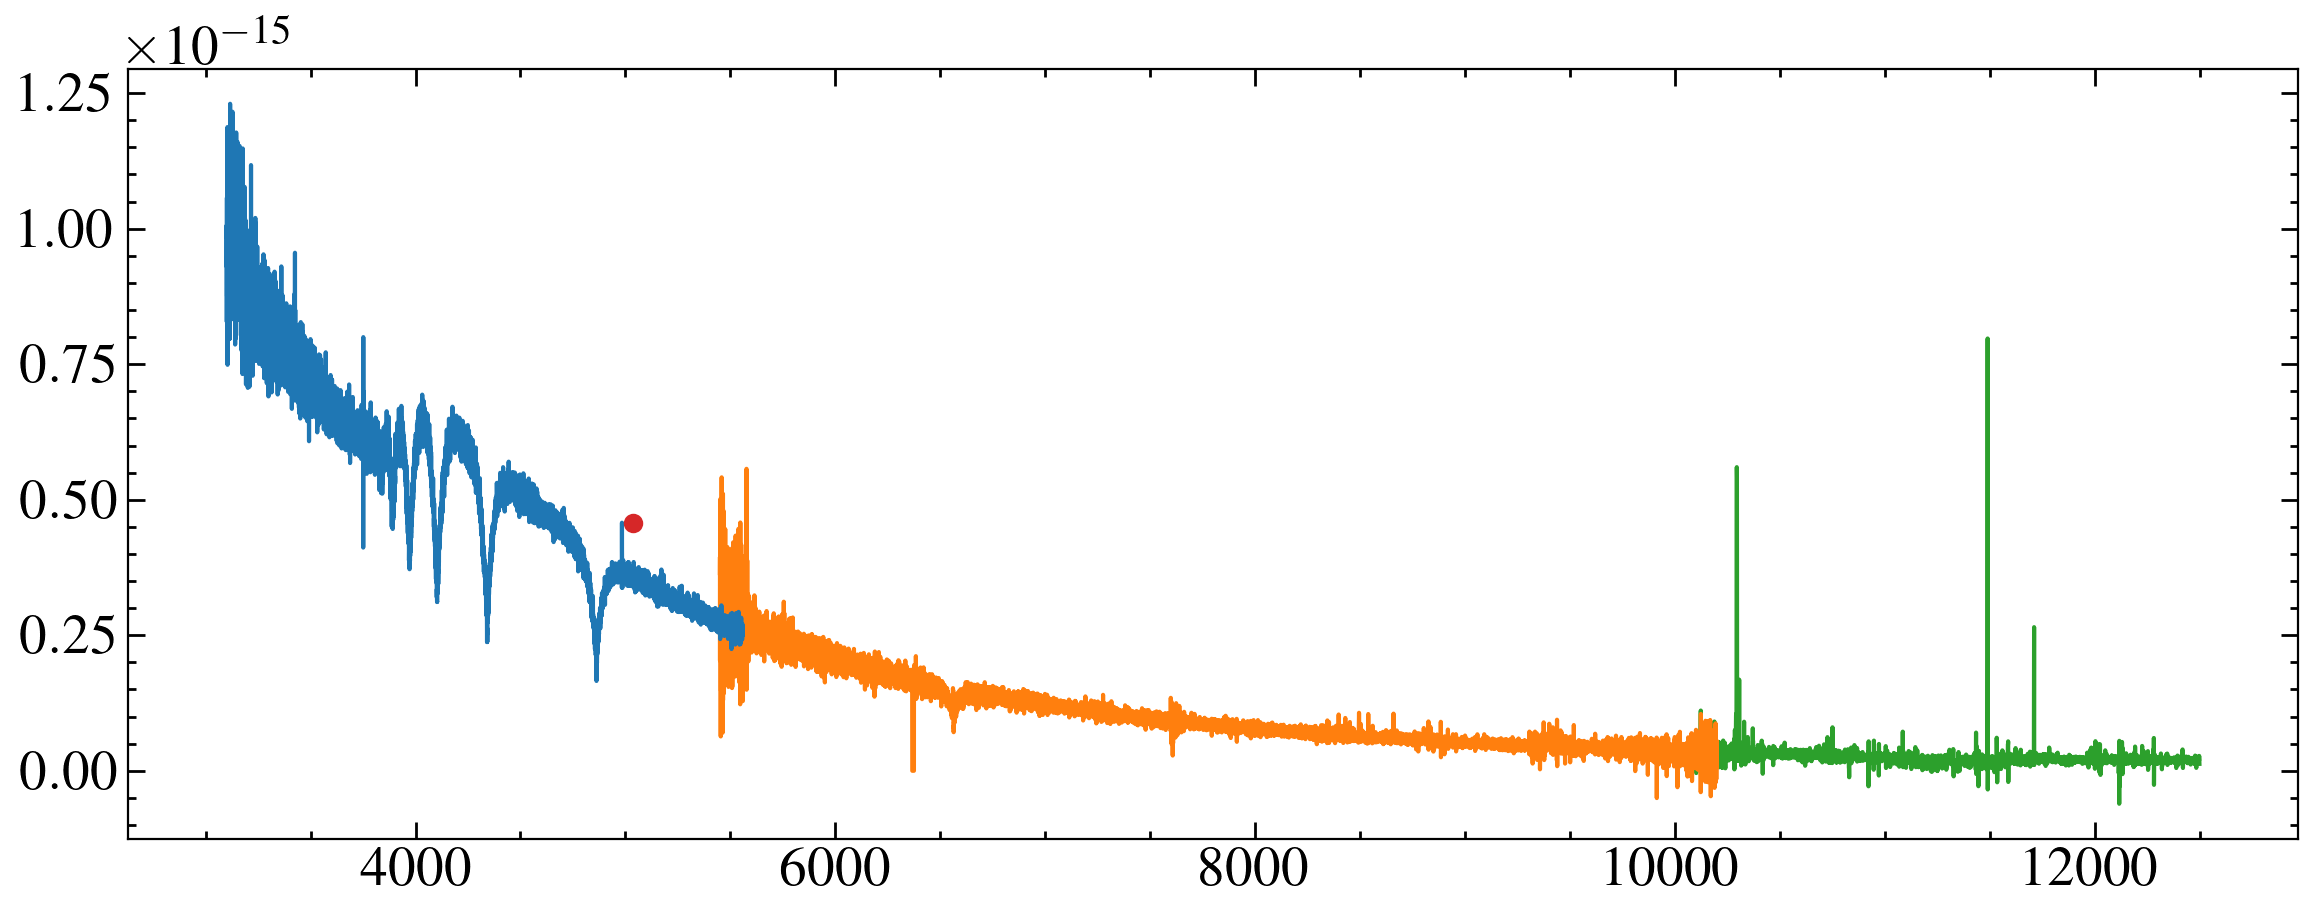

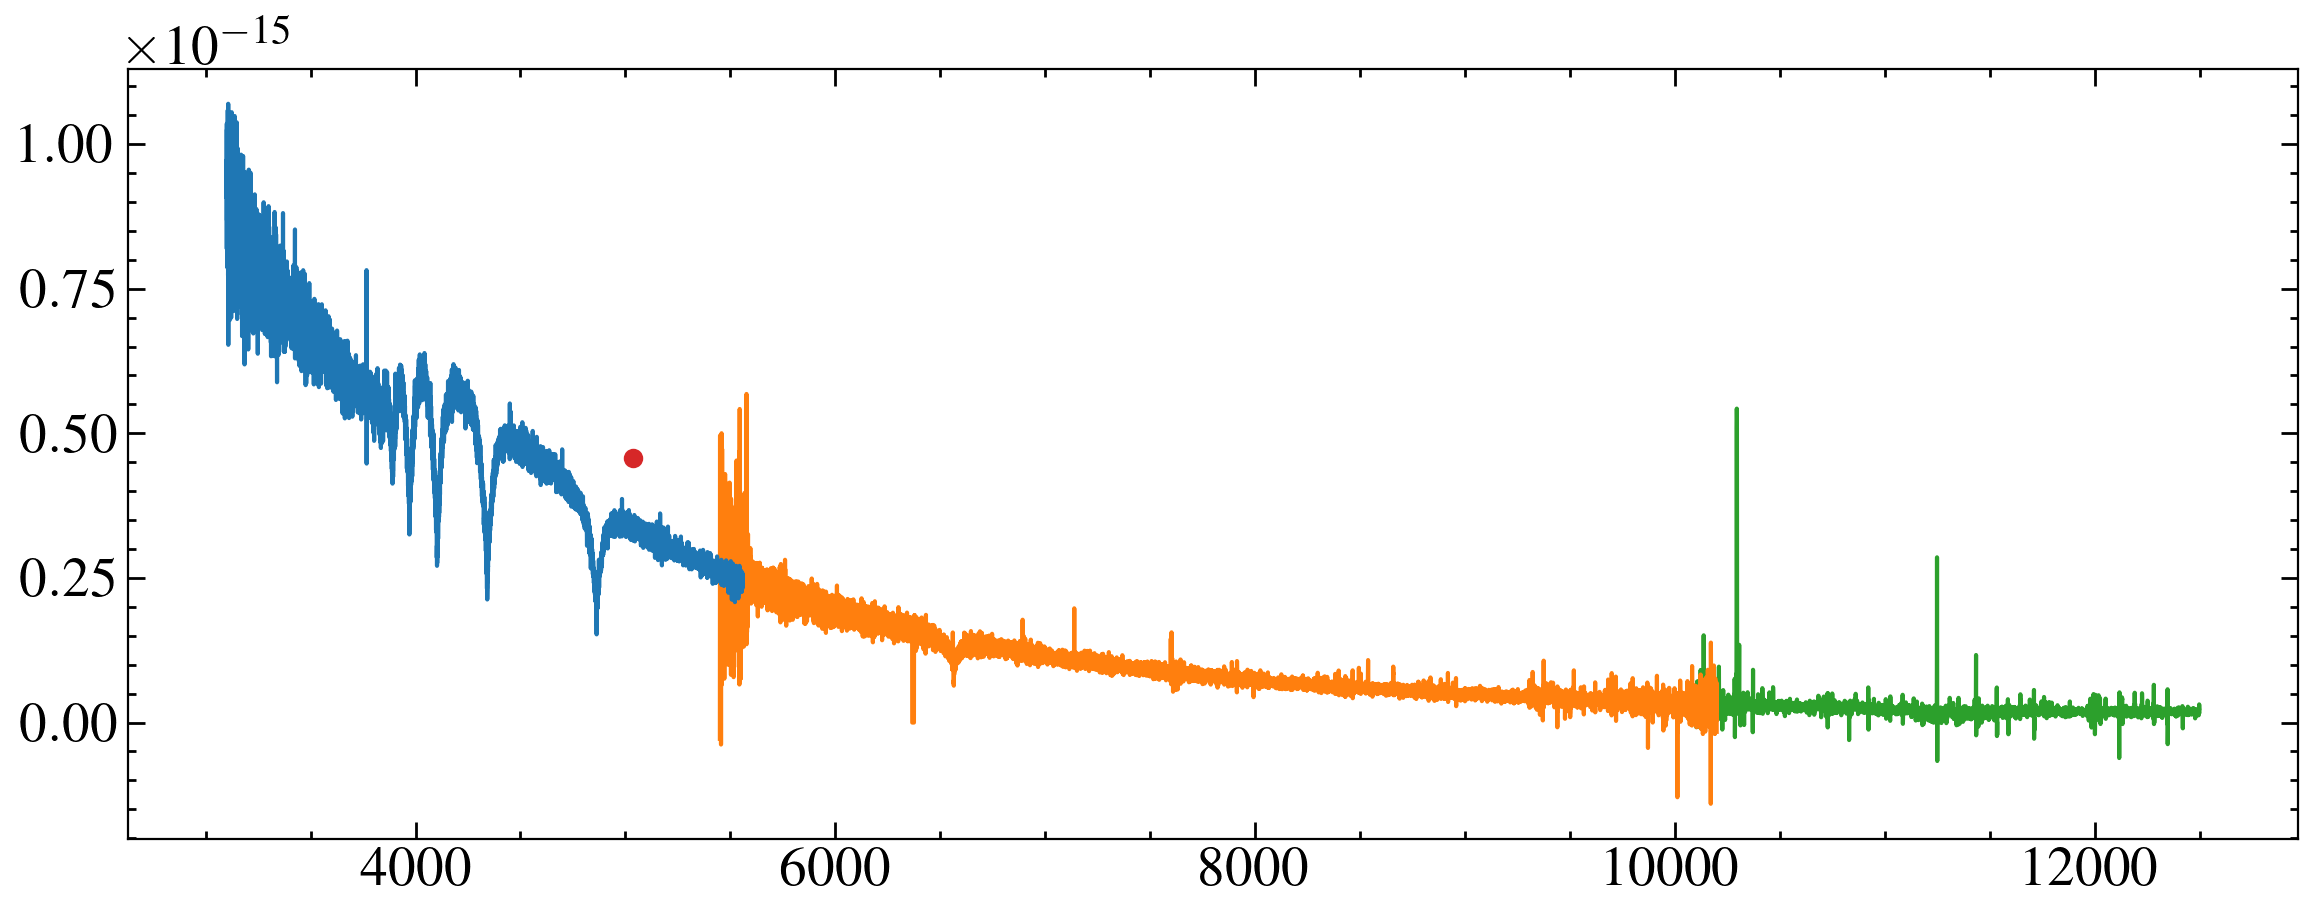

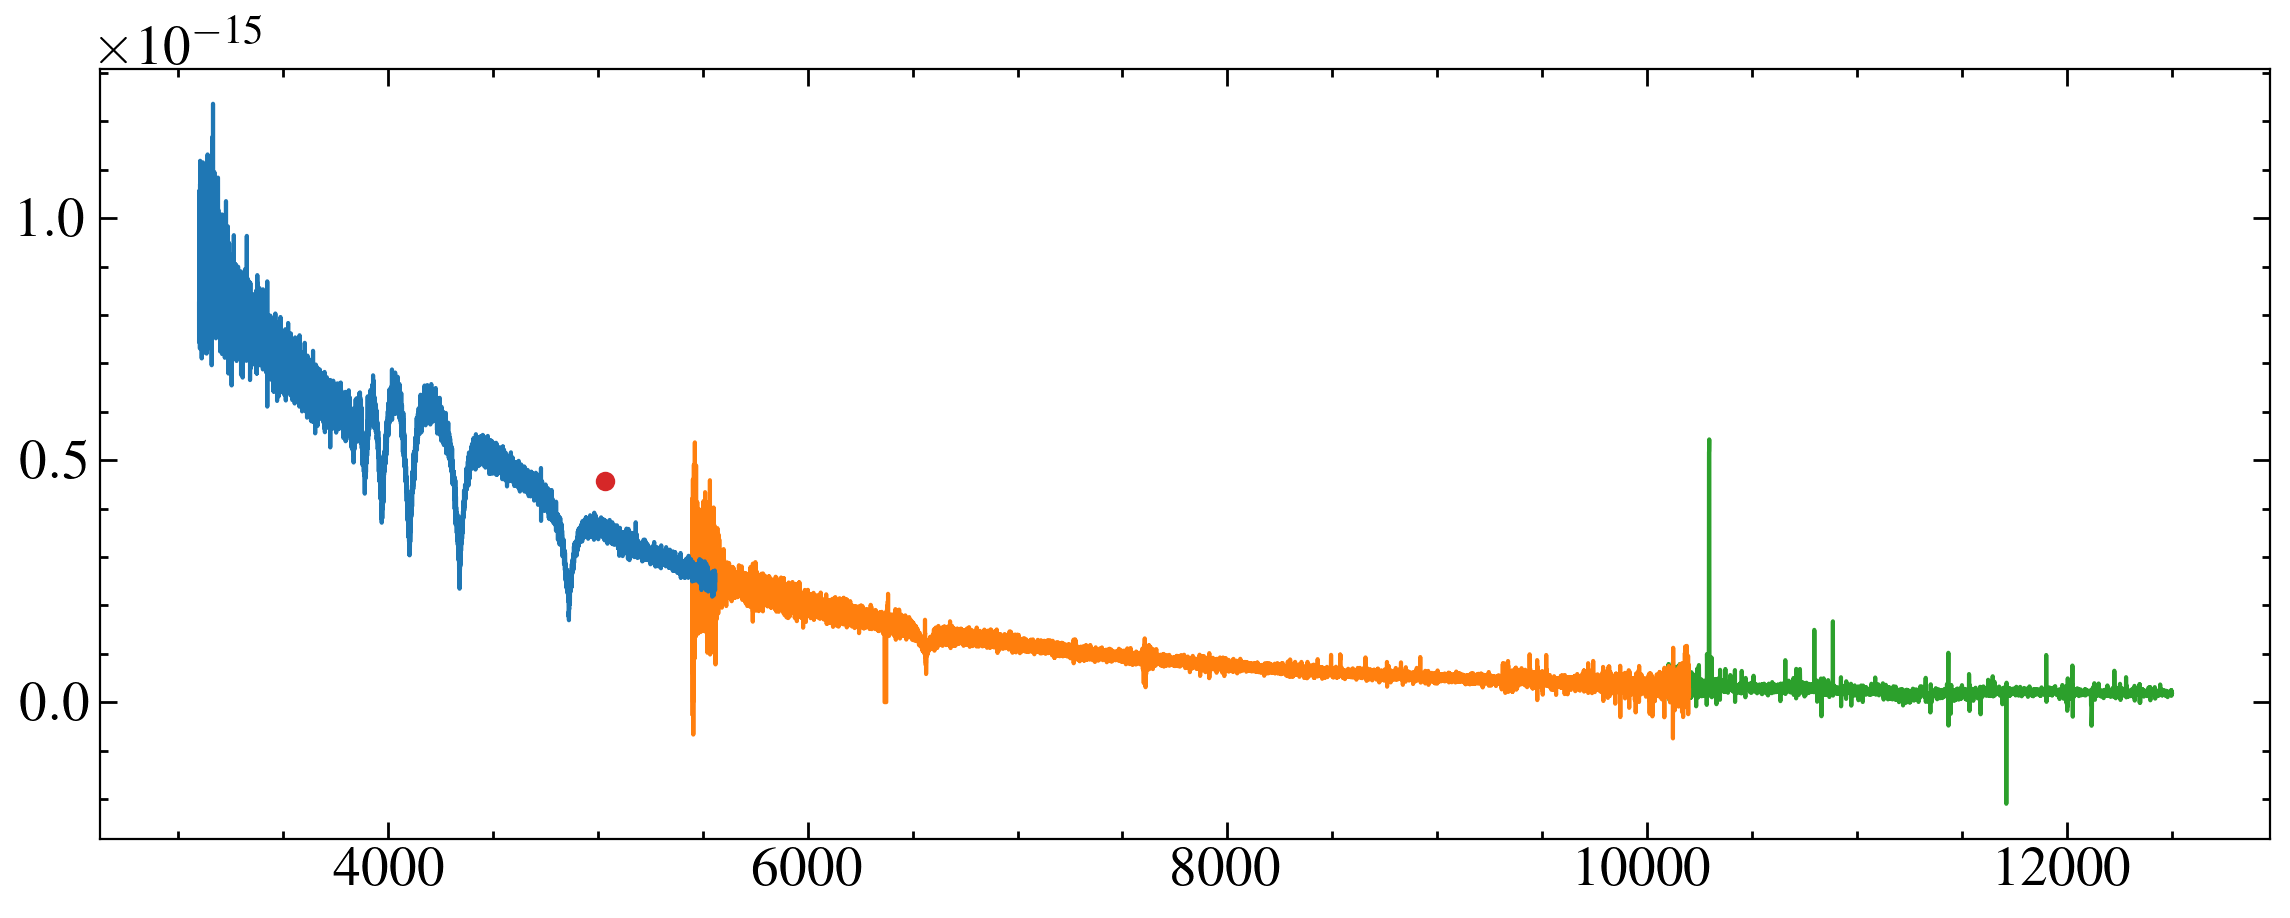

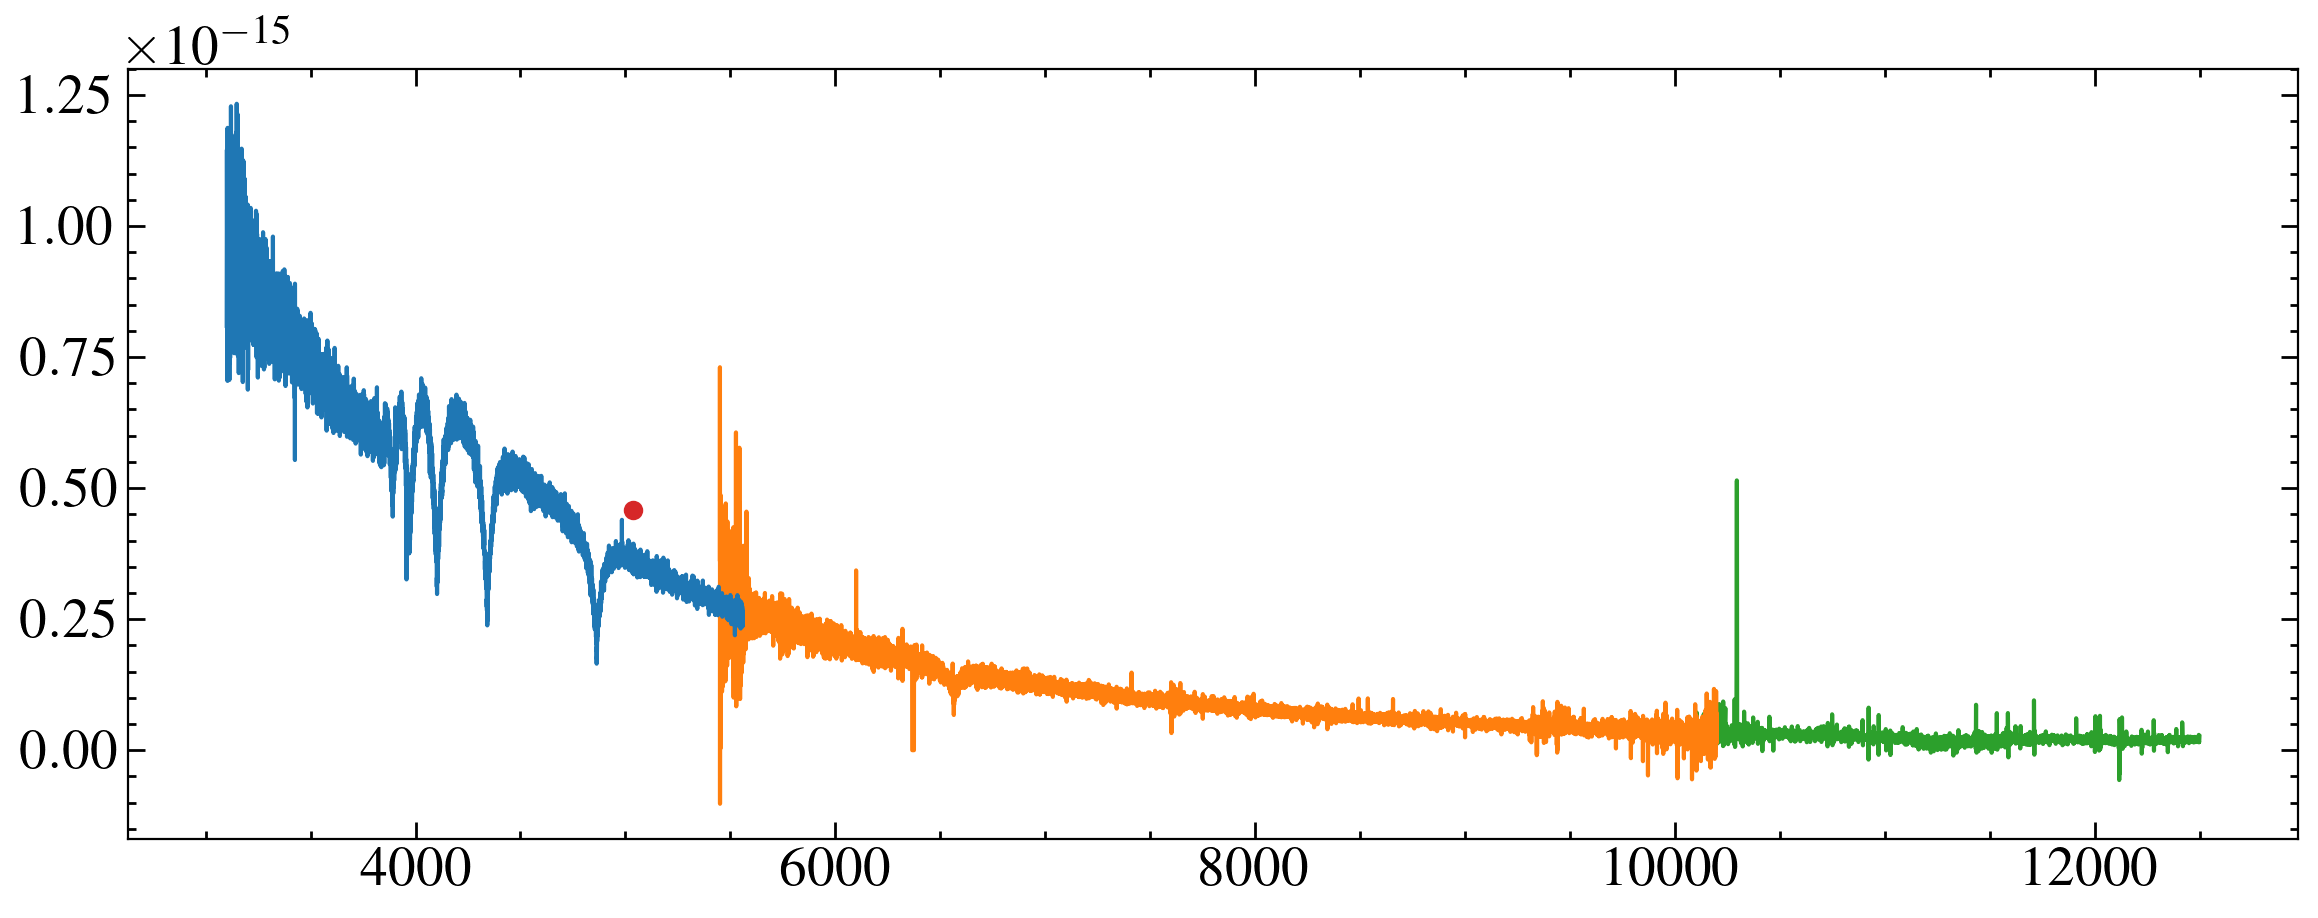

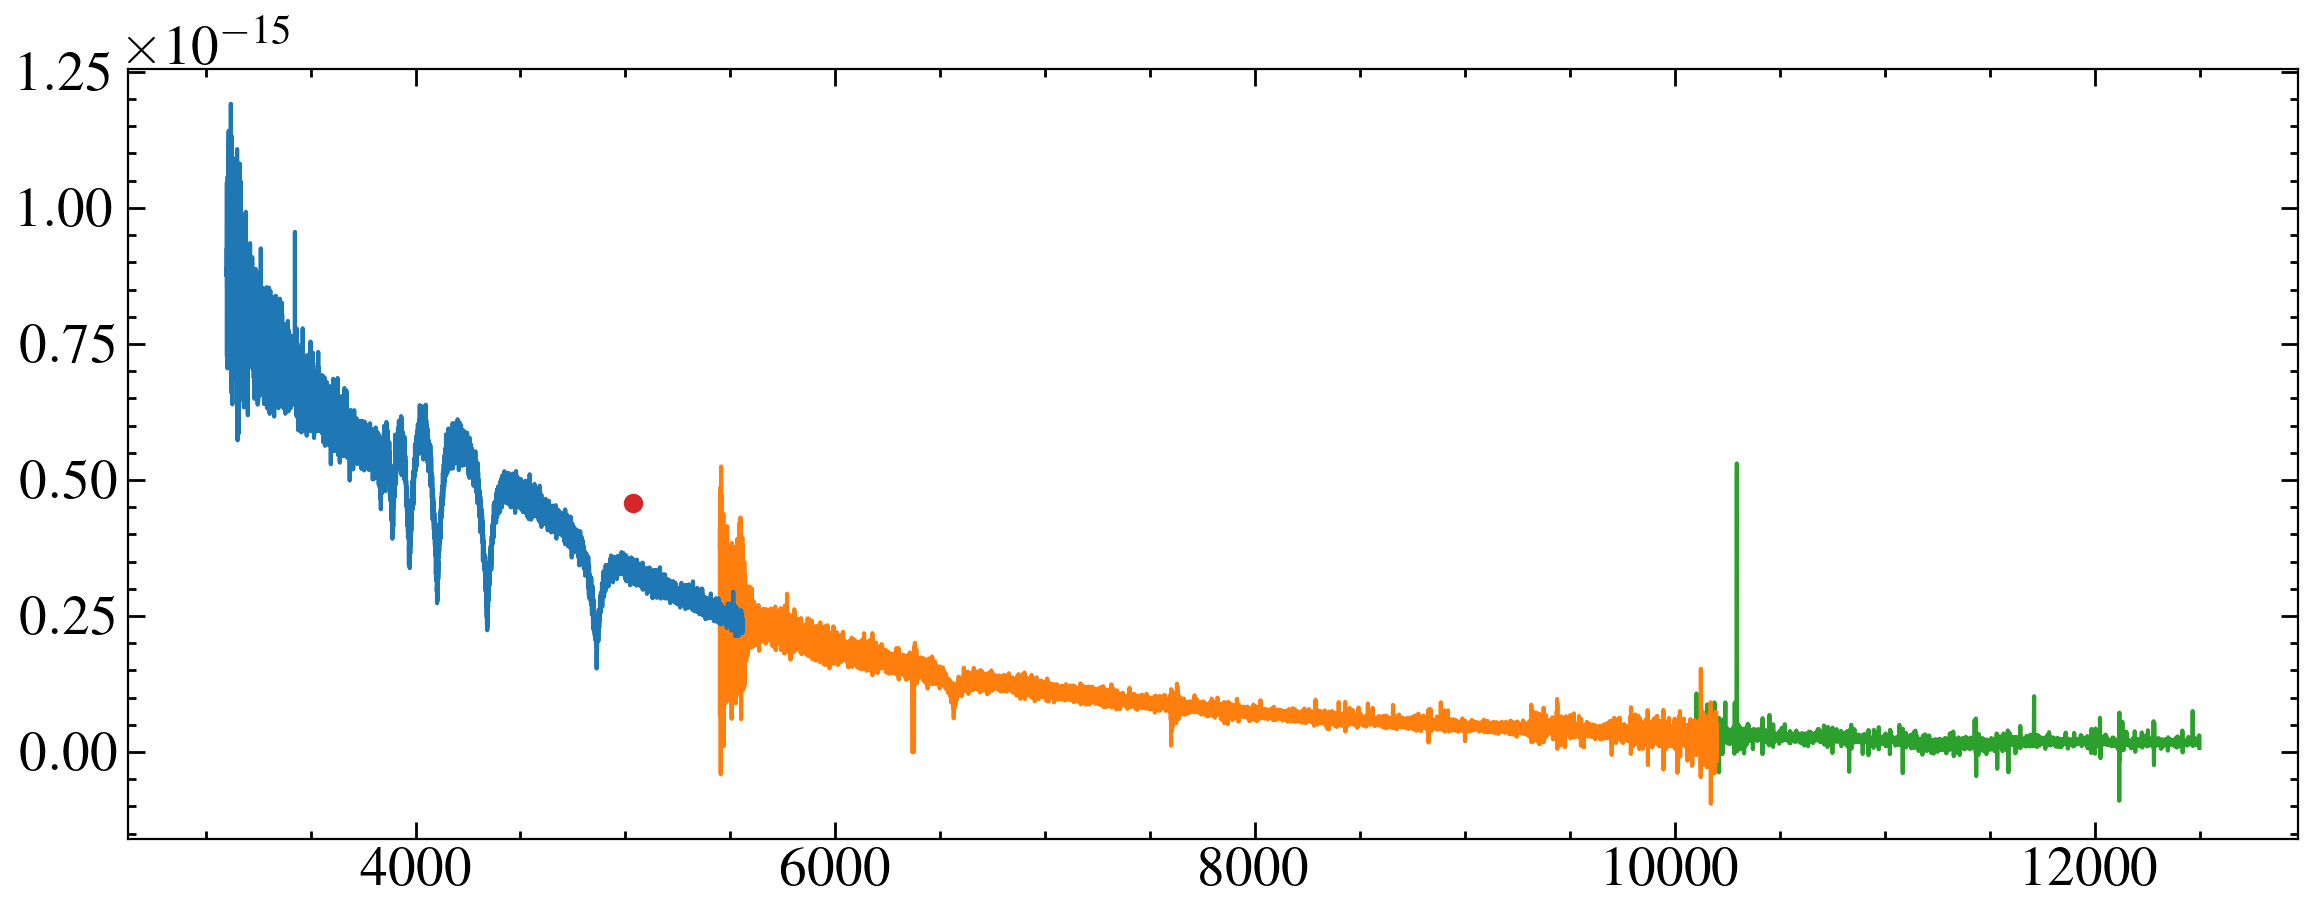

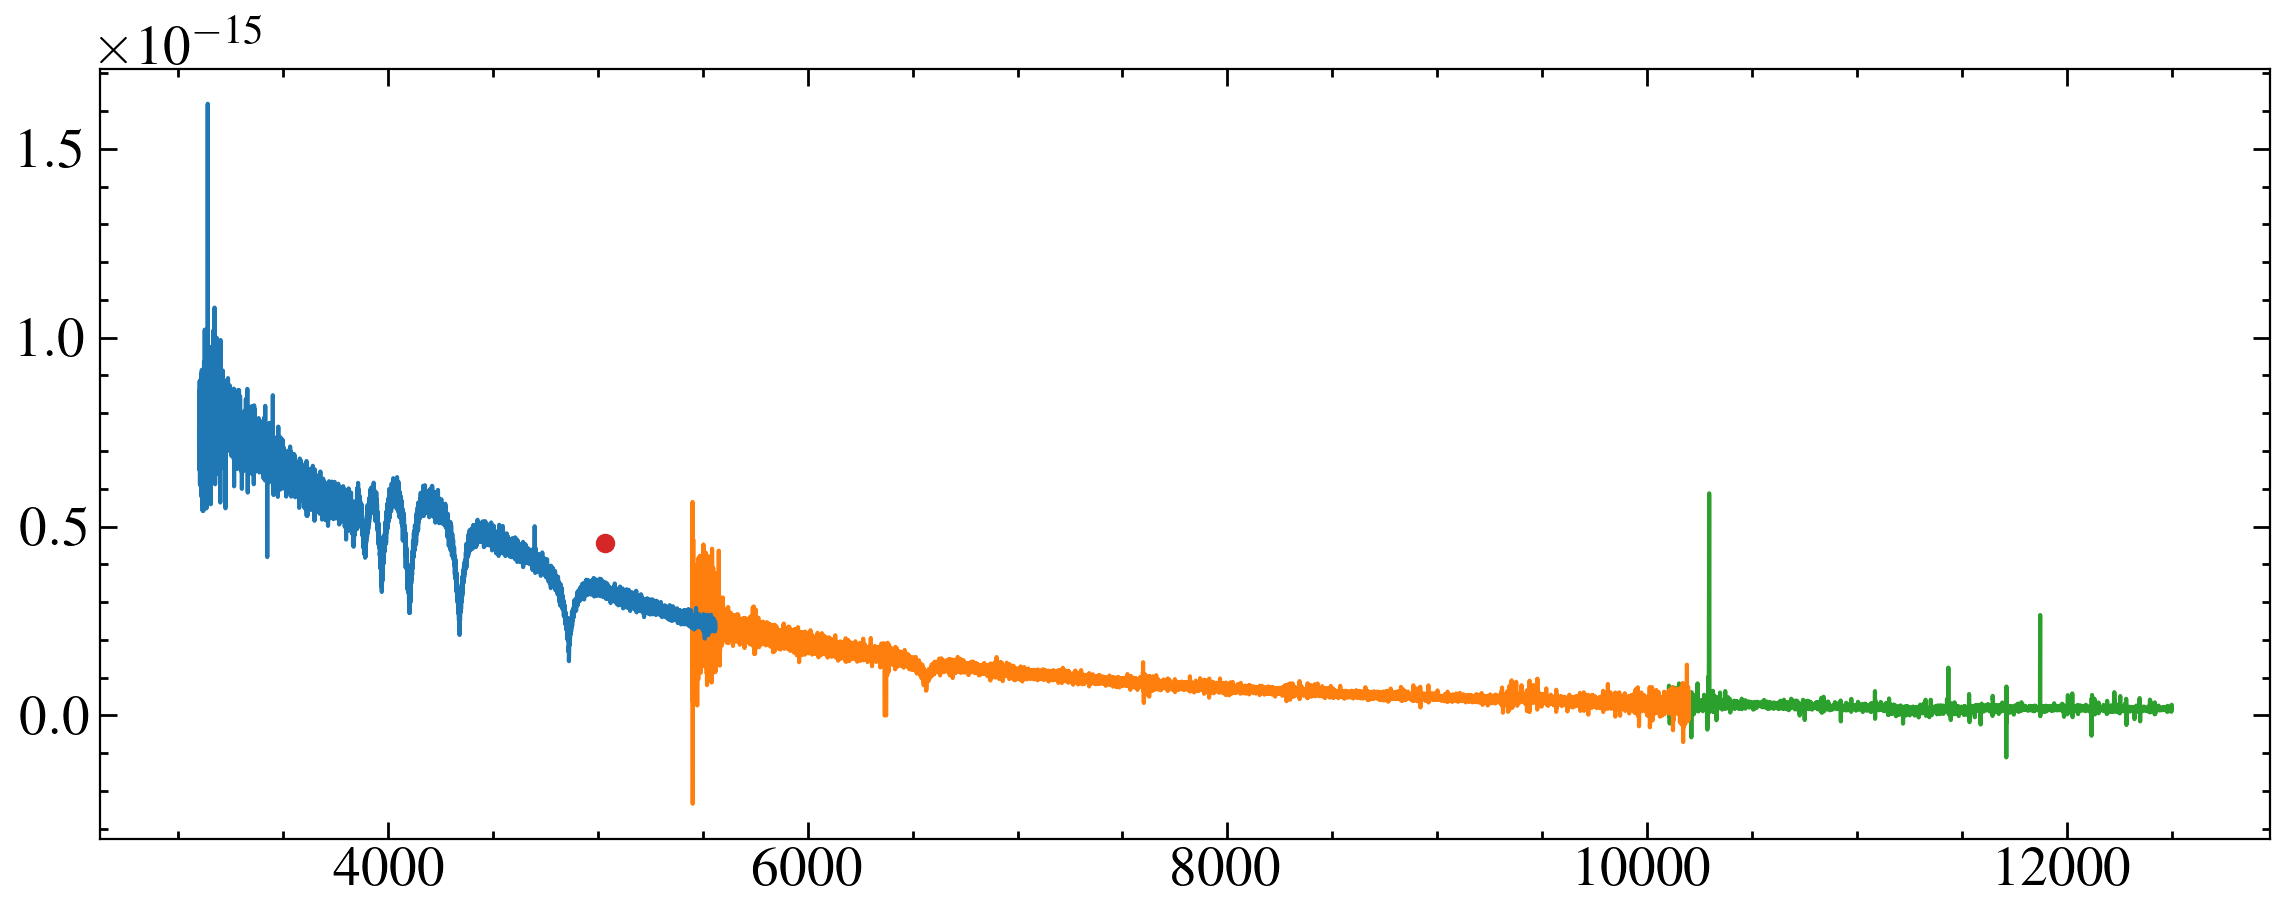

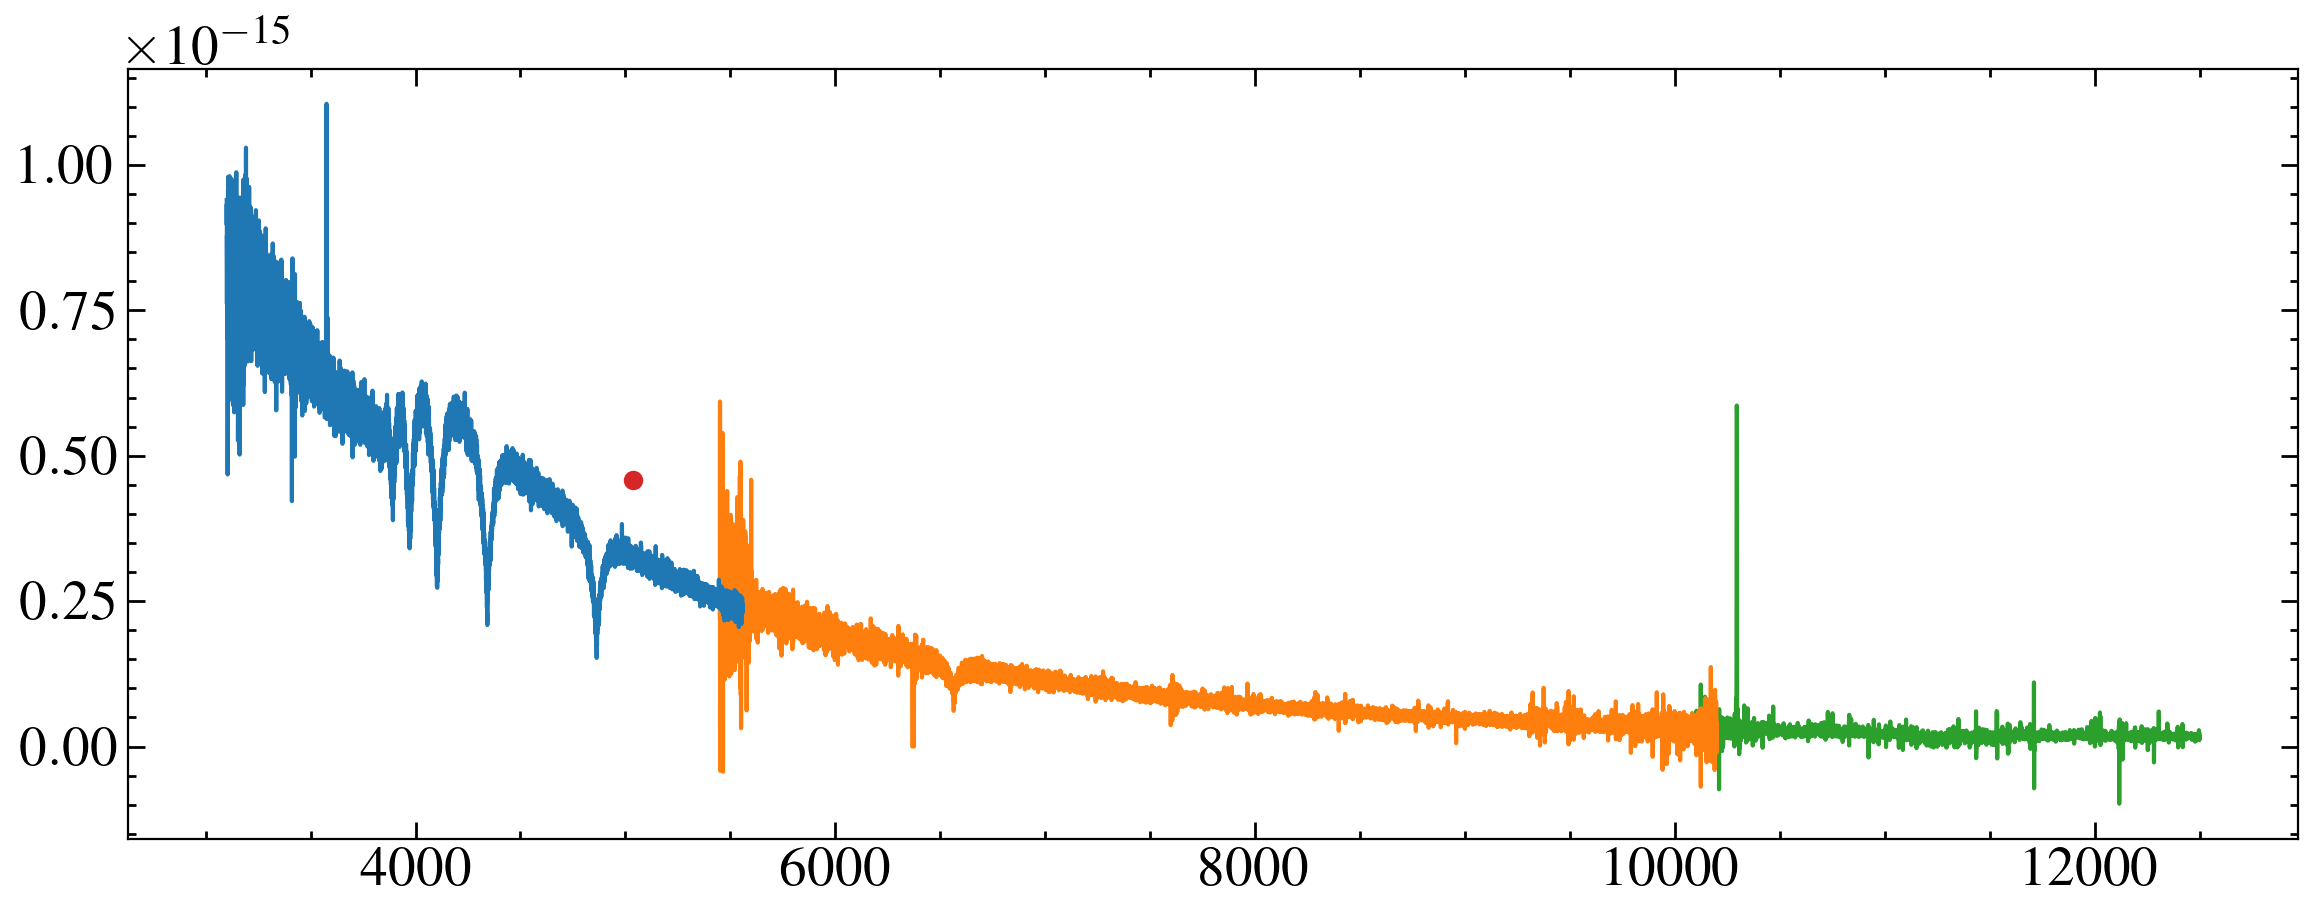

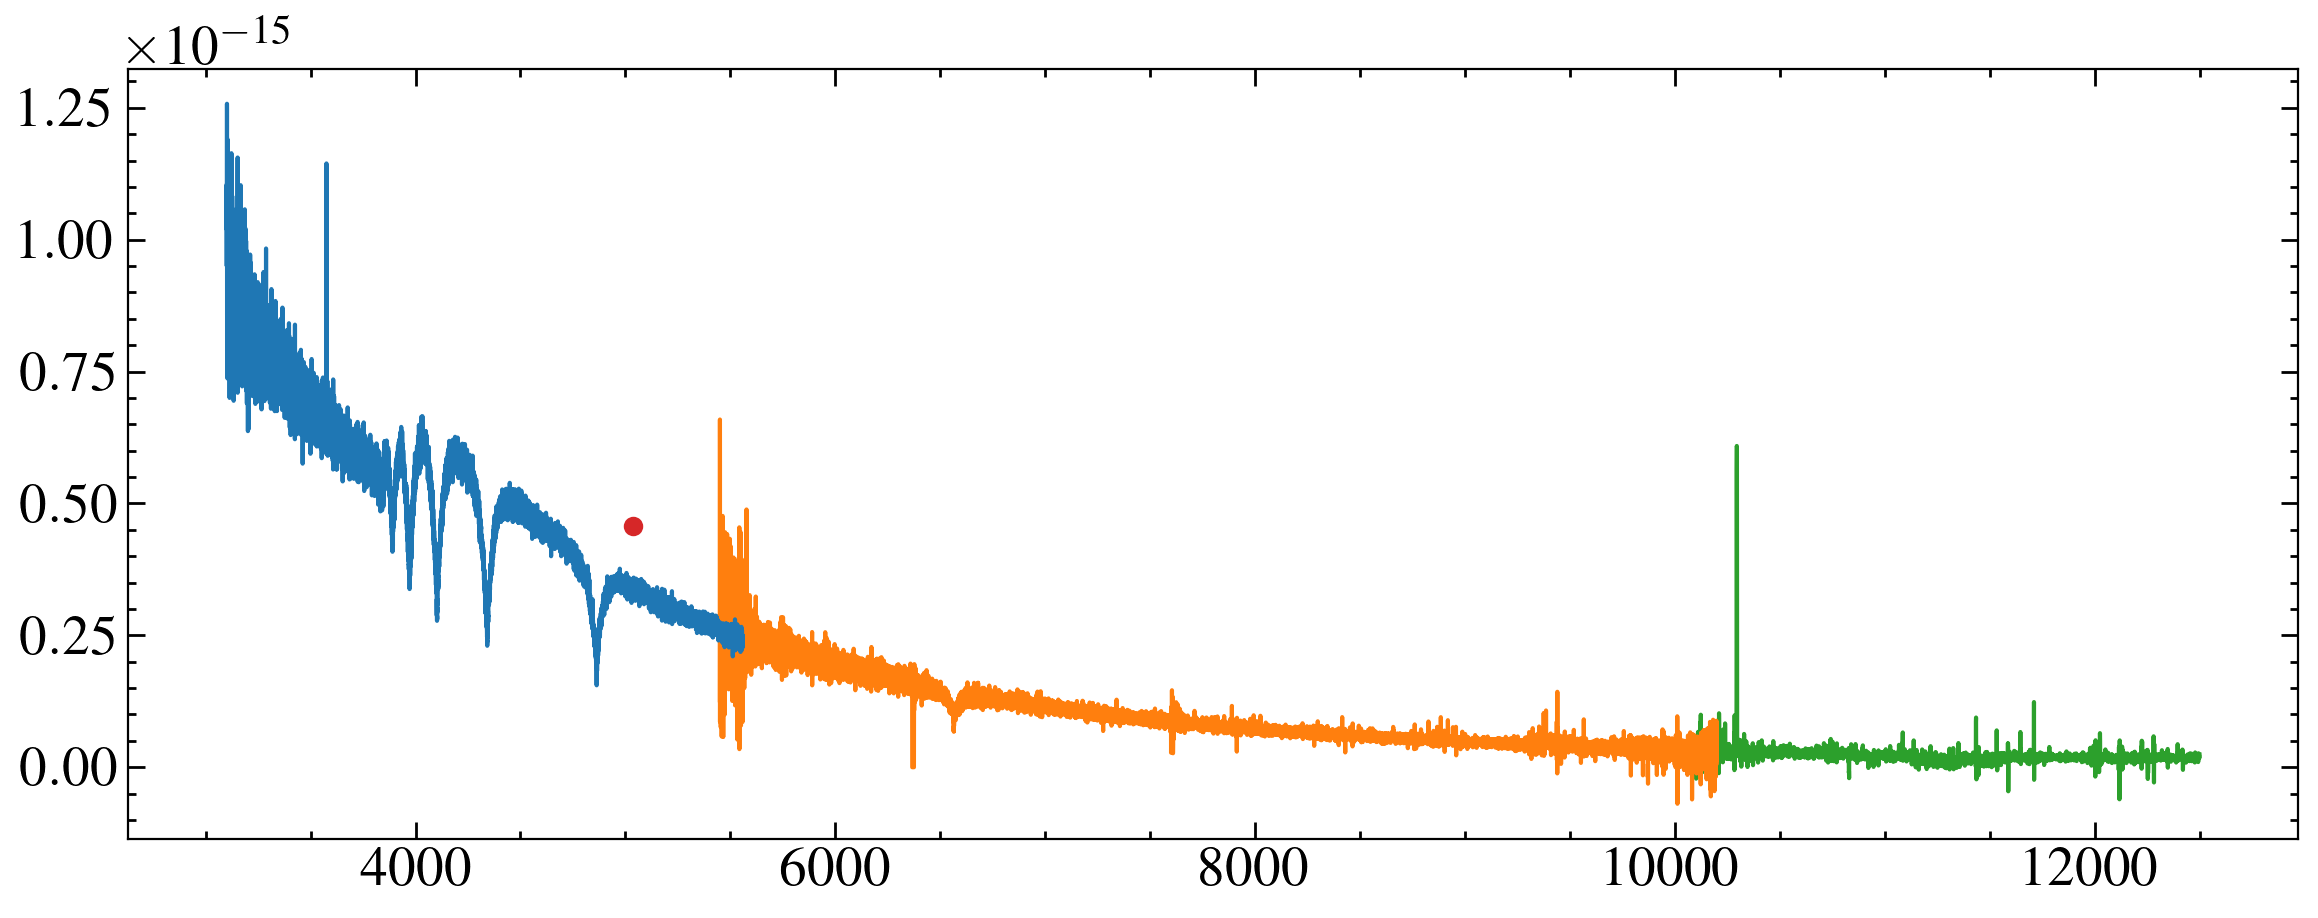

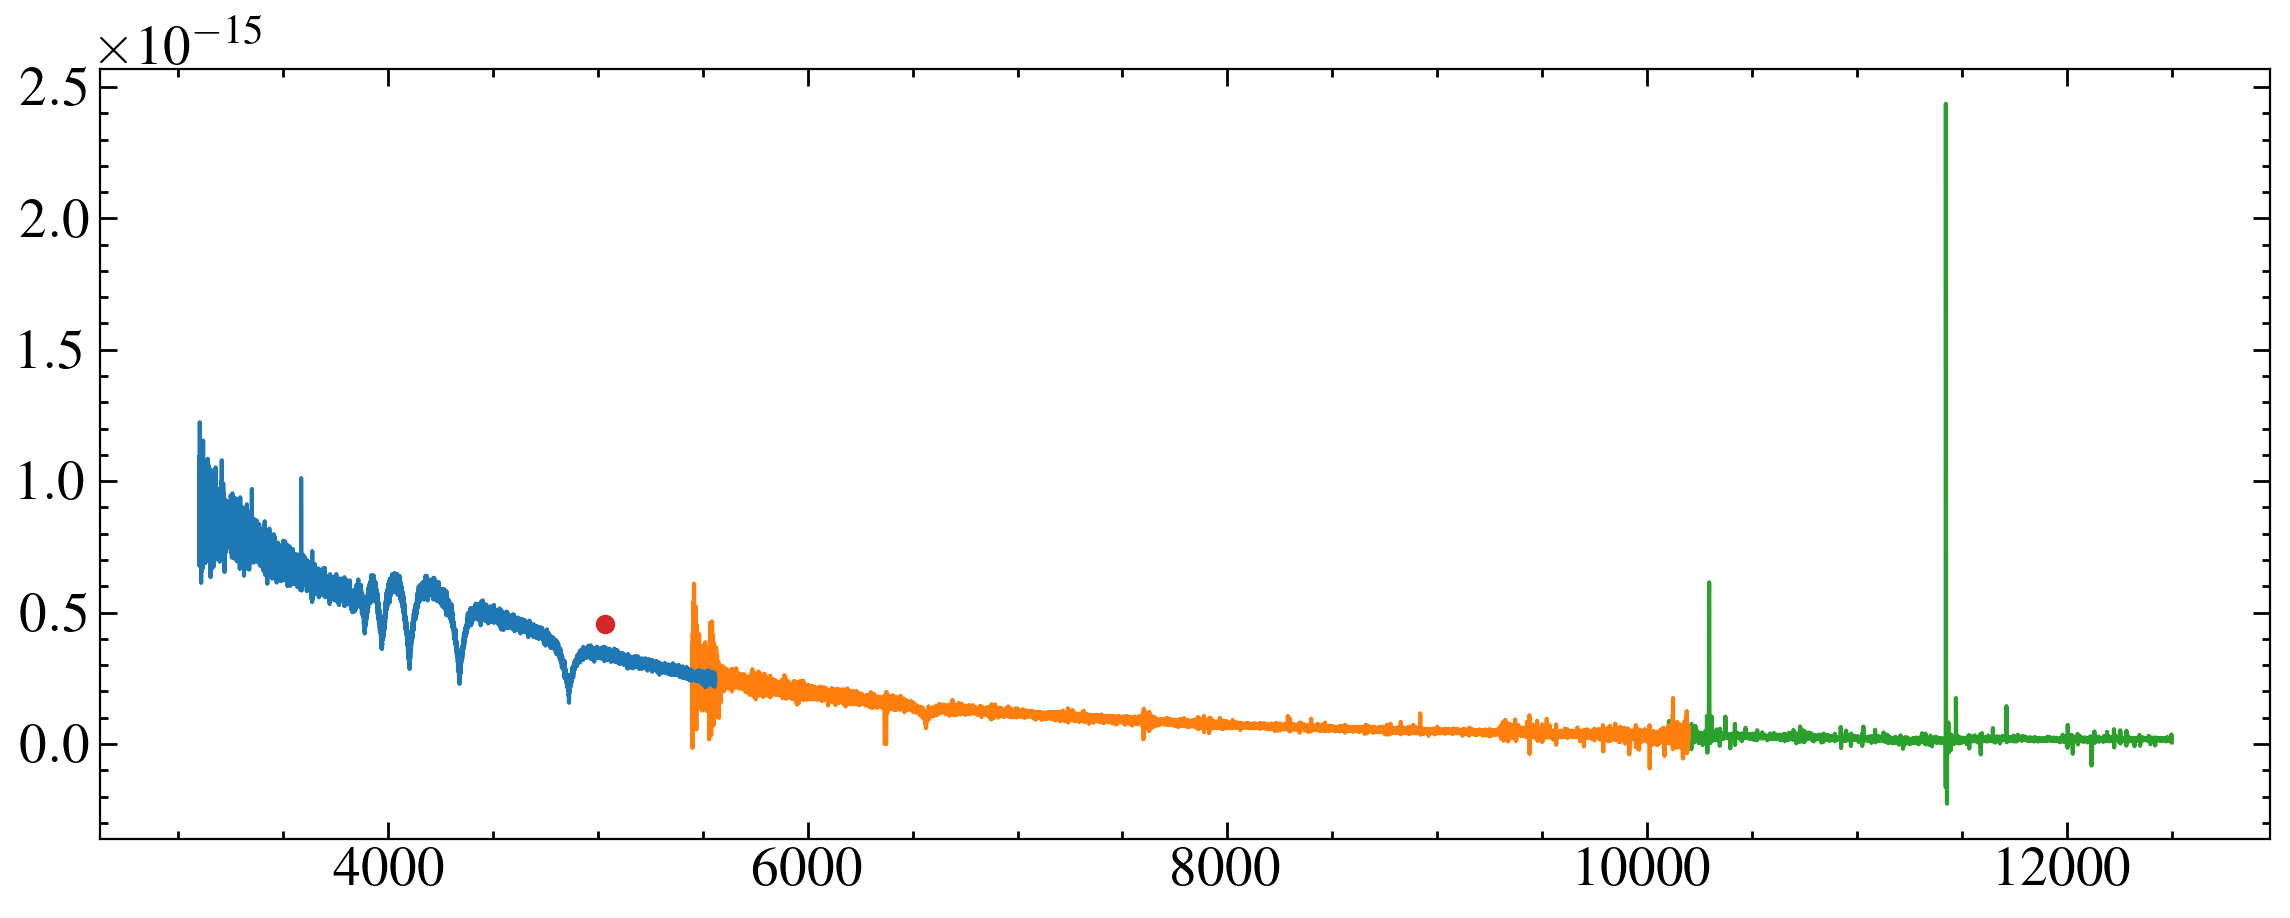

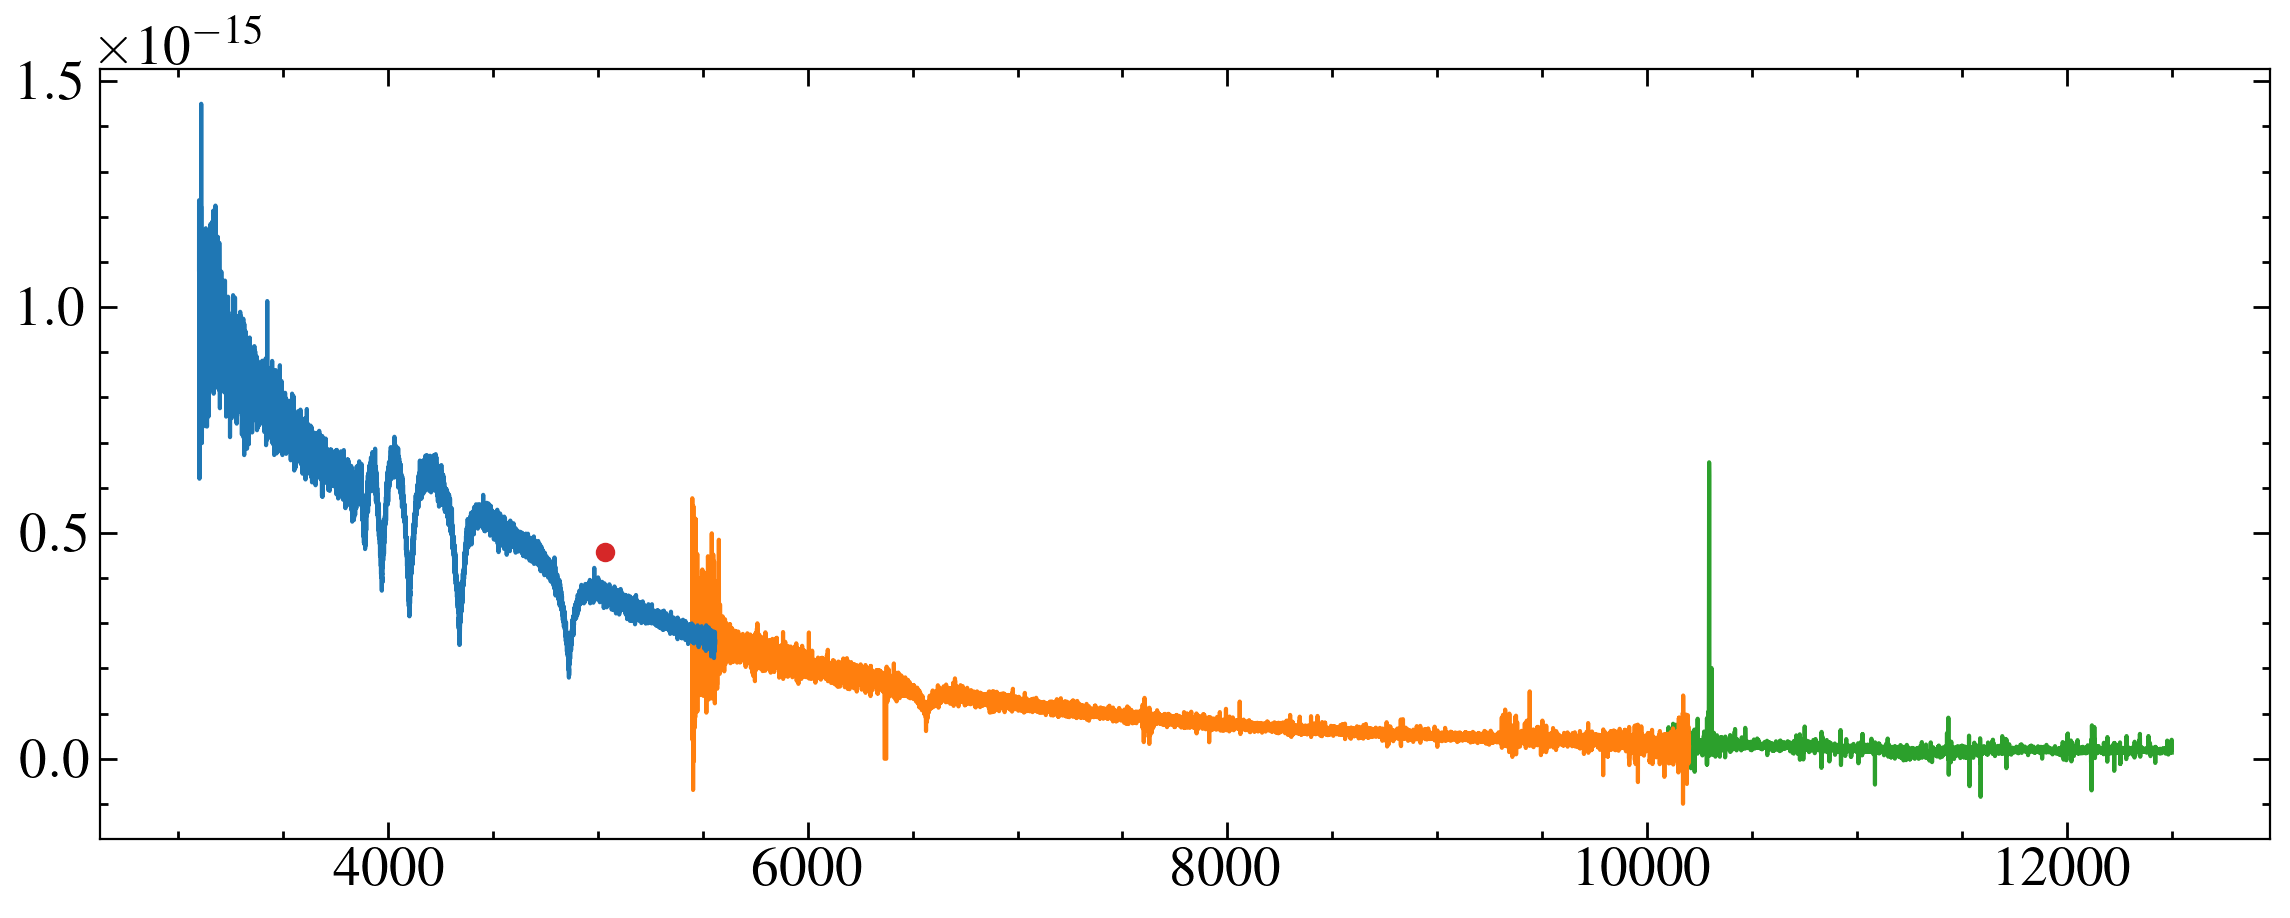

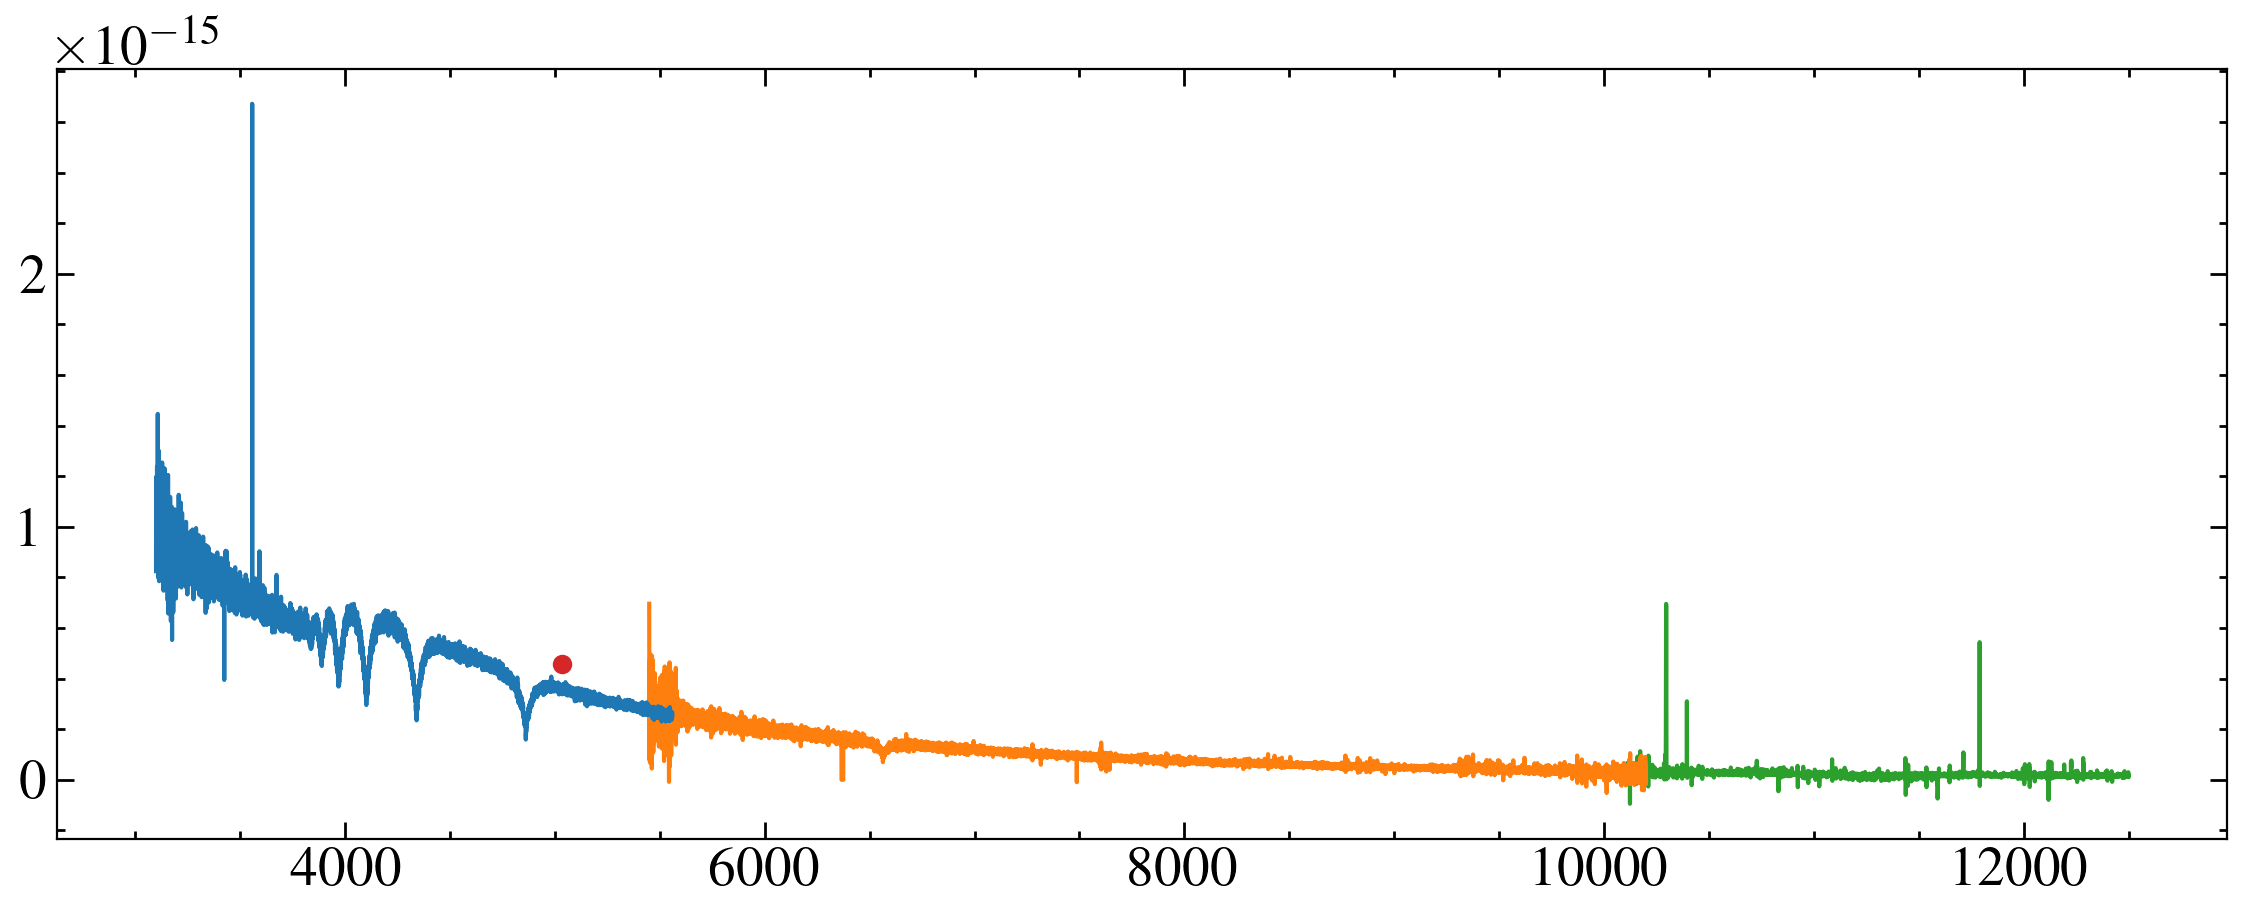

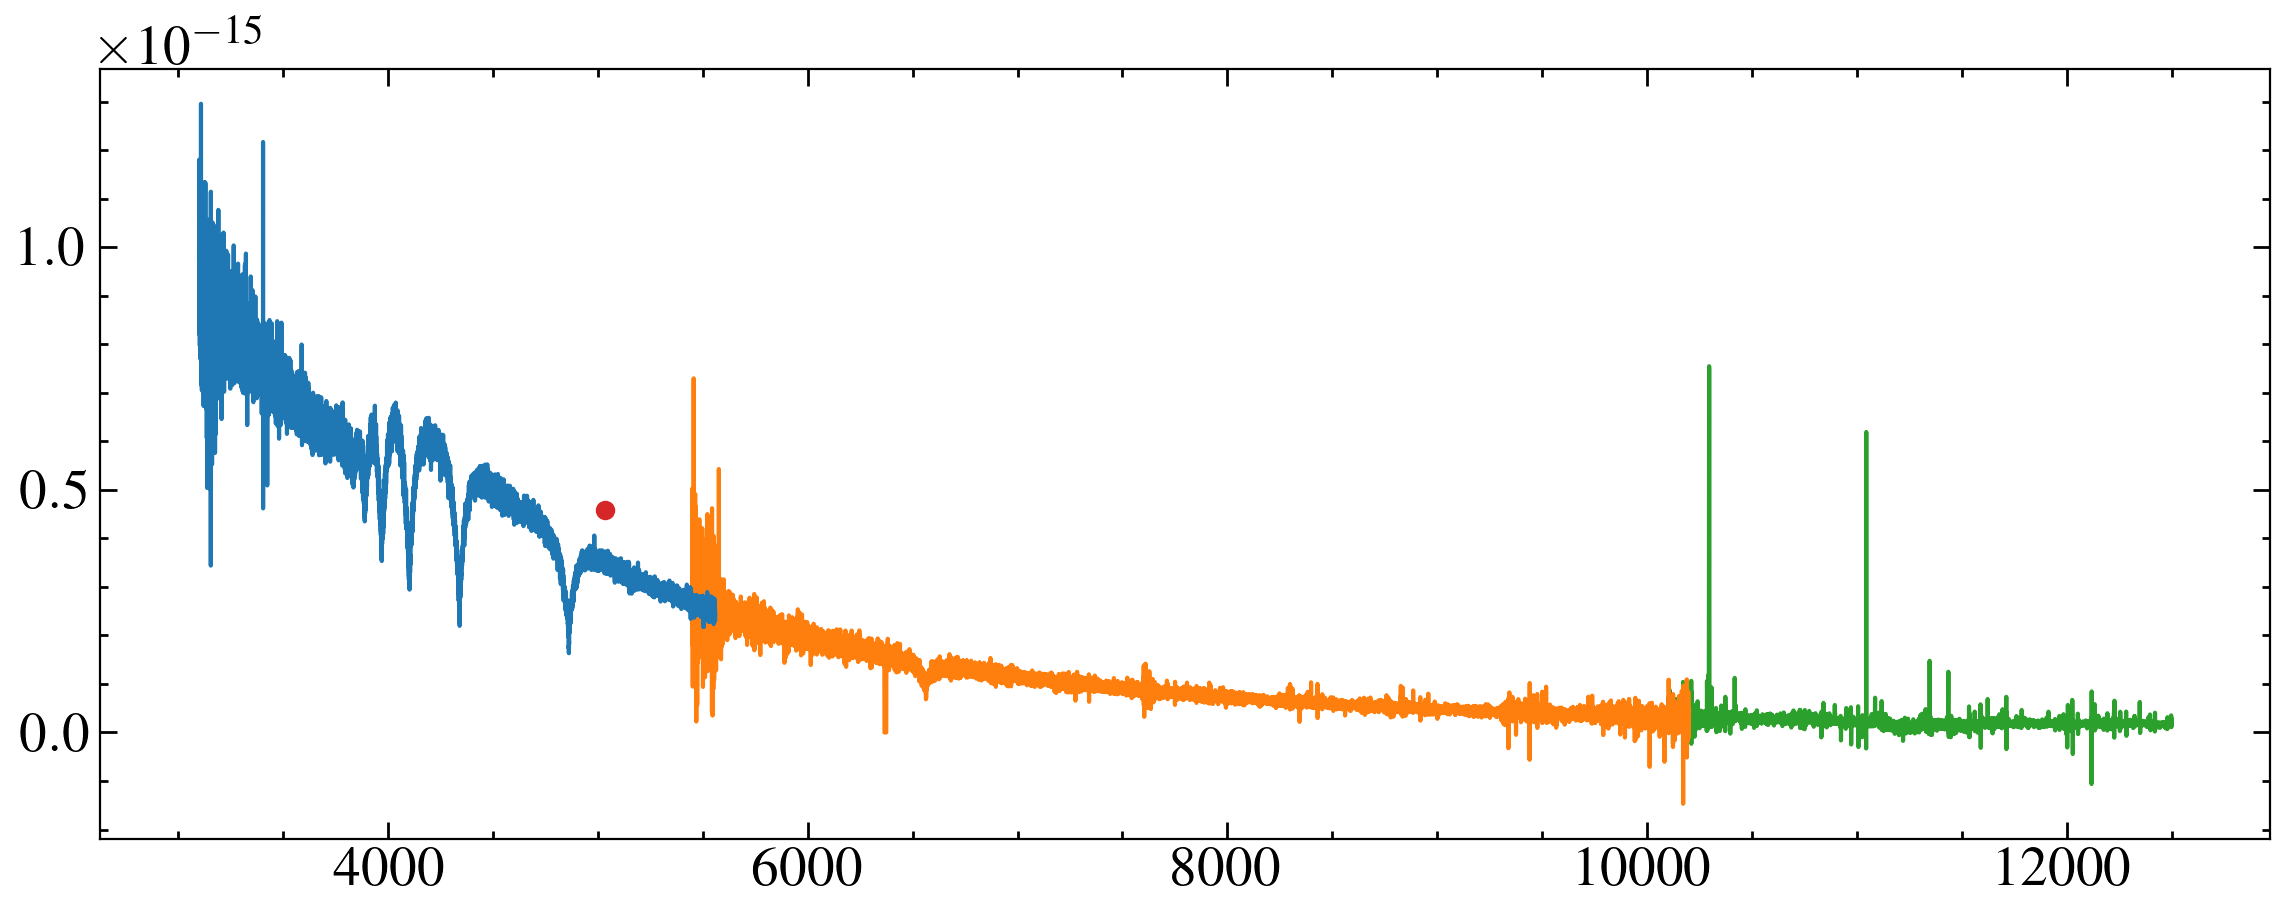

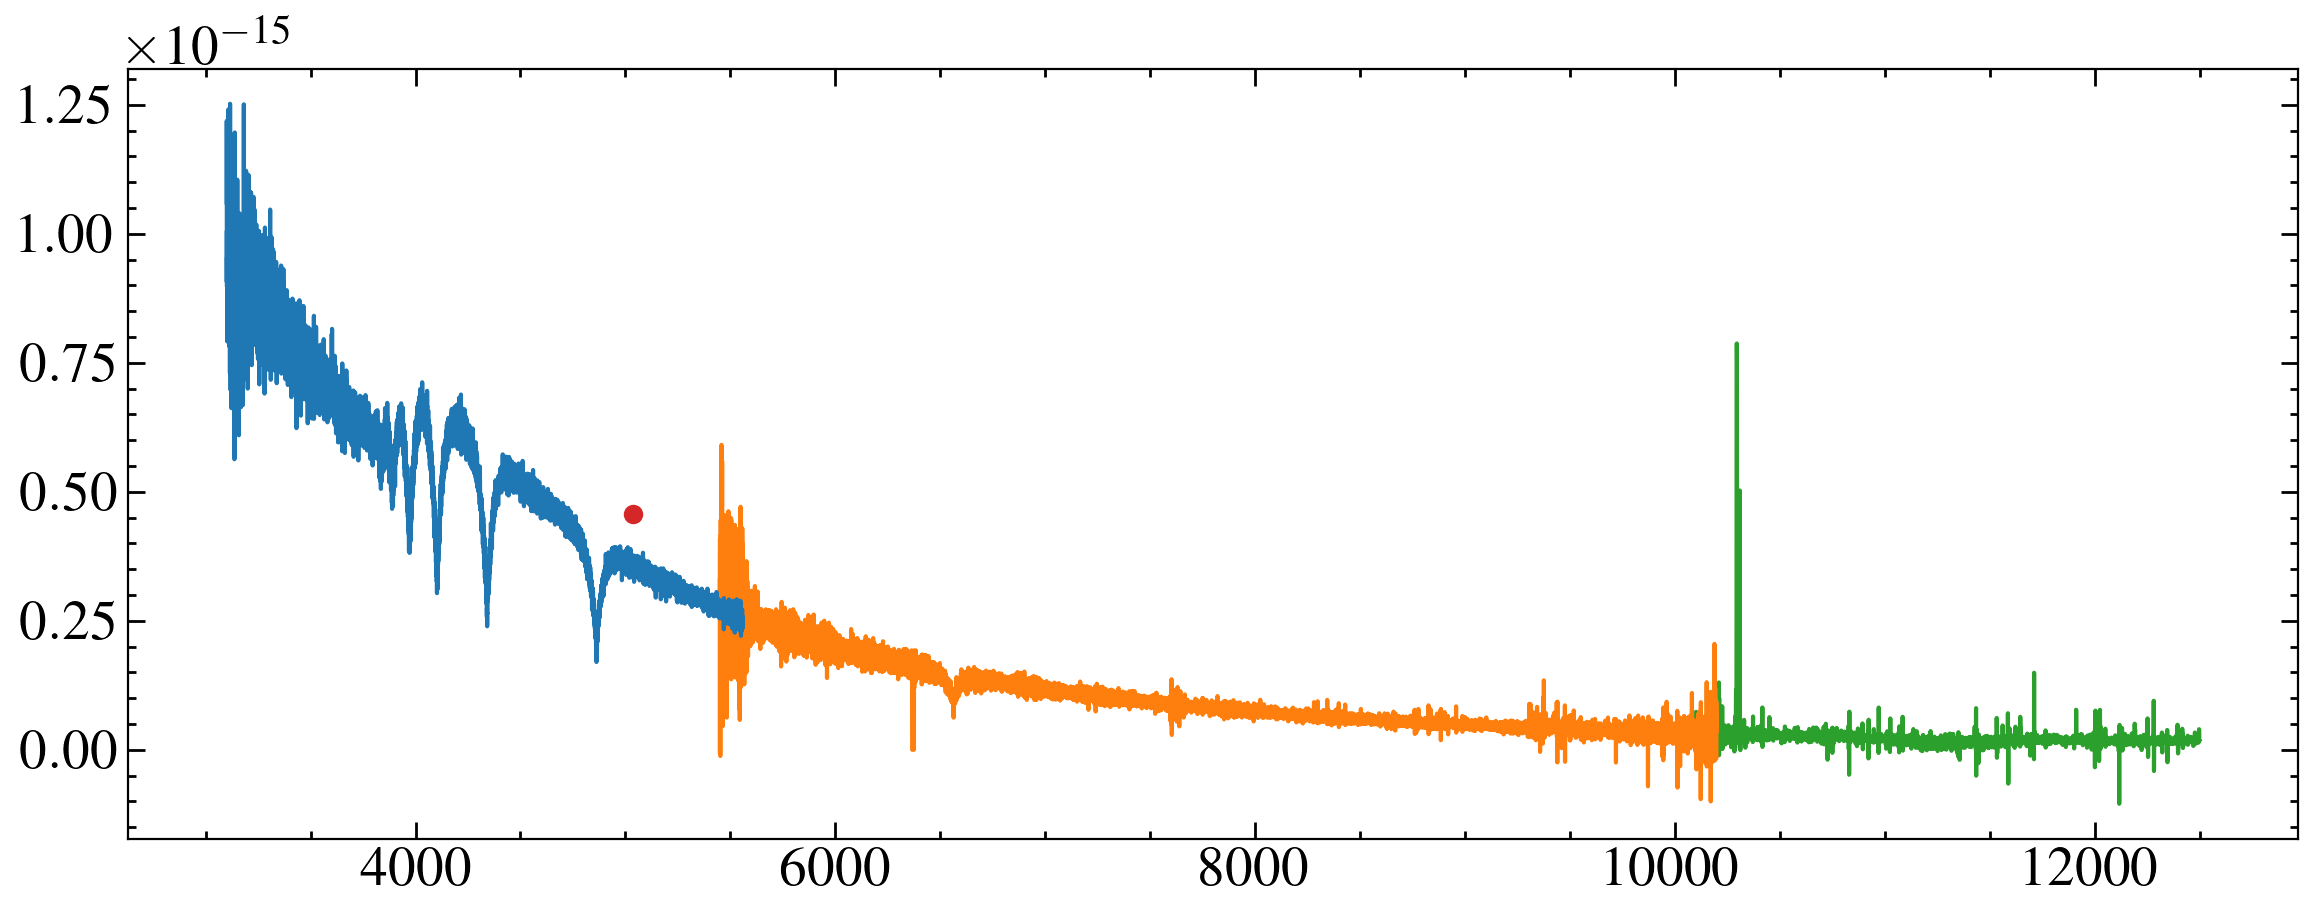

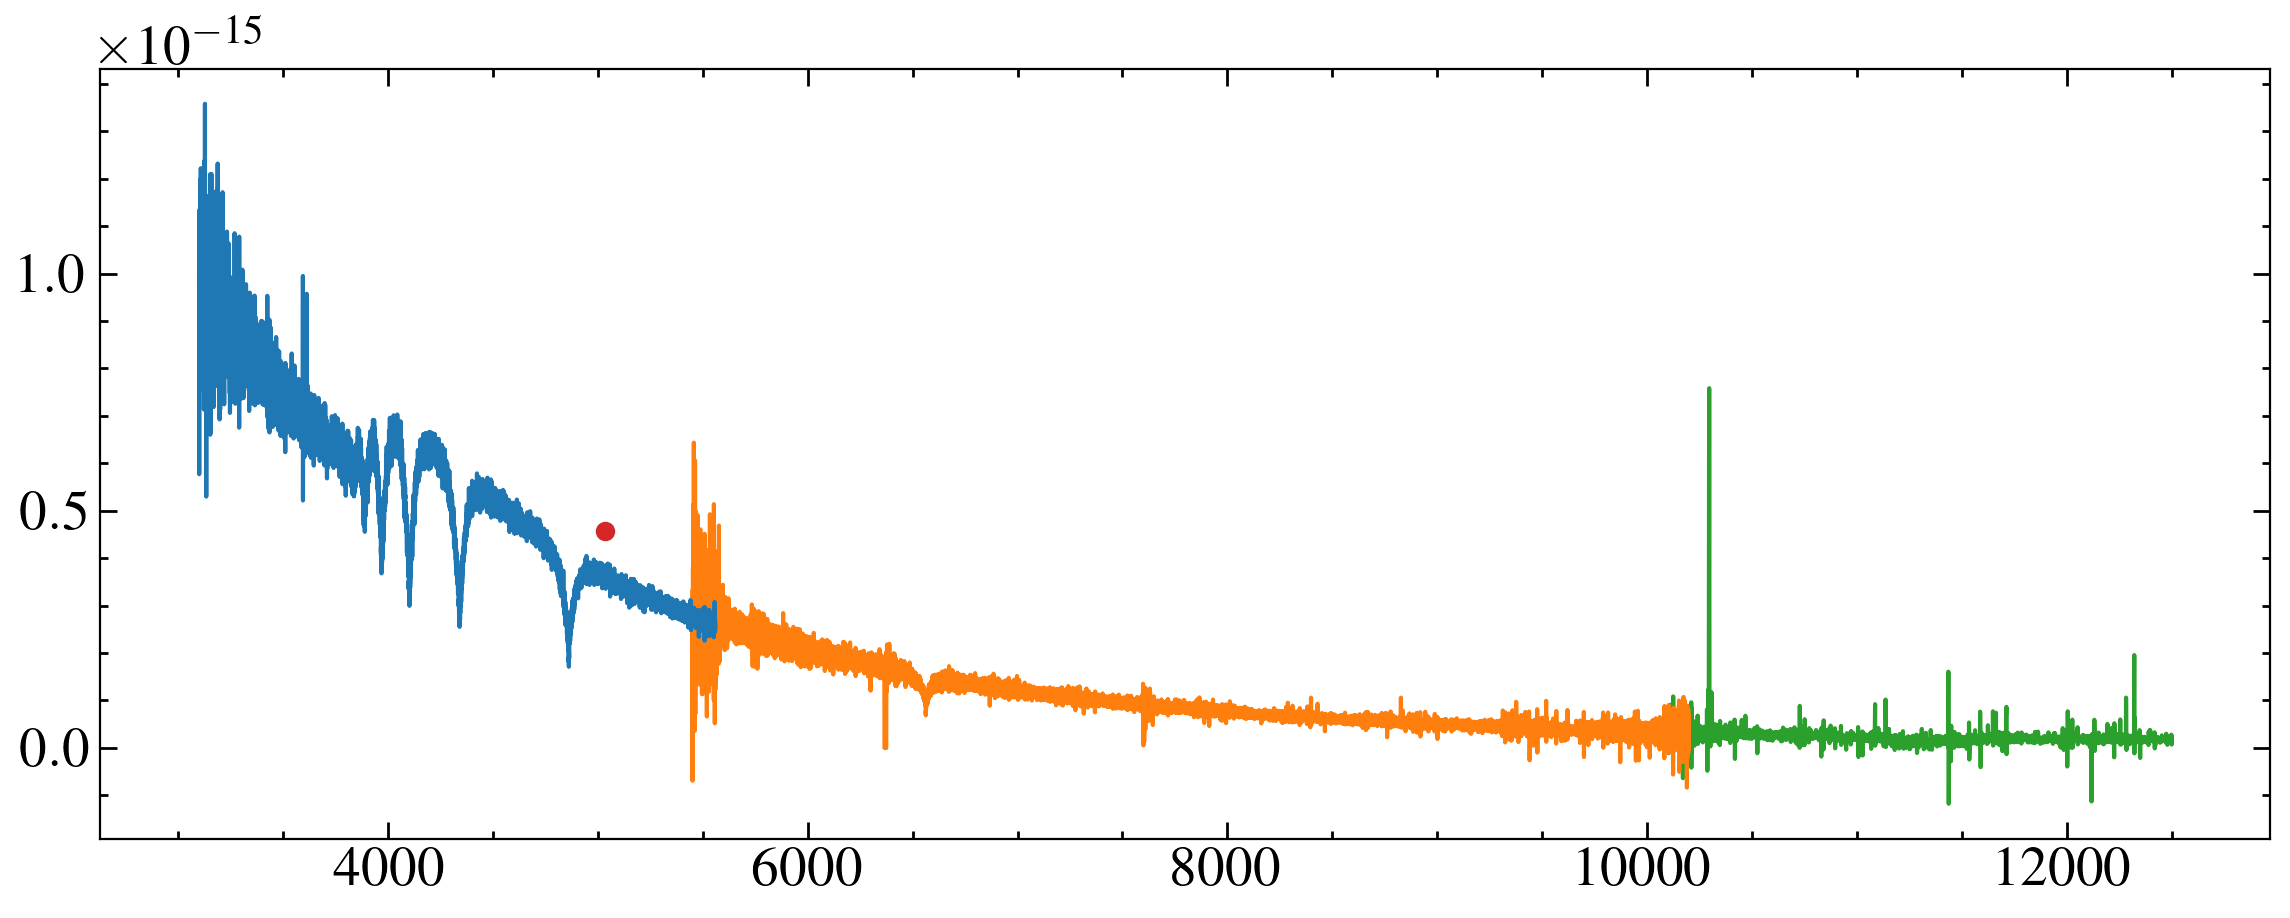

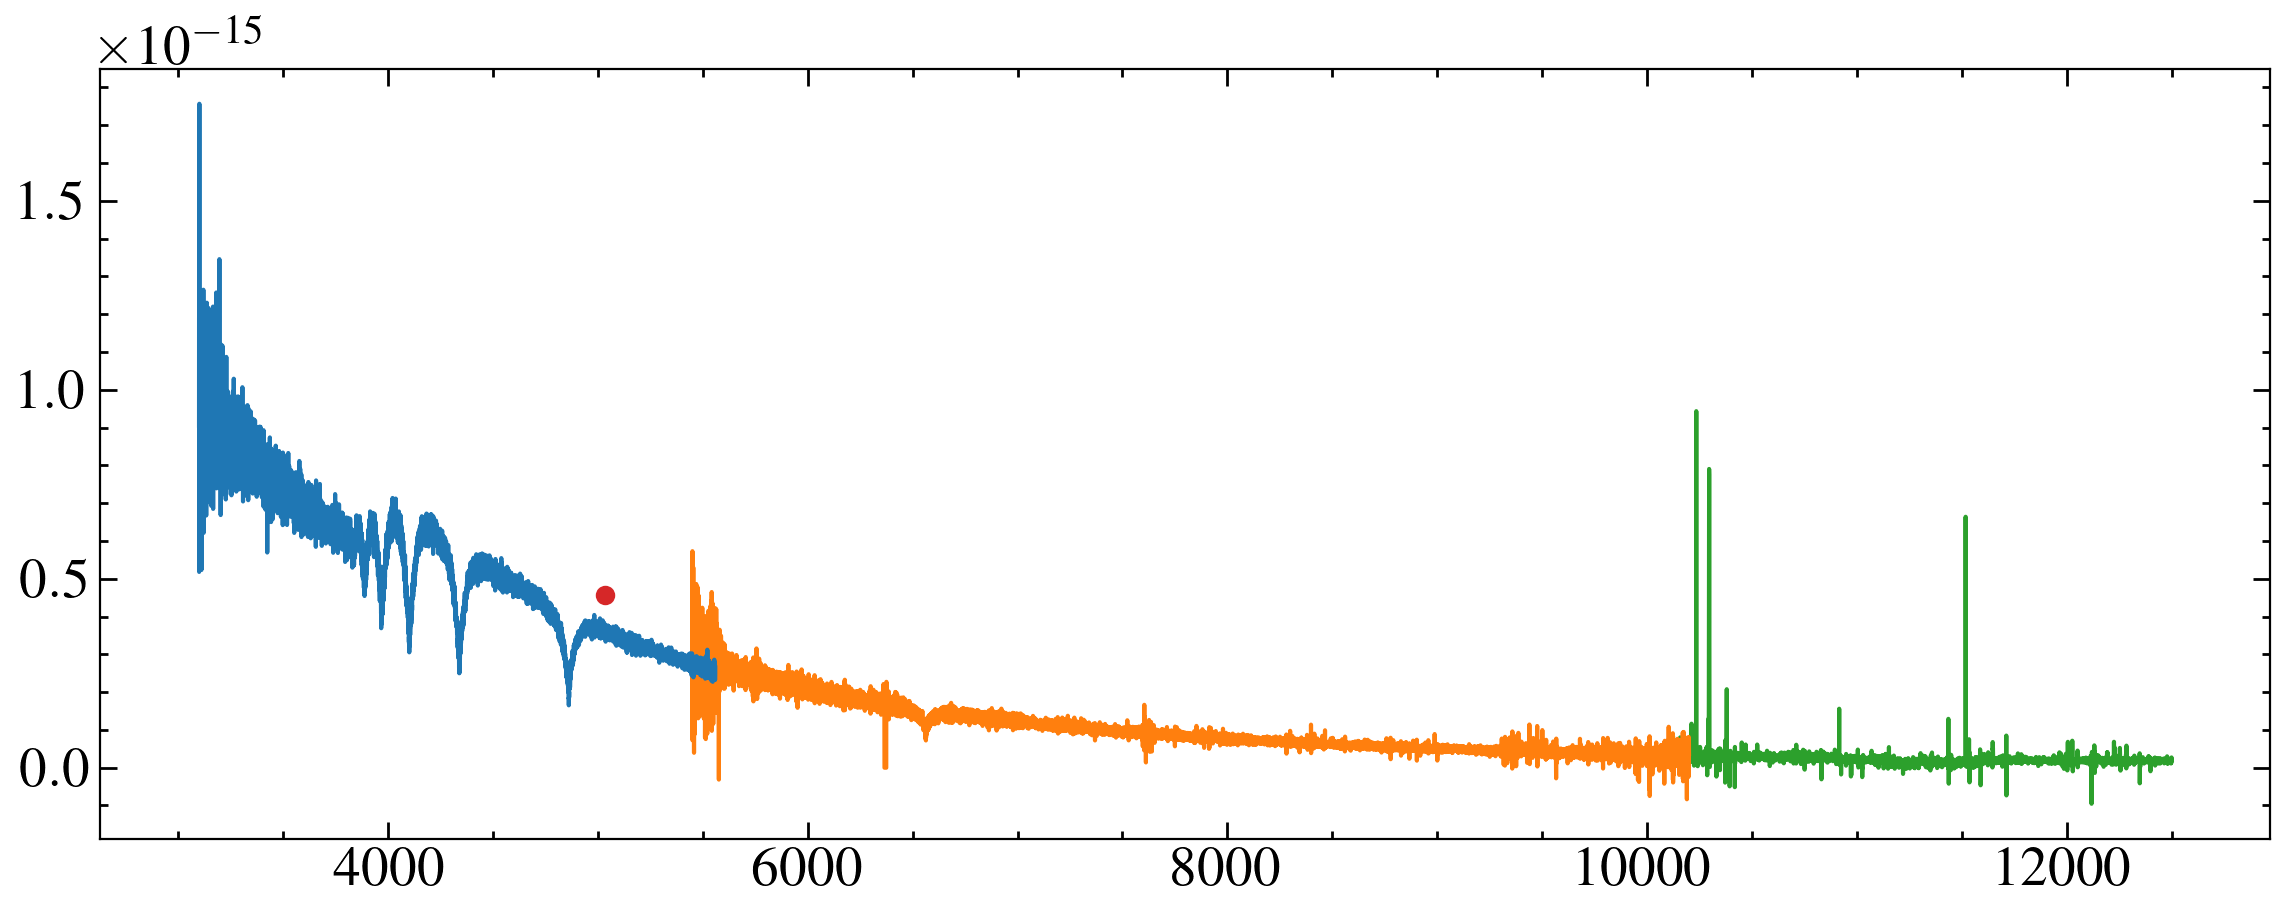

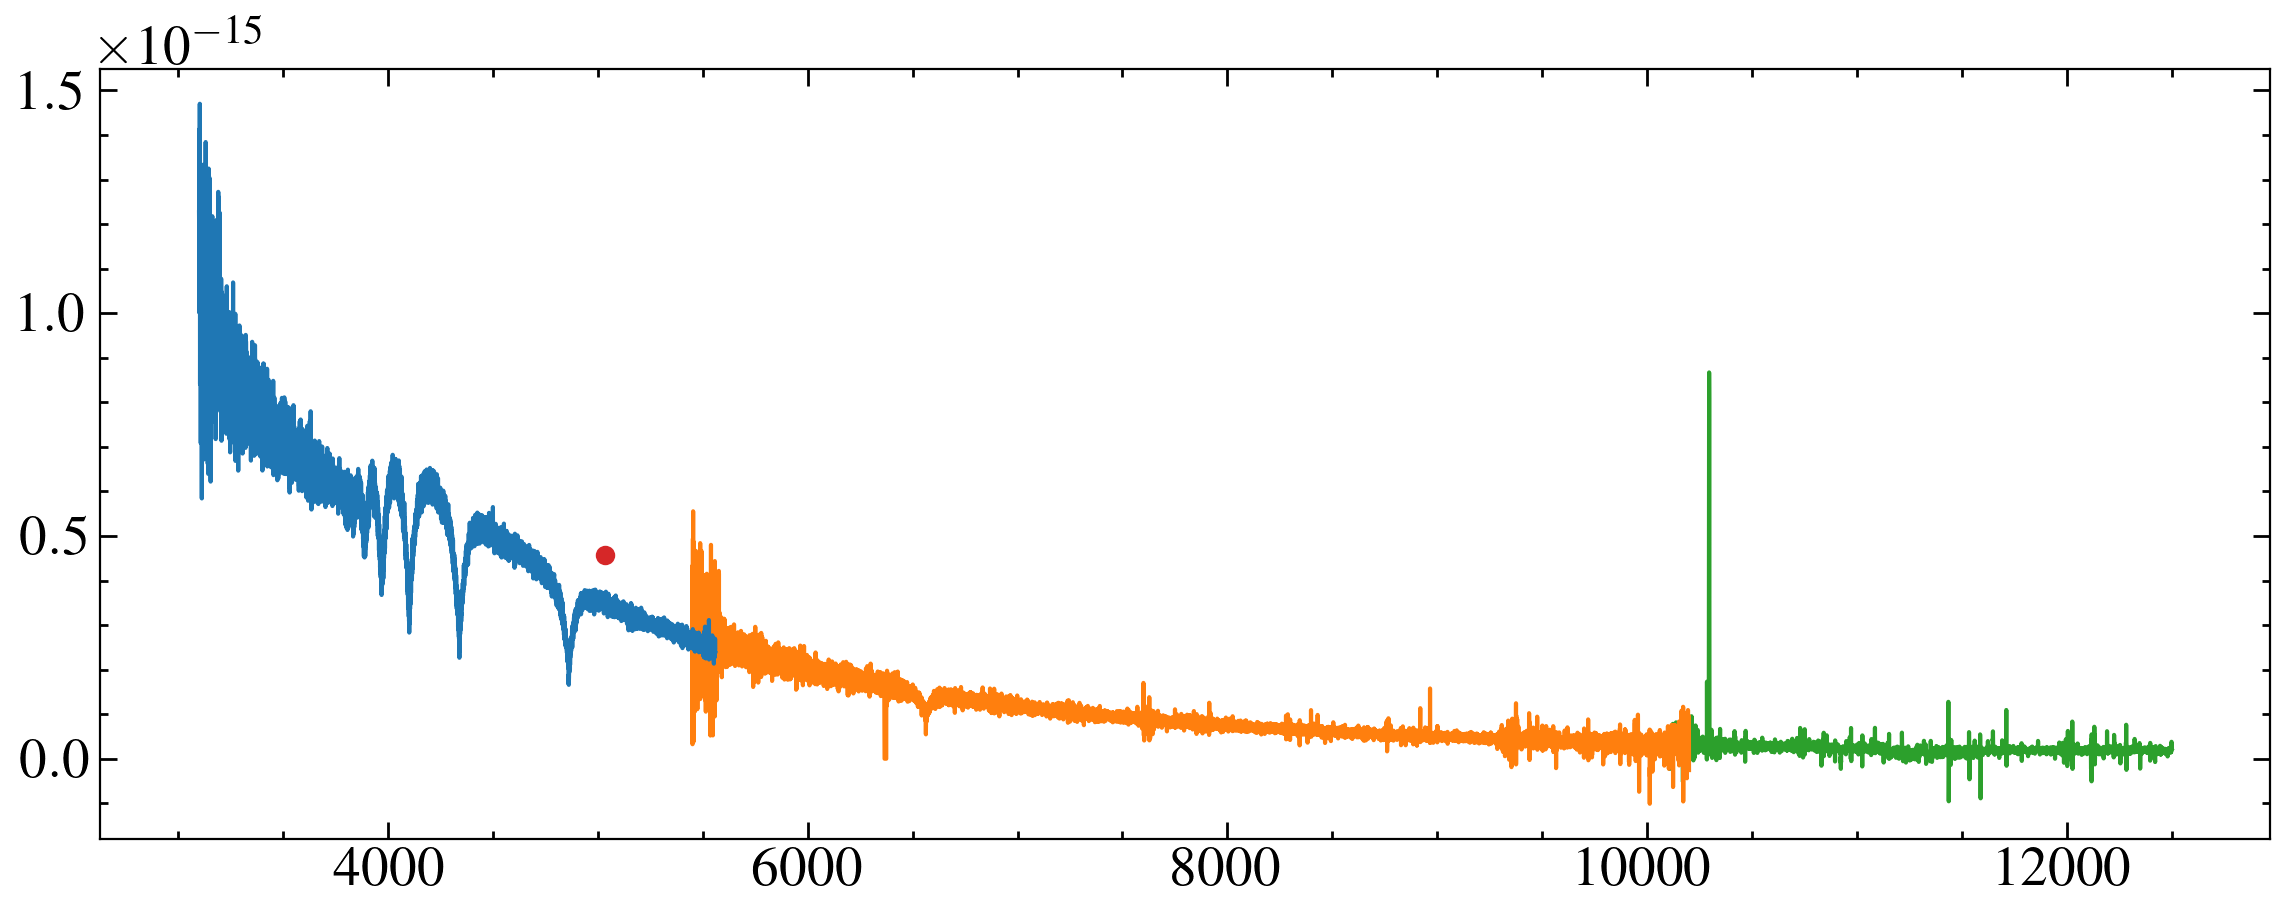

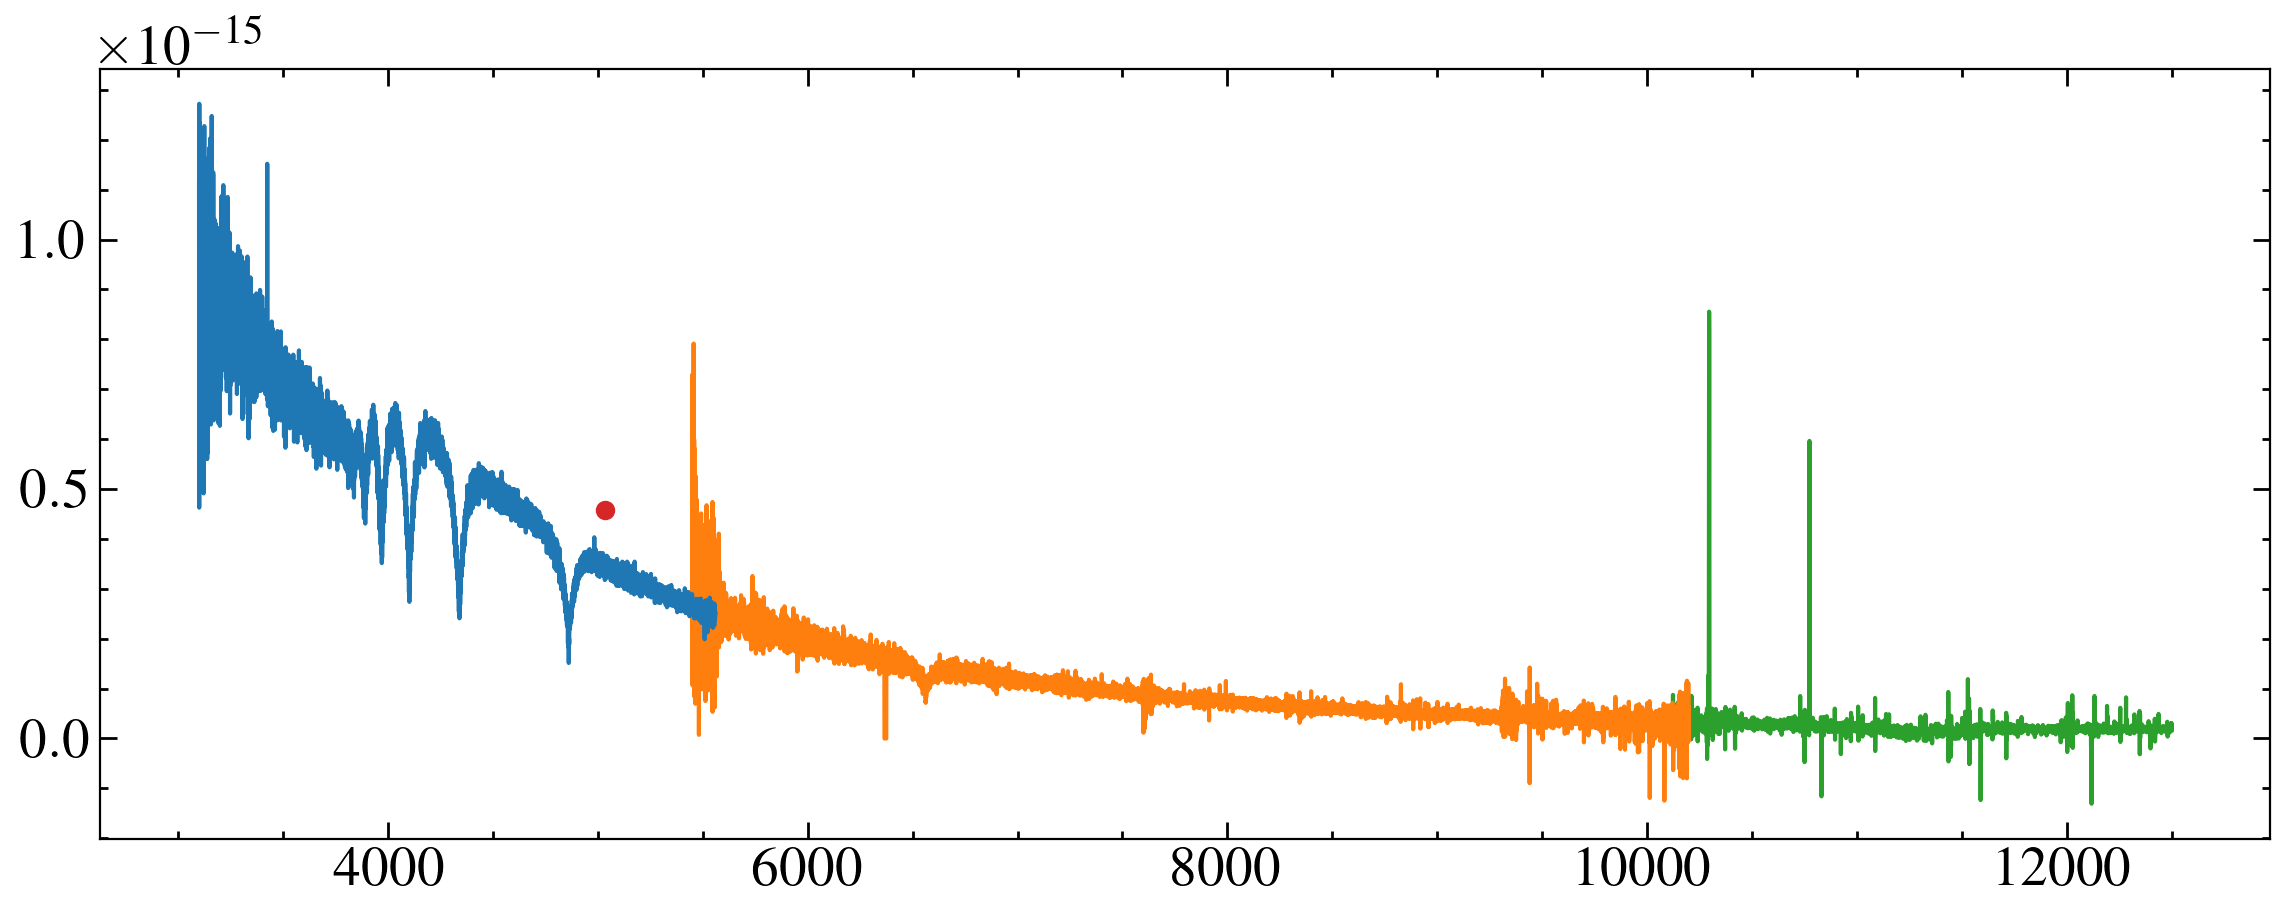

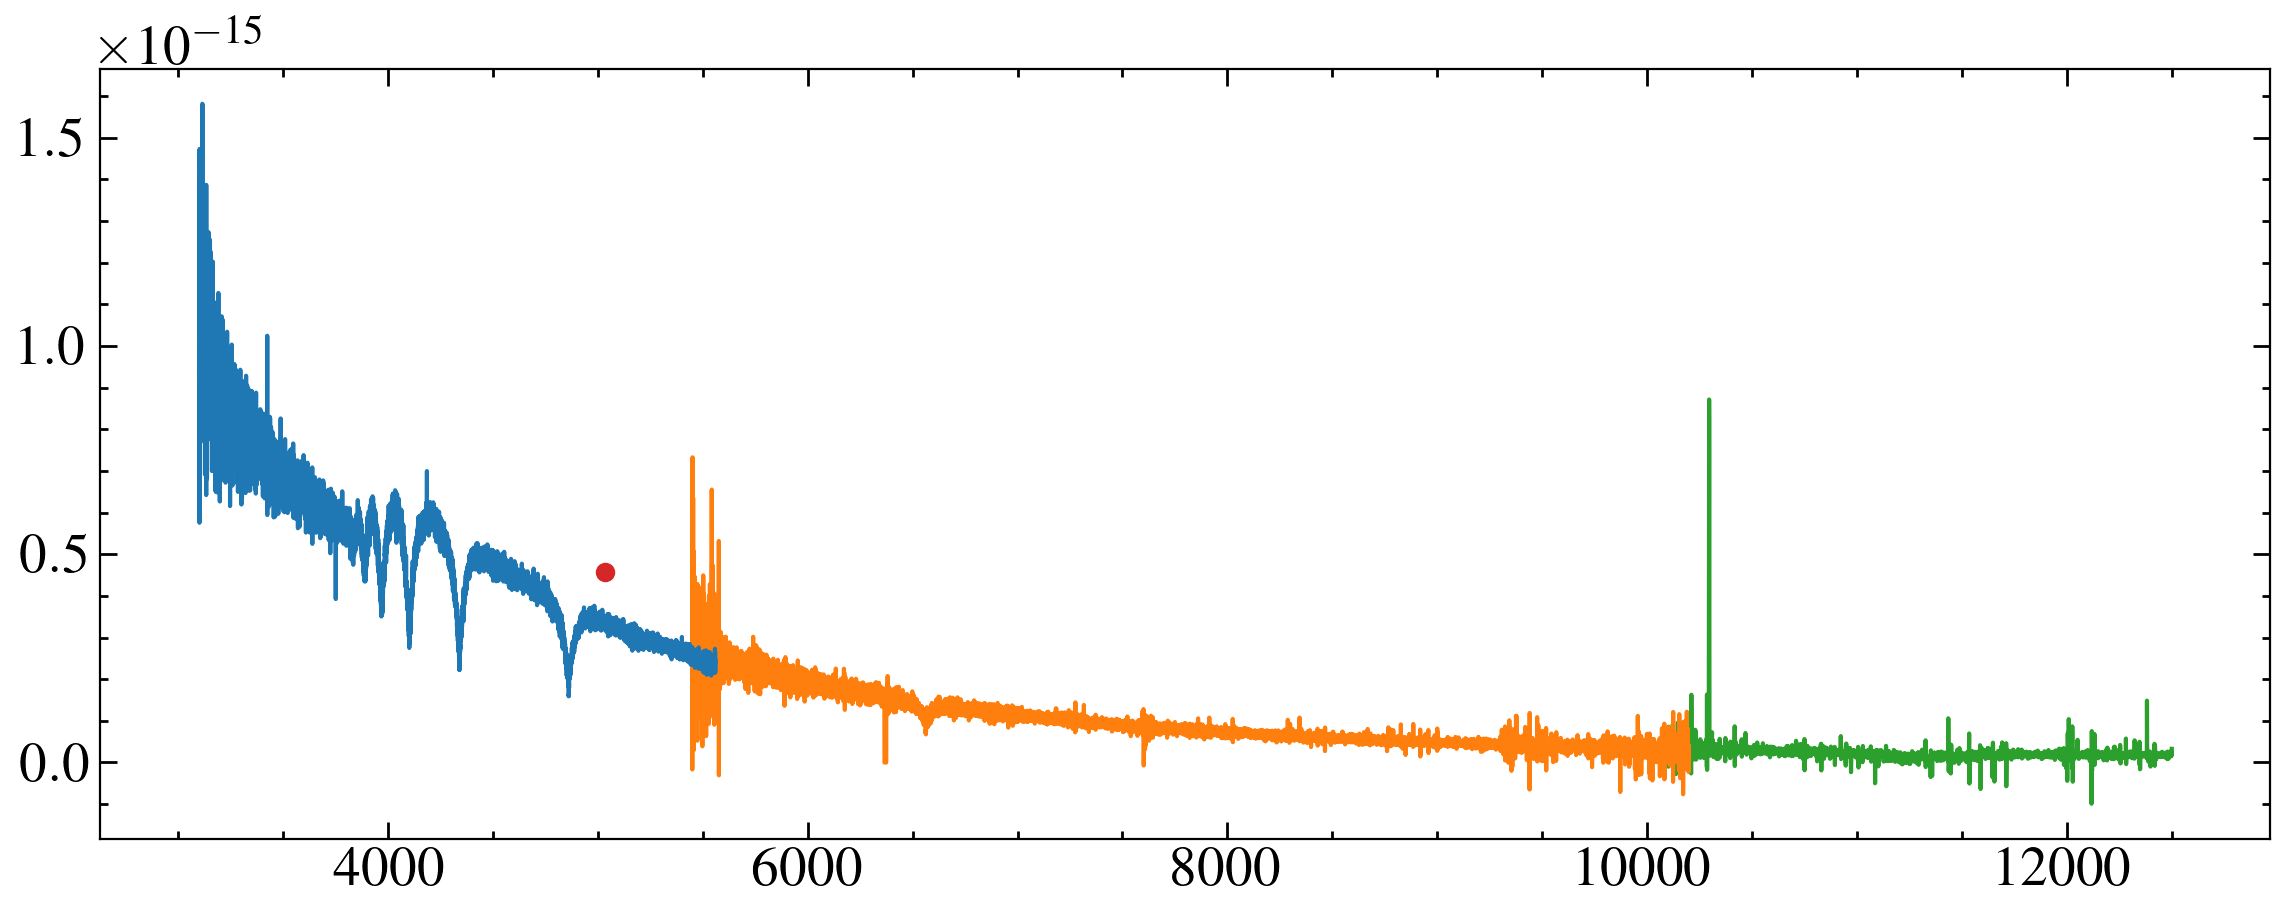

In [16]:
gaia_b =[595.30e+3,	387.e-6,	3.e-6] #hz, jy, jy
gw = (gaia_b[0]*u.GHz).to(u.AA, equivalencies=u.spectral())
gf =(gaia_b[1]* u.Jy).to(u.erg / u.cm**2 / u.s / u.AA,
                equivalencies=u.spectral_density(gw))
ge = gf*gaia_b[2]/gaia_b[1]


for i in range(nspec):

    fig, ax = plt.subplots()
    uw, uf, ue = np.loadtxt('{}UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_{}.csv'.format(path, i), unpack=True, delimiter=',')
    umask = uw > 3100
    uw, uf, ue = uw[umask], uf[umask], ue[umask]
    ax.plot(uw, uf)

    vw, vf, ve = np.loadtxt('{}VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_{}_TAC.csv'.format(path, i), unpack=True, delimiter=',')
    vmask = vw > 5450
    vw, vf, ve = vw[vmask], vf[vmask], ve[vmask]
    ax.plot(vw, vf, zorder=-1)
    if i not in (4, 5, 6, 7):
        adj = 0
        if i > 6:
            adj = 4
        nw, nf, ne = np.loadtxt('{}NIR/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_NIR_{}.csv'.format(path, i-adj), unpack=True, delimiter=',')
        nmask = (nw > 10100) & (nw < 12500)
        nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
        ax.plot(nw, nf, zorder=-2)
    ax.errorbar(gw, gf, yerr=ge, marker='o')
    # ax.set_xlim(10000, 12000)

In [17]:
# for i in range(nspec):

#     fig, axes = plt.subplots(nrows=2, height_ratios=[2, 1], sharex=True)
#     ax = axes[0]
#     ax1 = axes[1]
#     uw, uf, ue = np.loadtxt('{}UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_{}.csv'.format(path, i), unpack=True, delimiter=',')
#     umask = uw > 3100
#     uw, uf, ue = uw[umask], uf[umask], ue[umask]
#     ax.plot(uw, uf)

#     vw, vf, ve = np.loadtxt('{}VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_{}_TAC.csv'.format(path, i), unpack=True, delimiter=',')
#     vmask = vw > 5450
#     vw, vf, ve = vw[vmask], vf[vmask], ve[vmask]
#     ax.plot(vw, vf, zorder=-1)
#     u1, v0 = uw[-1], vw[0]
#     wi = uw[uw > v0]
#     ufi = uf[uw > v0]
#     vfi = np.interp(wi, vw[vw < u1],vf[vw < u1])
#     ax1.plot(wi,ufi/vfi)
#     print(np.mean(ufi/vfi), np.median(ufi/vfi), np.std(ufi/vfi))
#     if i not in (4, 5, 6, 7):
#         adj = 0
#         if i > 6:
#             adj = 4
#         nw, nf, ne = np.loadtxt('{}NIR/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_NIR_{}.csv'.format(path, i-adj), unpack=True, delimiter=',')
#         nmask = (nw > 10100) & (nw < 12500)
#         nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
#         ax.plot(nw, nf, zorder=-2)
#     # ax.set_xlim(10000, 12000)
#     ax1.axhline(1, ls='--', c='0.5')
#     ax1.set_ylim(0.1, 10)

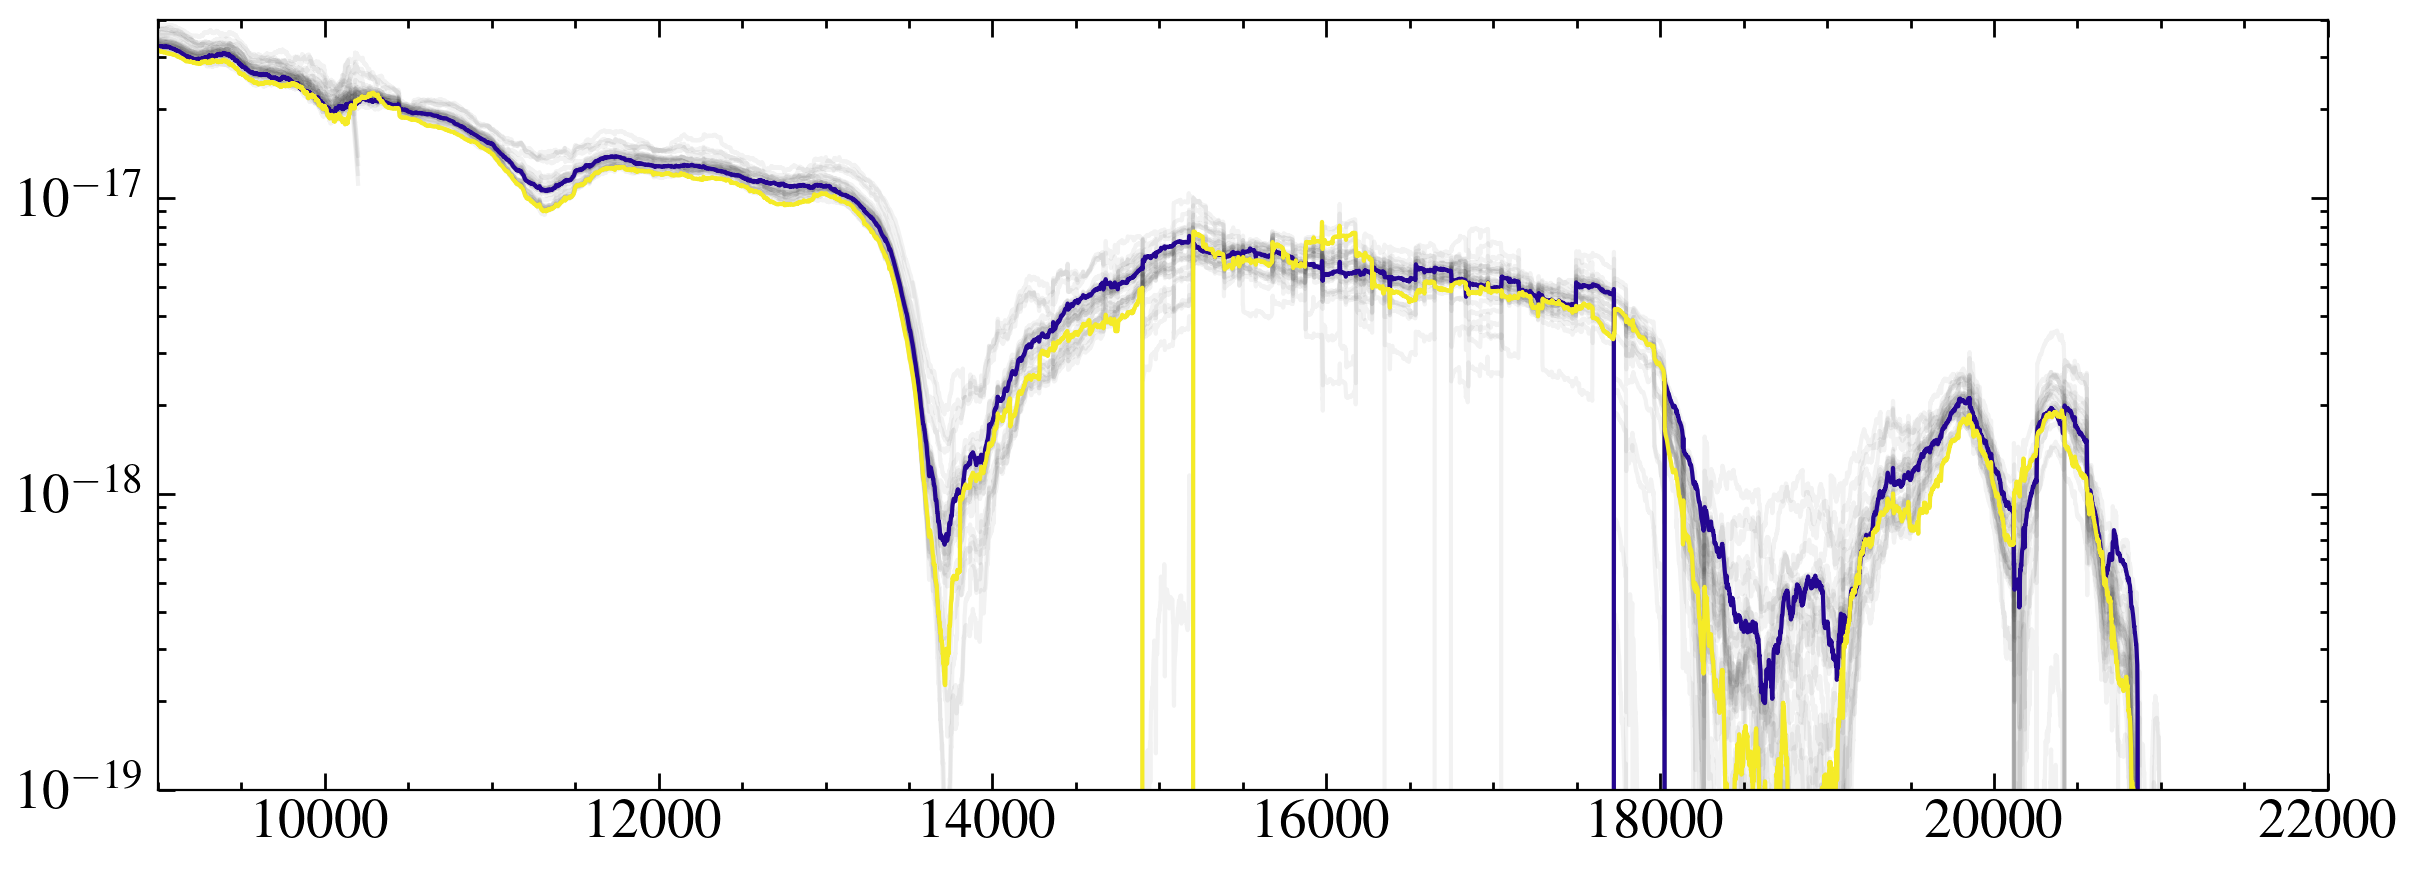

In [68]:
fig, ax = plt.subplots()


fit_period = 4.223067122780375
eph = 58601.212968249274
phases = (np.array(udates)-eph)/(fit_period/24) % 1




for i in range(nspec):
    w_all, f_all, e_all = [], [], []

    uw, uf, ue = np.loadtxt('{}UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_{}.csv'.format(path, i), unpack=True, delimiter=',')
    umask = uw > 3100
    uw, uf, ue = uw[umask], uf[umask], ue[umask]
    # ax.plot(uw, uf)
    mask = (uw > 4000) & (uw < 5000)
    scaleflux = np.trapezoid(uf[mask], uw[mask])
    if i == 0:
        anchor = scaleflux
        scale= 1.0
    else:
        scale = scaleflux/anchor

    vw, vf, ve = np.loadtxt('{}VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_{}_TAC.csv'.format(path, i), unpack=True, delimiter=',')
    vmask = vw > 5450
    vw, vf, ve = vw[vmask], vf[vmask], ve[vmask]
    # ax.plot(vw, vf, zorder=-1)

    w_all = np.hstack((uw, (vw[vw > uw[-1]])))
    f_all = np.hstack((uf, (vf[vw > uw[-1]])))
    e_all= np.hstack((ue,(ve[vw > uw[-1]])))
    
    if i not in (4, 5, 6, 7):
        adj = 0
        if i > 6:
            adj = 4
        nw, nf, ne = np.loadtxt('{}NIR/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_NIR_{}.csv'.format(path, i-adj), unpack=True, delimiter=',')
        nmask = (nw > 10100) & (nf < 4e-16)
        nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
        # ax.plot(nw, nf, zorder=-2)
    # ax.errorbar(gw, gf, yerr=ge, marker='o')
        # w_all.append(nw[nw > vw[-1]])
        # f_all.append(nf[nw > vw[-1]])
        # e_all.append(ne[nw > vw[-1]])
        w_all = np.hstack((uw, (vw[vw > uw[-1]]), (nw[nw > vw[-1]])))
        f_all = np.hstack((uf, (vf[vw > uw[-1]]),(nf[nw > vw[-1]])))
        e_all= np.hstack((ue,(ve[vw > uw[-1]]), (ne[nw > vw[-1]])))
        

    f_all = convolve(f_all, kernel=Box1DKernel(500))
    colphase = phases[i]
    if phases[i] > 0.5:
        colphase = 1-colphase
    colphase *= 2
    # just plot some phases
    phasemask = (phases < 0.1) | (phases > 0.4) & (phases < 0.6) | (phases >0.9)    
    
    # if phases[i] in phases[phasemask]: 
        # ax.plot(w_all,f_all/scale, alpha=0.5, c= plt.cm.plasma(colphase))
    phase5 = np.argmin(abs(0.5-phases))
    phase0 = np.argmin(np.min(((phases), (1-phases)), axis=0))
    if i in [phase0, phase5]:
        # print(phases[i])
        ax.plot(w_all,f_all/scale, alpha=1, c= plt.cm.plasma(colphase))
    ax.plot(w_all,f_all/scale, alpha=0.05, c='k', zorder=-1)
    
    
    # ax.set_xlim(10000, 12000)
# ax.set_xscale('log')
# ax.set_ylim(-1e-16, 1e-15)
ax.set_xlim(0.9e4, 2.2e4)
ax.set_ylim(1e-19, 4e-17)
ax.set_yscale('log')

In [50]:
phases

array([0.28843723, 0.3147145 , 0.35465141, 0.38089513, 0.63210272,
       0.67807049, 0.73850111, 0.78447943, 0.85023463, 0.88303683,
       0.91584233, 0.94863928, 0.98143097, 0.02737577, 0.06012536,
       0.09296375, 0.12576794, 0.1585741 , 0.20450575, 0.23727573,
       0.27007141, 0.30286305, 0.33562513, 0.38503599, 0.41782044,
       0.45060817, 0.48340185, 0.51619154, 0.56650295, 0.59927818,
       0.63206395, 0.66481155, 0.69769928])

In [63]:
phases[phase5]

np.float64(0.5161915366587735)

So no. Check the good NIR spectra? Find where they fall in phase and see what that looks like?